# Medical Image Classification

In [25]:
from tqdm import tqdm
import numpy as np
import os
import PIL
import shutil
import tempfile
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

import medmnist
from medmnist import INFO, Evaluator

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader, Dataset
from monai.metrics import ROCAUCMetric
import monai.networks.nets as nets
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    EnsureChannelFirst,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    RandGaussianNoise,
    RandAdjustContrast,
    ScaleIntensity, 
    Transform,
    ToTensor,
    EnsureType,
)
from monai.utils import set_determinism

print_config()

MONAI version: 1.4.dev2441
Numpy version: 1.26.3
Pytorch version: 2.2.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: cf815ed4e44a5b8ce67e894ab0bc2765279a1a59
MONAI __file__: /mnt/hdd/<username>/.local/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: 0.24.0
scipy version: 1.14.1
Pillow version: 10.2.0
Tensorboard version: 2.18.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.17.1
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.0
pandas version: 2.2.3
einops version: 0.8.0
transformers version: 4.46.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the o

## Continue working with OrganMNIST3d 64x64x64

In [26]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 100
BATCH_SIZE = 32
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)
val_dataset = DataClass(split='val', download=download, size=64)
test_dataset = DataClass(split='test', download=download, size=64)

Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /mnt/hdd/marina/.medmnist/organmnist3d_64.npz


In [27]:
root_dir = '/mnt/hdd/marina/.medmnist/'

In [28]:
train_dataset

Dataset OrganMNIST3D of size 64 (organmnist3d_64)
    Number of datapoints: 971
    Root location: /mnt/hdd/marina/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'liver', '1': 'kidney-right', '2': 'kidney-left', '3': 'femur-right', '4': 'femur-left', '5': 'bladder', '6': 'heart', '7': 'lung-right', '8': 'lung-left', '9': 'spleen', '10': 'pancreas'}
    Number of samples: {'train': 971, 'val': 161, 'test': 610}
    Description: The source of the OrganMNIST3D is the same as that of the Organ{A,C,S}MNIST. Instead of 2D images, we directly use the 3D bounding boxes and process the images into 28×28×28 to perform multi-class classification of 11 body organs. The same 115 and 16 CT scans as the Organ{A,C,S}MNIST from the source training set are used as training and validation set, respectively, and the same 70 CT scans as the Organ{A,C,S}MNIST from the source test set are treated as the test set.
    License: CC BY 4.0

## Define transforms

In [29]:
train_transforms = Compose(
    [
        ScaleIntensity(),
        RandGaussianNoise(prob=0.5, mean=0.0, std=0.05),
        RandAdjustContrast(gamma=(0.7, 1.3), prob=0.5),
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
        EnsureType(),
    ]
)

val_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

test_transforms = Compose([
    ScaleIntensity(),
    ToTensor(),
    EnsureType(),
])

y_pred_trans = Compose([Activations(softmax=True)])
y_trans = Compose([AsDiscrete(to_onehot=n_classes)])

## Extract 2d slices

In [30]:
class Extract2DSlices(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]

        # if self.transform:
        #     data = self.transform(data)

        axial, coronal, sagittal = self.extract_2d_slices(data)

        if self.transform:
            axial = self.transform(axial)
            coronal = self.transform(coronal)
            sagittal = self.transform(sagittal)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}
        
        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def extract_2d_slices(data):
        axial = data[:, data.shape[1] // 2, :, :]
        coronal = data[:, :, data.shape[2] // 2, :]
        sagittal = data[:, :, :, data.shape[3] // 2]
        return axial, coronal, sagittal

In [31]:
train_dataset_ = Extract2DSlices(train_dataset, transform=train_transforms)
val_dataset_ = Extract2DSlices(val_dataset, transform=val_transforms)
test_dataset_ = Extract2DSlices(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

### Visualization

In [33]:
idx = np.random.choice(train_dataset_.__len__(), size=10, replace=False)

idx

array([571, 531, 527, 430, 869, 492, 701, 902, 478, 460])

In [34]:
def show_slice(dataset, idx):

    fig, axs = plt.subplots(3,10)

    for i, index in enumerate(idx):
        x1, x2, x3 = dataset[index]['images']
        y = dataset[index]['label']

        ax = axs[0, i]
        ax.imshow(x1[0].numpy(), cmap='gray')
        ax.set_title(f'{y}')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[1, i]
        ax.imshow(x2[0].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

        ax = axs[2, i]
        ax.imshow(x3[0].numpy(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    plt.axis('off')
    plt.figure(figsize=(7,15))
    plt.show()

In [32]:
def montage(dataset, length=20, replace=False, save_folder='dataset', flag = 'axial'):
    from medmnist.utils import montage2d

    imgs = []

    n_sel = length * length
    sel = np.random.choice(dataset.__len__(), size=n_sel, replace=replace)
    
    if flag == 'axial':
        slice_ = 0
    elif flag == 'coronal':
        slice_ = 1
    else:
        slice_ = 2
    
    for idx in sel:
        imgs.append((dataset[idx]['images'][slice_]*255).astype(np.uint8))
        
    montage_img = montage2d(np.array(imgs)[:, 0],
                            n_channels=n_channels,
                            sel=range(0, n_sel))
    
    if save_folder is not None:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        montage_img.save(os.path.join(save_folder,
                                        f"{data_flag}{flag}_montage.png"))

    return montage_img

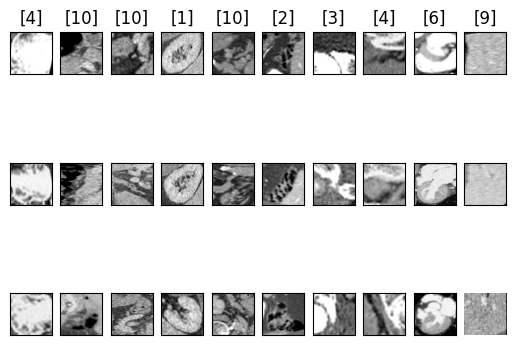

<Figure size 700x1500 with 0 Axes>

In [35]:
show_slice(train_dataset_, idx)

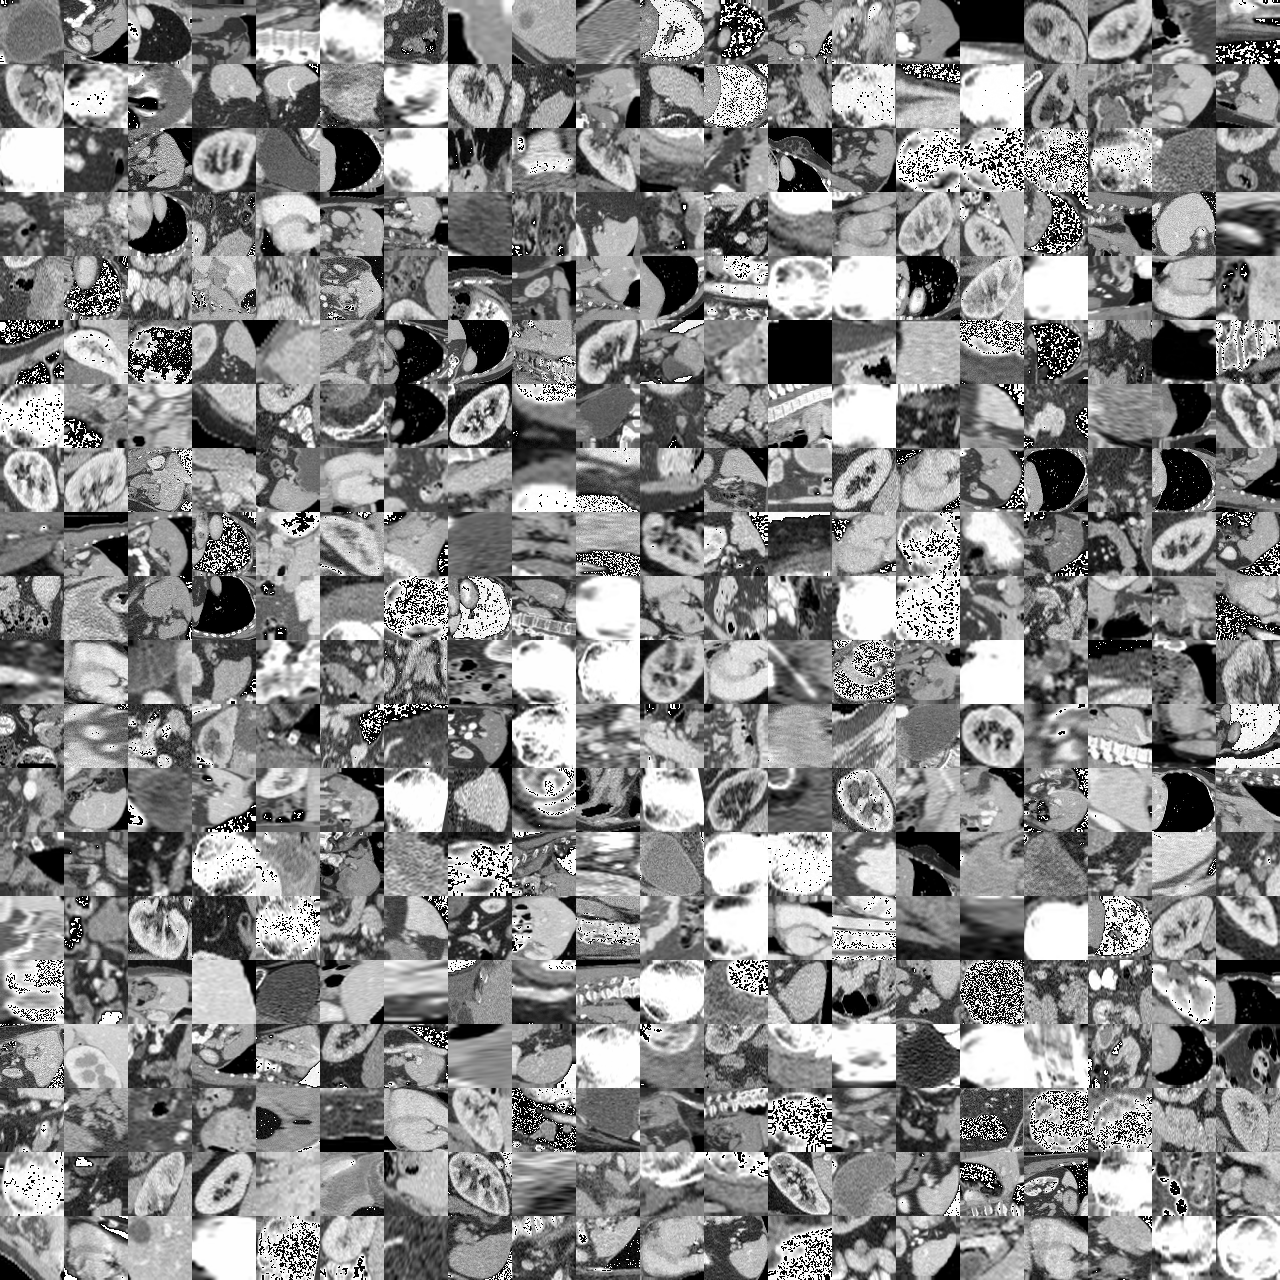

In [36]:
montage(train_dataset_, length=20, replace=False, flag = 'axial')

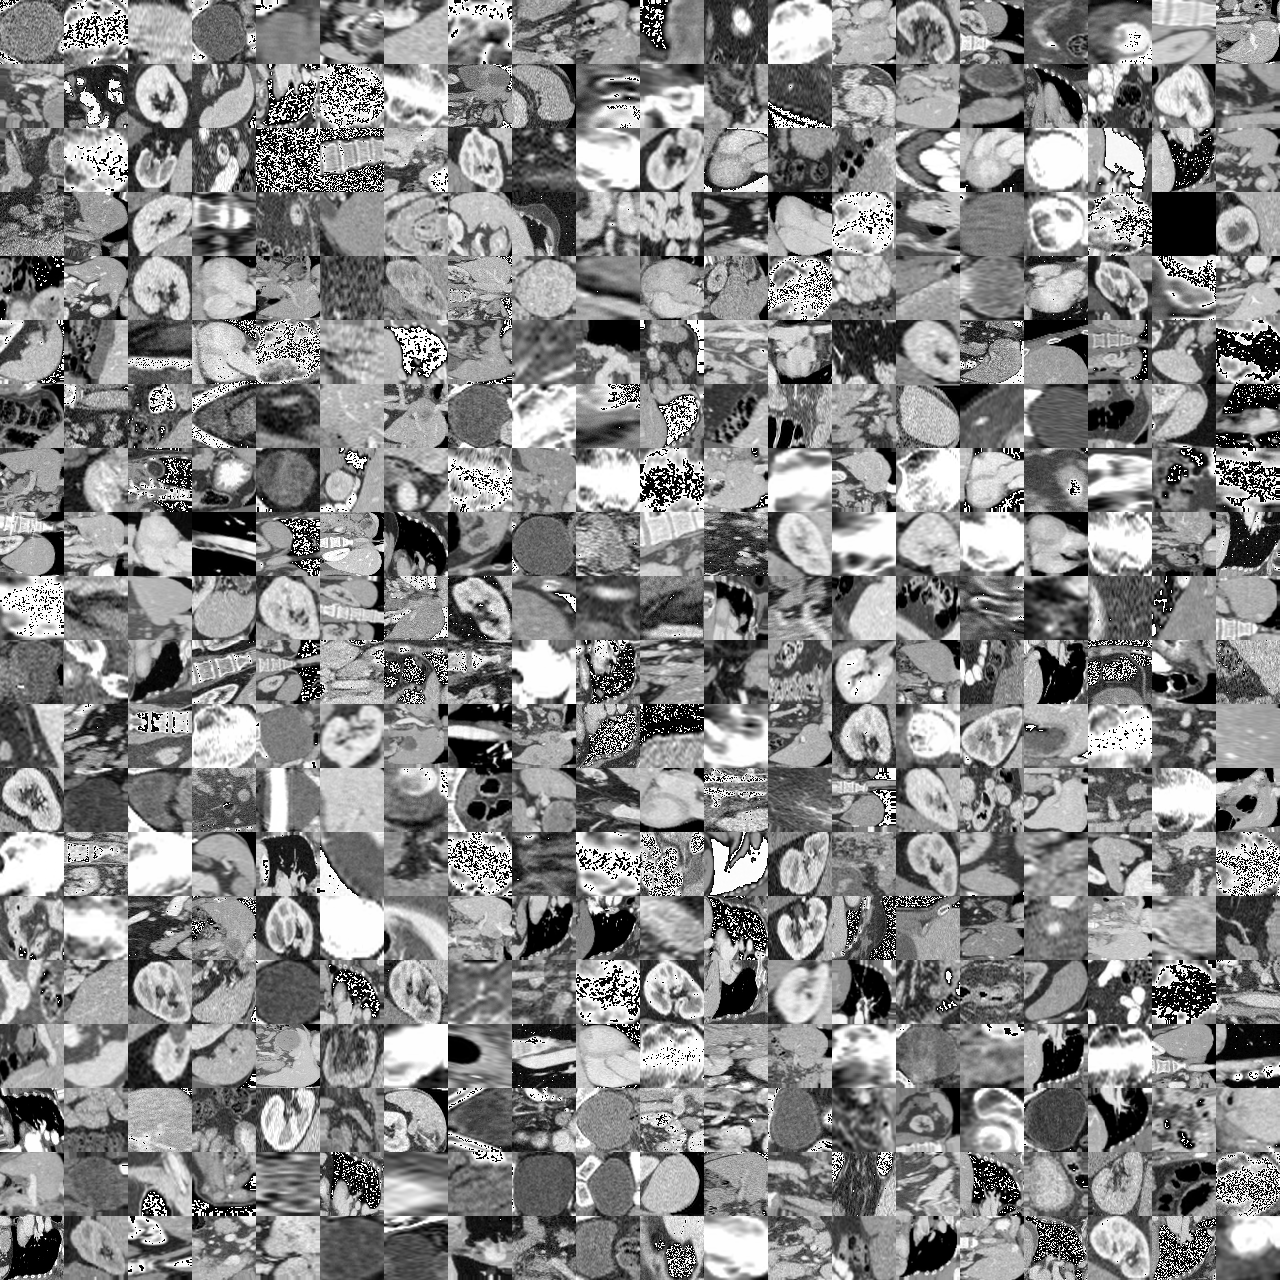

In [37]:
montage(train_dataset_, length=20, replace=False, flag = 'coronal')

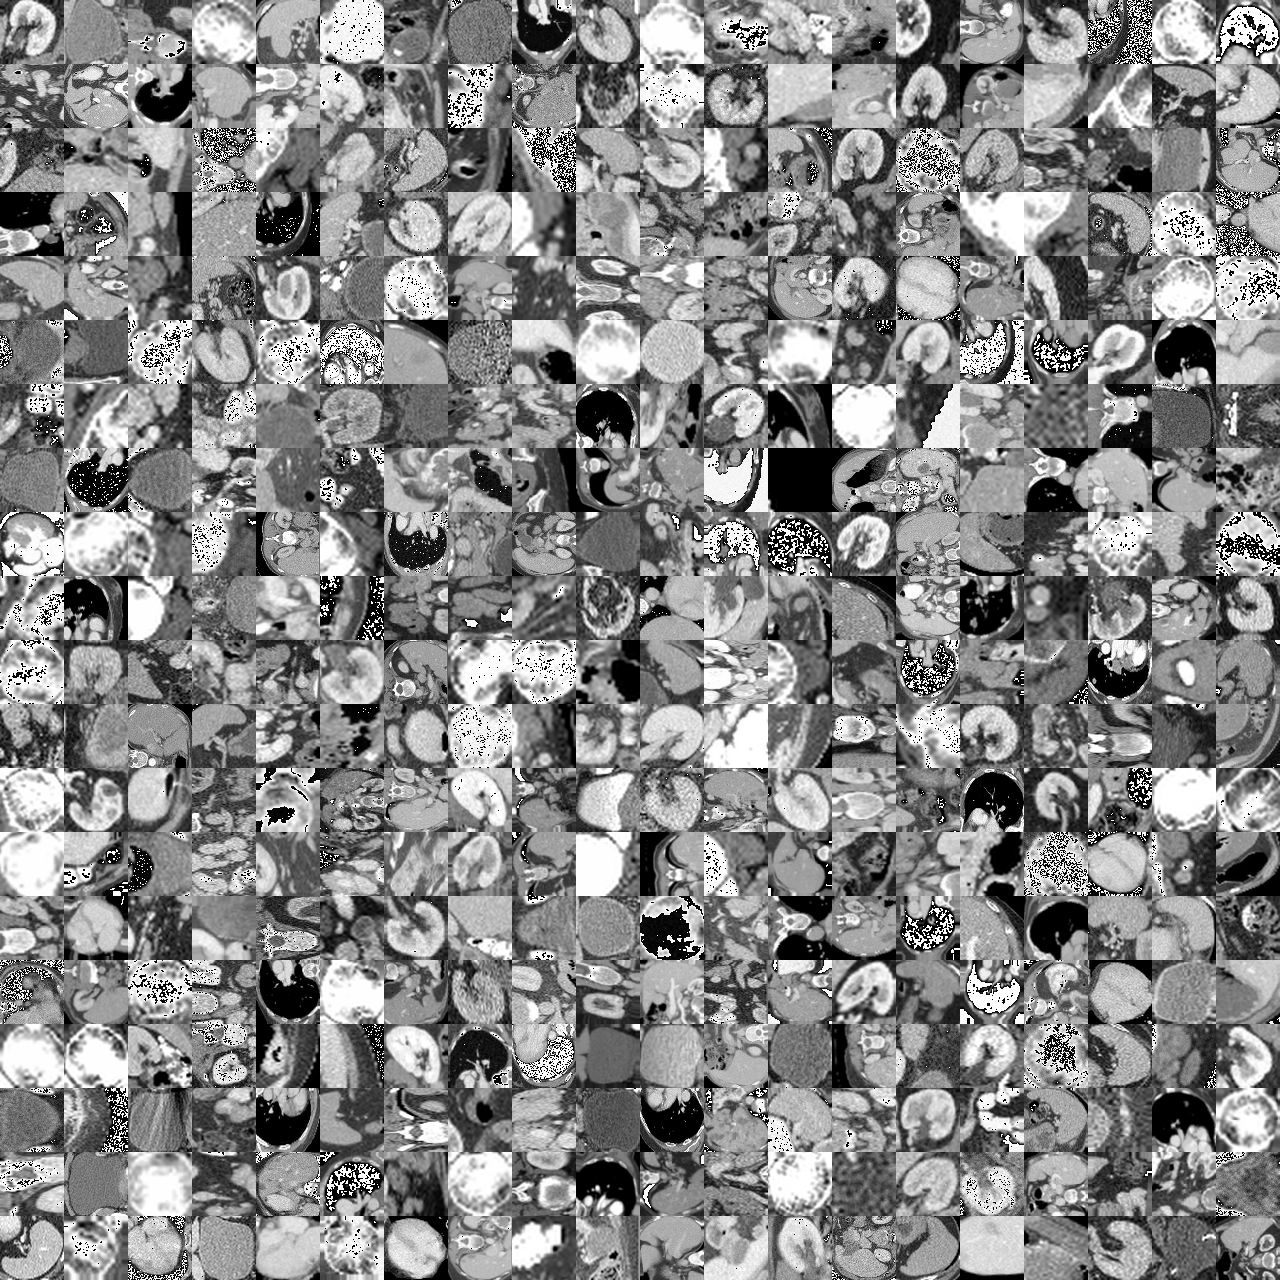

In [48]:
montage(train_dataset_, length=20, replace=False, flag = 'sagittal')

# Axial part

## Pretrained

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [50]:
print(model)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
from tqdm import tqdm

best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    batch_iter = tqdm(train_loader, desc="Training Batches", leave=False)

    for batch_data in batch_iter:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        batch_iter.set_postfix(train_loss=loss.item())
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.35it/s, train_loss=1.56]
                                                                                  

epoch 1 average loss: 2.1874
1


Epochs:   1%|          | 1/100 [00:07<12:21,  7.49s/it]

saved new best metric model
current epoch: 1 current AUC: 0.6585 current accuracy: 0.1863 best AUC: 0.6585 at epoch: 1
----------
epoch 2/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.56it/s, train_loss=1.37]
                                                                                  

epoch 2 average loss: 1.4767
1


Epochs:   2%|▏         | 2/100 [00:14<12:11,  7.47s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9548 current accuracy: 0.6584 best AUC: 0.9548 at epoch: 2
----------
epoch 3/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.48it/s, train_loss=1.12] 
                                                                                  

epoch 3 average loss: 1.1929
1


Epochs:   3%|▎         | 3/100 [00:22<12:05,  7.48s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9796 current accuracy: 0.7453 best AUC: 0.9796 at epoch: 3
----------
epoch 4/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.48it/s, train_loss=1.33]
                                                                                  

epoch 4 average loss: 1.0208
1


Epochs:   4%|▍         | 4/100 [00:29<12:00,  7.51s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9816 current accuracy: 0.7702 best AUC: 0.9816 at epoch: 4
----------
epoch 5/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.47it/s, train_loss=0.965]
                                                                                   

epoch 5 average loss: 0.8863
1


Epochs:   5%|▌         | 5/100 [00:37<11:54,  7.53s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9856 current accuracy: 0.8199 best AUC: 0.9856 at epoch: 5
----------
epoch 6/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.47it/s, train_loss=1.03]
                                                                                  

epoch 6 average loss: 0.8154


Epochs:   6%|▌         | 6/100 [00:44<11:34,  7.38s/it]

1
current epoch: 6 current AUC: 0.9852 current accuracy: 0.8137 best AUC: 0.9856 at epoch: 5
----------
epoch 7/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.37it/s, train_loss=1.18] 
                                                                                  

epoch 7 average loss: 0.6925
1


Epochs:   7%|▋         | 7/100 [00:52<11:33,  7.45s/it]

saved new best metric model
current epoch: 7 current AUC: 0.9882 current accuracy: 0.8323 best AUC: 0.9882 at epoch: 7
----------
epoch 8/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.40it/s, train_loss=0.611]
                                                                                   

epoch 8 average loss: 0.6545


Epochs:   8%|▊         | 8/100 [00:59<11:16,  7.36s/it]

1
current epoch: 8 current AUC: 0.9860 current accuracy: 0.8012 best AUC: 0.9882 at epoch: 7
----------
epoch 9/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.47it/s, train_loss=0.621]
                                                                                   

epoch 9 average loss: 0.5179


Epochs:   9%|▉         | 9/100 [01:06<11:03,  7.30s/it]

1
current epoch: 9 current AUC: 0.9873 current accuracy: 0.8323 best AUC: 0.9882 at epoch: 7
----------
epoch 10/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.51it/s, train_loss=0.708]
                                                                                   

epoch 10 average loss: 0.5298


Epochs:  10%|█         | 10/100 [01:13<10:51,  7.24s/it]

1
current epoch: 10 current AUC: 0.9863 current accuracy: 0.8199 best AUC: 0.9882 at epoch: 7
----------
epoch 11/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.33it/s, train_loss=0.841]
                                                                                   

epoch 11 average loss: 0.4964


Epochs:  11%|█         | 11/100 [01:20<10:42,  7.22s/it]

1
current epoch: 11 current AUC: 0.9853 current accuracy: 0.8385 best AUC: 0.9882 at epoch: 7
----------
epoch 12/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.43it/s, train_loss=0.518]
                                                                                   

epoch 12 average loss: 0.4102


Epochs:  12%|█▏        | 12/100 [01:27<10:32,  7.19s/it]

1
current epoch: 12 current AUC: 0.9862 current accuracy: 0.8447 best AUC: 0.9882 at epoch: 7
----------
epoch 13/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.44it/s, train_loss=0.541]
                                                                                   

epoch 13 average loss: 0.4066


Epochs:  13%|█▎        | 13/100 [01:35<10:24,  7.17s/it]

1
current epoch: 13 current AUC: 0.9857 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 14/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.48it/s, train_loss=0.274]
                                                                                   

epoch 14 average loss: 0.3455


Epochs:  14%|█▍        | 14/100 [01:42<10:14,  7.15s/it]

1
current epoch: 14 current AUC: 0.9863 current accuracy: 0.8012 best AUC: 0.9882 at epoch: 7
----------
epoch 15/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.41it/s, train_loss=1.03] 
                                                                                  

epoch 15 average loss: 0.3964


Epochs:  15%|█▌        | 15/100 [01:49<10:06,  7.13s/it]

1
current epoch: 15 current AUC: 0.9847 current accuracy: 0.8199 best AUC: 0.9882 at epoch: 7
----------
epoch 16/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.37it/s, train_loss=0.453]
                                                                                   

epoch 16 average loss: 0.3576


Epochs:  16%|█▌        | 16/100 [01:56<09:58,  7.13s/it]

1
current epoch: 16 current AUC: 0.9825 current accuracy: 0.7950 best AUC: 0.9882 at epoch: 7
----------
epoch 17/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.51it/s, train_loss=0.18] 
                                                                                  

epoch 17 average loss: 0.2982


Epochs:  17%|█▋        | 17/100 [02:03<09:52,  7.14s/it]

1
current epoch: 17 current AUC: 0.9836 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 18/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.46it/s, train_loss=0.24] 
                                                                                  

epoch 18 average loss: 0.2972


Epochs:  18%|█▊        | 18/100 [02:10<09:46,  7.15s/it]

1
current epoch: 18 current AUC: 0.9838 current accuracy: 0.8323 best AUC: 0.9882 at epoch: 7
----------
epoch 19/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.40it/s, train_loss=0.736]
                                                                                   

epoch 19 average loss: 0.2910


Epochs:  19%|█▉        | 19/100 [02:17<09:37,  7.13s/it]

1
current epoch: 19 current AUC: 0.9852 current accuracy: 0.8261 best AUC: 0.9882 at epoch: 7
----------
epoch 20/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.39it/s, train_loss=0.482]
                                                                                   

epoch 20 average loss: 0.2586


Epochs:  20%|██        | 20/100 [02:25<09:34,  7.18s/it]

1
current epoch: 20 current AUC: 0.9846 current accuracy: 0.8261 best AUC: 0.9882 at epoch: 7
----------
epoch 21/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.39it/s, train_loss=0.828]
                                                                                   

epoch 21 average loss: 0.2555


Epochs:  21%|██        | 21/100 [02:32<09:26,  7.17s/it]

1
current epoch: 21 current AUC: 0.9839 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 22/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.49it/s, train_loss=0.748]
                                                                                   

epoch 22 average loss: 0.2610


Epochs:  22%|██▏       | 22/100 [02:39<09:17,  7.15s/it]

1
current epoch: 22 current AUC: 0.9823 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 23/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.44it/s, train_loss=0.318]
                                                                                   

epoch 23 average loss: 0.2030


Epochs:  23%|██▎       | 23/100 [02:46<09:10,  7.15s/it]

1
current epoch: 23 current AUC: 0.9823 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 24/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.37it/s, train_loss=0.833]
                                                                                   

epoch 24 average loss: 0.2173


Epochs:  24%|██▍       | 24/100 [02:53<09:03,  7.15s/it]

1
current epoch: 24 current AUC: 0.9837 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 25/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.35it/s, train_loss=0.595]
                                                                                   

epoch 25 average loss: 0.2191


Epochs:  25%|██▌       | 25/100 [03:00<08:57,  7.17s/it]

1
current epoch: 25 current AUC: 0.9853 current accuracy: 0.8199 best AUC: 0.9882 at epoch: 7
----------
epoch 26/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.41it/s, train_loss=0.481]
                                                                                   

epoch 26 average loss: 0.2040


Epochs:  26%|██▌       | 26/100 [03:08<08:49,  7.16s/it]

1
current epoch: 26 current AUC: 0.9838 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 27/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.48it/s, train_loss=0.241]
                                                                                   

epoch 27 average loss: 0.1874


Epochs:  27%|██▋       | 27/100 [03:15<08:41,  7.15s/it]

1
current epoch: 27 current AUC: 0.9849 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 28/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.46it/s, train_loss=0.438]
                                                                                   

epoch 28 average loss: 0.1621


Epochs:  28%|██▊       | 28/100 [03:22<08:33,  7.13s/it]

1
current epoch: 28 current AUC: 0.9860 current accuracy: 0.8261 best AUC: 0.9882 at epoch: 7
----------
epoch 29/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.49it/s, train_loss=0.518] 
                                                                                   

epoch 29 average loss: 0.1724


Epochs:  29%|██▉       | 29/100 [03:29<08:27,  7.14s/it]

1
current epoch: 29 current AUC: 0.9870 current accuracy: 0.8012 best AUC: 0.9882 at epoch: 7
----------
epoch 30/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.43it/s, train_loss=0.204]
                                                                                   

epoch 30 average loss: 0.1896


Epochs:  30%|███       | 30/100 [03:36<08:20,  7.15s/it]

1
current epoch: 30 current AUC: 0.9833 current accuracy: 0.8199 best AUC: 0.9882 at epoch: 7
----------
epoch 31/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.45it/s, train_loss=0.346]
                                                                                   

epoch 31 average loss: 0.1365


Epochs:  31%|███       | 31/100 [03:43<08:12,  7.14s/it]

1
current epoch: 31 current AUC: 0.9837 current accuracy: 0.8012 best AUC: 0.9882 at epoch: 7
----------
epoch 32/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.47it/s, train_loss=0.0963]
                                                                                    

epoch 32 average loss: 0.1572


Epochs:  32%|███▏      | 32/100 [03:50<08:06,  7.15s/it]

1
current epoch: 32 current AUC: 0.9825 current accuracy: 0.8199 best AUC: 0.9882 at epoch: 7
----------
epoch 33/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.32it/s, train_loss=0.0775]
                                                                                    

epoch 33 average loss: 0.1284


Epochs:  33%|███▎      | 33/100 [03:58<08:00,  7.17s/it]

1
current epoch: 33 current AUC: 0.9833 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 34/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.43it/s, train_loss=0.494]
                                                                                   

epoch 34 average loss: 0.1355


Epochs:  34%|███▍      | 34/100 [04:05<07:52,  7.15s/it]

1
current epoch: 34 current AUC: 0.9820 current accuracy: 0.8199 best AUC: 0.9882 at epoch: 7
----------
epoch 35/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.08it/s, train_loss=0.0458]
                                                                                    

epoch 35 average loss: 0.1477


Epochs:  35%|███▌      | 35/100 [04:12<07:46,  7.17s/it]

1
current epoch: 35 current AUC: 0.9805 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 36/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.35it/s, train_loss=0.473]
                                                                                   

epoch 36 average loss: 0.1331


Epochs:  36%|███▌      | 36/100 [04:19<07:39,  7.17s/it]

1
current epoch: 36 current AUC: 0.9818 current accuracy: 0.8385 best AUC: 0.9882 at epoch: 7
----------
epoch 37/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.40it/s, train_loss=0.18] 
                                                                                  

epoch 37 average loss: 0.1118


Epochs:  37%|███▋      | 37/100 [04:26<07:31,  7.17s/it]

1
current epoch: 37 current AUC: 0.9815 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 38/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.40it/s, train_loss=0.111]
                                                                                   

epoch 38 average loss: 0.1153


Epochs:  38%|███▊      | 38/100 [04:33<07:24,  7.16s/it]

1
current epoch: 38 current AUC: 0.9838 current accuracy: 0.8447 best AUC: 0.9882 at epoch: 7
----------
epoch 39/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.39it/s, train_loss=0.0815]
                                                                                    

epoch 39 average loss: 0.1171


Epochs:  39%|███▉      | 39/100 [04:41<07:16,  7.16s/it]

1
current epoch: 39 current AUC: 0.9801 current accuracy: 0.7950 best AUC: 0.9882 at epoch: 7
----------
epoch 40/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.51it/s, train_loss=0.405] 
                                                                                   

epoch 40 average loss: 0.1177


Epochs:  40%|████      | 40/100 [04:48<07:09,  7.15s/it]

1
current epoch: 40 current AUC: 0.9800 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 41/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.50it/s, train_loss=0.159]
                                                                                   

epoch 41 average loss: 0.1228


Epochs:  41%|████      | 41/100 [04:55<07:01,  7.15s/it]

1
current epoch: 41 current AUC: 0.9824 current accuracy: 0.8261 best AUC: 0.9882 at epoch: 7
----------
epoch 42/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.34it/s, train_loss=0.329] 
                                                                                   

epoch 42 average loss: 0.1129


Epochs:  42%|████▏     | 42/100 [05:02<06:54,  7.15s/it]

1
current epoch: 42 current AUC: 0.9832 current accuracy: 0.8012 best AUC: 0.9882 at epoch: 7
----------
epoch 43/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.39it/s, train_loss=0.176] 
                                                                                   

epoch 43 average loss: 0.1067


Epochs:  43%|████▎     | 43/100 [05:09<06:49,  7.18s/it]

1
current epoch: 43 current AUC: 0.9821 current accuracy: 0.8261 best AUC: 0.9882 at epoch: 7
----------
epoch 44/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.35it/s, train_loss=0.0349]
                                                                                    

epoch 44 average loss: 0.0902


Epochs:  44%|████▍     | 44/100 [05:17<06:43,  7.20s/it]

1
current epoch: 44 current AUC: 0.9826 current accuracy: 0.8385 best AUC: 0.9882 at epoch: 7
----------
epoch 45/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.45it/s, train_loss=0.804] 
                                                                                   

epoch 45 average loss: 0.1074


Epochs:  45%|████▌     | 45/100 [05:24<06:35,  7.19s/it]

1
current epoch: 45 current AUC: 0.9808 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 46/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.41it/s, train_loss=0.0348]
                                                                                    

epoch 46 average loss: 0.1099


Epochs:  46%|████▌     | 46/100 [05:31<06:27,  7.18s/it]

1
current epoch: 46 current AUC: 0.9845 current accuracy: 0.8447 best AUC: 0.9882 at epoch: 7
----------
epoch 47/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.46it/s, train_loss=0.0391]
                                                                                    

epoch 47 average loss: 0.1060


Epochs:  47%|████▋     | 47/100 [05:38<06:20,  7.18s/it]

1
current epoch: 47 current AUC: 0.9802 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 48/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.35it/s, train_loss=0.387] 
                                                                                   

epoch 48 average loss: 0.1103


Epochs:  48%|████▊     | 48/100 [05:45<06:13,  7.18s/it]

1
current epoch: 48 current AUC: 0.9845 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 49/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.27it/s, train_loss=0.0215]
                                                                                    

epoch 49 average loss: 0.0965


Epochs:  49%|████▉     | 49/100 [05:52<06:07,  7.20s/it]

1
current epoch: 49 current AUC: 0.9831 current accuracy: 0.7950 best AUC: 0.9882 at epoch: 7
----------
epoch 50/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.45it/s, train_loss=0.116]
                                                                                   

epoch 50 average loss: 0.1040


Epochs:  50%|█████     | 50/100 [06:00<05:58,  7.18s/it]

1
current epoch: 50 current AUC: 0.9848 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 51/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.51it/s, train_loss=0.939] 
                                                                                   

epoch 51 average loss: 0.1146


Epochs:  51%|█████     | 51/100 [06:07<05:50,  7.16s/it]

1
current epoch: 51 current AUC: 0.9844 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 52/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.43it/s, train_loss=0.174]
                                                                                   

epoch 52 average loss: 0.0763


Epochs:  52%|█████▏    | 52/100 [06:14<05:43,  7.16s/it]

1
current epoch: 52 current AUC: 0.9824 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 53/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.34it/s, train_loss=0.183]
                                                                                   

epoch 53 average loss: 0.1029


Epochs:  53%|█████▎    | 53/100 [06:21<05:37,  7.19s/it]

1
current epoch: 53 current AUC: 0.9818 current accuracy: 0.8199 best AUC: 0.9882 at epoch: 7
----------
epoch 54/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.35it/s, train_loss=0.0593]
                                                                                    

epoch 54 average loss: 0.0917


Epochs:  54%|█████▍    | 54/100 [06:28<05:31,  7.20s/it]

1
current epoch: 54 current AUC: 0.9820 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 55/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.31it/s, train_loss=0.296] 
                                                                                   

epoch 55 average loss: 0.1022


Epochs:  55%|█████▌    | 55/100 [06:35<05:23,  7.19s/it]

1
current epoch: 55 current AUC: 0.9817 current accuracy: 0.8199 best AUC: 0.9882 at epoch: 7
----------
epoch 56/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.39it/s, train_loss=0.288]
                                                                                   

epoch 56 average loss: 0.0954


Epochs:  56%|█████▌    | 56/100 [06:43<05:16,  7.20s/it]

1
current epoch: 56 current AUC: 0.9829 current accuracy: 0.8323 best AUC: 0.9882 at epoch: 7
----------
epoch 57/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.44it/s, train_loss=0.13]  
                                                                                  

epoch 57 average loss: 0.0770


Epochs:  57%|█████▋    | 57/100 [06:50<05:09,  7.20s/it]

1
current epoch: 57 current AUC: 0.9844 current accuracy: 0.8261 best AUC: 0.9882 at epoch: 7
----------
epoch 58/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.40it/s, train_loss=0.0458]
                                                                                    

epoch 58 average loss: 0.0753


Epochs:  58%|█████▊    | 58/100 [06:57<05:02,  7.20s/it]

1
current epoch: 58 current AUC: 0.9790 current accuracy: 0.8323 best AUC: 0.9882 at epoch: 7
----------
epoch 59/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.40it/s, train_loss=0.0232]
                                                                                    

epoch 59 average loss: 0.0659


Epochs:  59%|█████▉    | 59/100 [07:04<04:54,  7.19s/it]

1
current epoch: 59 current AUC: 0.9809 current accuracy: 0.8199 best AUC: 0.9882 at epoch: 7
----------
epoch 60/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.36it/s, train_loss=0.514] 
                                                                                   

epoch 60 average loss: 0.0808


Epochs:  60%|██████    | 60/100 [07:11<04:47,  7.18s/it]

1
current epoch: 60 current AUC: 0.9797 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 61/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.31it/s, train_loss=1.4]   
                                                                                 

epoch 61 average loss: 0.1320


Epochs:  61%|██████    | 61/100 [07:19<04:40,  7.19s/it]

1
current epoch: 61 current AUC: 0.9745 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 62/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.53it/s, train_loss=0.352] 
                                                                                   

epoch 62 average loss: 0.0898


Epochs:  62%|██████▏   | 62/100 [07:26<04:33,  7.19s/it]

1
current epoch: 62 current AUC: 0.9752 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 63/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.44it/s, train_loss=0.0228]
                                                                                    

epoch 63 average loss: 0.0712


Epochs:  63%|██████▎   | 63/100 [07:33<04:25,  7.18s/it]

1
current epoch: 63 current AUC: 0.9770 current accuracy: 0.8385 best AUC: 0.9882 at epoch: 7
----------
epoch 64/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.55it/s, train_loss=0.292] 
                                                                                   

epoch 64 average loss: 0.0779


Epochs:  64%|██████▍   | 64/100 [07:40<04:20,  7.23s/it]

1
current epoch: 64 current AUC: 0.9775 current accuracy: 0.8012 best AUC: 0.9882 at epoch: 7
----------
epoch 65/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.44it/s, train_loss=0.323] 
                                                                                   

epoch 65 average loss: 0.0846


Epochs:  65%|██████▌   | 65/100 [07:48<04:13,  7.24s/it]

1
current epoch: 65 current AUC: 0.9792 current accuracy: 0.8199 best AUC: 0.9882 at epoch: 7
----------
epoch 66/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.39it/s, train_loss=0.637]
                                                                                   

epoch 66 average loss: 0.1027


Epochs:  66%|██████▌   | 66/100 [07:55<04:05,  7.24s/it]

1
current epoch: 66 current AUC: 0.9785 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 67/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.45it/s, train_loss=0.487] 
                                                                                   

epoch 67 average loss: 0.0780


Epochs:  67%|██████▋   | 67/100 [08:02<03:58,  7.22s/it]

1
current epoch: 67 current AUC: 0.9782 current accuracy: 0.8012 best AUC: 0.9882 at epoch: 7
----------
epoch 68/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.26it/s, train_loss=0.322] 
                                                                                   

epoch 68 average loss: 0.0751


Epochs:  68%|██████▊   | 68/100 [08:09<03:51,  7.22s/it]

1
current epoch: 68 current AUC: 0.9777 current accuracy: 0.8012 best AUC: 0.9882 at epoch: 7
----------
epoch 69/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.32it/s, train_loss=0.209] 
                                                                                   

epoch 69 average loss: 0.0680


Epochs:  69%|██████▉   | 69/100 [08:16<03:43,  7.21s/it]

1
current epoch: 69 current AUC: 0.9756 current accuracy: 0.8199 best AUC: 0.9882 at epoch: 7
----------
epoch 70/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.42it/s, train_loss=0.0561]
                                                                                    

epoch 70 average loss: 0.0586


Epochs:  70%|███████   | 70/100 [08:24<03:36,  7.22s/it]

1
current epoch: 70 current AUC: 0.9759 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 71/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.28it/s, train_loss=0.153]
                                                                                   

epoch 71 average loss: 0.0682


Epochs:  71%|███████   | 71/100 [08:31<03:29,  7.22s/it]

1
current epoch: 71 current AUC: 0.9779 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 72/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.33it/s, train_loss=0.409] 
                                                                                   

epoch 72 average loss: 0.0851


Epochs:  72%|███████▏  | 72/100 [08:38<03:22,  7.23s/it]

1
current epoch: 72 current AUC: 0.9782 current accuracy: 0.7764 best AUC: 0.9882 at epoch: 7
----------
epoch 73/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.47it/s, train_loss=0.184]
                                                                                   

epoch 73 average loss: 0.0661


Epochs:  73%|███████▎  | 73/100 [08:45<03:15,  7.23s/it]

1
current epoch: 73 current AUC: 0.9825 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 74/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.26it/s, train_loss=0.061] 
                                                                                   

epoch 74 average loss: 0.0857


Epochs:  74%|███████▍  | 74/100 [08:53<03:09,  7.27s/it]

1
current epoch: 74 current AUC: 0.9847 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 75/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.38it/s, train_loss=0.0128]
                                                                                    

epoch 75 average loss: 0.0667


Epochs:  75%|███████▌  | 75/100 [09:00<03:00,  7.23s/it]

1
current epoch: 75 current AUC: 0.9762 current accuracy: 0.8199 best AUC: 0.9882 at epoch: 7
----------
epoch 76/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.32it/s, train_loss=0.189] 
                                                                                   

epoch 76 average loss: 0.0634


Epochs:  76%|███████▌  | 76/100 [09:07<02:53,  7.22s/it]

1
current epoch: 76 current AUC: 0.9791 current accuracy: 0.8323 best AUC: 0.9882 at epoch: 7
----------
epoch 77/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.37it/s, train_loss=0.0968]
                                                                                    

epoch 77 average loss: 0.0576


Epochs:  77%|███████▋  | 77/100 [09:14<02:46,  7.22s/it]

1
current epoch: 77 current AUC: 0.9765 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 78/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.38it/s, train_loss=0.0338]
                                                                                    

epoch 78 average loss: 0.0474


Epochs:  78%|███████▊  | 78/100 [09:22<02:39,  7.26s/it]

1
current epoch: 78 current AUC: 0.9798 current accuracy: 0.8199 best AUC: 0.9882 at epoch: 7
----------
epoch 79/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.33it/s, train_loss=0.0171]
                                                                                    

epoch 79 average loss: 0.0573


Epochs:  79%|███████▉  | 79/100 [09:29<02:32,  7.28s/it]

1
current epoch: 79 current AUC: 0.9792 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 80/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.32it/s, train_loss=0.507] 
                                                                                   

epoch 80 average loss: 0.0650


Epochs:  80%|████████  | 80/100 [09:36<02:25,  7.27s/it]

1
current epoch: 80 current AUC: 0.9825 current accuracy: 0.8385 best AUC: 0.9882 at epoch: 7
----------
epoch 81/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.48it/s, train_loss=0.0525]
                                                                                    

epoch 81 average loss: 0.0468


Epochs:  81%|████████  | 81/100 [09:43<02:17,  7.23s/it]

1
current epoch: 81 current AUC: 0.9778 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 82/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.49it/s, train_loss=0.26]  
                                                                                  

epoch 82 average loss: 0.0695


Epochs:  82%|████████▏ | 82/100 [09:50<02:09,  7.21s/it]

1
current epoch: 82 current AUC: 0.9830 current accuracy: 0.8012 best AUC: 0.9882 at epoch: 7
----------
epoch 83/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.43it/s, train_loss=0.0403]
                                                                                    

epoch 83 average loss: 0.0531


Epochs:  83%|████████▎ | 83/100 [09:58<02:02,  7.21s/it]

1
current epoch: 83 current AUC: 0.9779 current accuracy: 0.8199 best AUC: 0.9882 at epoch: 7
----------
epoch 84/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.30it/s, train_loss=0.406]
                                                                                   

epoch 84 average loss: 0.0650


Epochs:  84%|████████▍ | 84/100 [10:05<01:55,  7.22s/it]

1
current epoch: 84 current AUC: 0.9762 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 85/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.27it/s, train_loss=0.177] 
                                                                                   

epoch 85 average loss: 0.0695


Epochs:  85%|████████▌ | 85/100 [10:12<01:48,  7.23s/it]

1
current epoch: 85 current AUC: 0.9792 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 86/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.33it/s, train_loss=0.0273]
                                                                                    

epoch 86 average loss: 0.0500


Epochs:  86%|████████▌ | 86/100 [10:19<01:41,  7.22s/it]

1
current epoch: 86 current AUC: 0.9770 current accuracy: 0.7888 best AUC: 0.9882 at epoch: 7
----------
epoch 87/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.42it/s, train_loss=0.174]
                                                                                   

epoch 87 average loss: 0.0651


Epochs:  87%|████████▋ | 87/100 [10:27<01:33,  7.23s/it]

1
current epoch: 87 current AUC: 0.9752 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 88/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.44it/s, train_loss=0.0463]
                                                                                    

epoch 88 average loss: 0.0622


Epochs:  88%|████████▊ | 88/100 [10:34<01:26,  7.23s/it]

1
current epoch: 88 current AUC: 0.9820 current accuracy: 0.8012 best AUC: 0.9882 at epoch: 7
----------
epoch 89/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.45it/s, train_loss=0.0201]
                                                                                    

epoch 89 average loss: 0.0731


Epochs:  89%|████████▉ | 89/100 [10:41<01:19,  7.21s/it]

1
current epoch: 89 current AUC: 0.9838 current accuracy: 0.8323 best AUC: 0.9882 at epoch: 7
----------
epoch 90/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.48it/s, train_loss=0.154]  
                                                                                   

epoch 90 average loss: 0.0482


Epochs:  90%|█████████ | 90/100 [10:48<01:12,  7.20s/it]

1
current epoch: 90 current AUC: 0.9814 current accuracy: 0.8012 best AUC: 0.9882 at epoch: 7
----------
epoch 91/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.31it/s, train_loss=0.193] 
                                                                                   

epoch 91 average loss: 0.0547


Epochs:  91%|█████████ | 91/100 [10:55<01:04,  7.21s/it]

1
current epoch: 91 current AUC: 0.9814 current accuracy: 0.8137 best AUC: 0.9882 at epoch: 7
----------
epoch 92/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.40it/s, train_loss=0.0327]
                                                                                    

epoch 92 average loss: 0.0404


Epochs:  92%|█████████▏| 92/100 [11:03<00:57,  7.23s/it]

1
current epoch: 92 current AUC: 0.9810 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 93/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.31it/s, train_loss=0.0564]
                                                                                    

epoch 93 average loss: 0.0507


Epochs:  93%|█████████▎| 93/100 [11:10<00:50,  7.22s/it]

1
current epoch: 93 current AUC: 0.9780 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 94/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.37it/s, train_loss=0.00459]
                                                                                     

epoch 94 average loss: 0.0559


Epochs:  94%|█████████▍| 94/100 [11:17<00:43,  7.22s/it]

1
current epoch: 94 current AUC: 0.9764 current accuracy: 0.8012 best AUC: 0.9882 at epoch: 7
----------
epoch 95/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.40it/s, train_loss=0.0456]
                                                                                    

epoch 95 average loss: 0.0438


Epochs:  95%|█████████▌| 95/100 [11:24<00:36,  7.22s/it]

1
current epoch: 95 current AUC: 0.9762 current accuracy: 0.7826 best AUC: 0.9882 at epoch: 7
----------
epoch 96/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.41it/s, train_loss=0.0148]
                                                                                    

epoch 96 average loss: 0.0329


Epochs:  96%|█████████▌| 96/100 [11:32<00:28,  7.21s/it]

1
current epoch: 96 current AUC: 0.9760 current accuracy: 0.7764 best AUC: 0.9882 at epoch: 7
----------
epoch 97/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.25it/s, train_loss=0.324] 
                                                                                   

epoch 97 average loss: 0.0493


Epochs:  97%|█████████▋| 97/100 [11:39<00:21,  7.22s/it]

1
current epoch: 97 current AUC: 0.9751 current accuracy: 0.8012 best AUC: 0.9882 at epoch: 7
----------
epoch 98/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.42it/s, train_loss=0.0193]
                                                                                    

epoch 98 average loss: 0.0487


Epochs:  98%|█████████▊| 98/100 [11:46<00:14,  7.21s/it]

1
current epoch: 98 current AUC: 0.9706 current accuracy: 0.8075 best AUC: 0.9882 at epoch: 7
----------
epoch 99/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.41it/s, train_loss=0.0621]
                                                                                    

epoch 99 average loss: 0.0290


Epochs:  99%|█████████▉| 99/100 [11:53<00:07,  7.21s/it]

1
current epoch: 99 current AUC: 0.9742 current accuracy: 0.8323 best AUC: 0.9882 at epoch: 7
----------
epoch 100/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.20it/s, train_loss=0.237]  
                                                                                   

epoch 100 average loss: 0.0414


Epochs: 100%|██████████| 100/100 [12:00<00:00,  7.21s/it]

1
current epoch: 100 current AUC: 0.9756 current accuracy: 0.8199 best AUC: 0.9882 at epoch: 7
train completed, best_metric: 0.9882 at epoch: 7


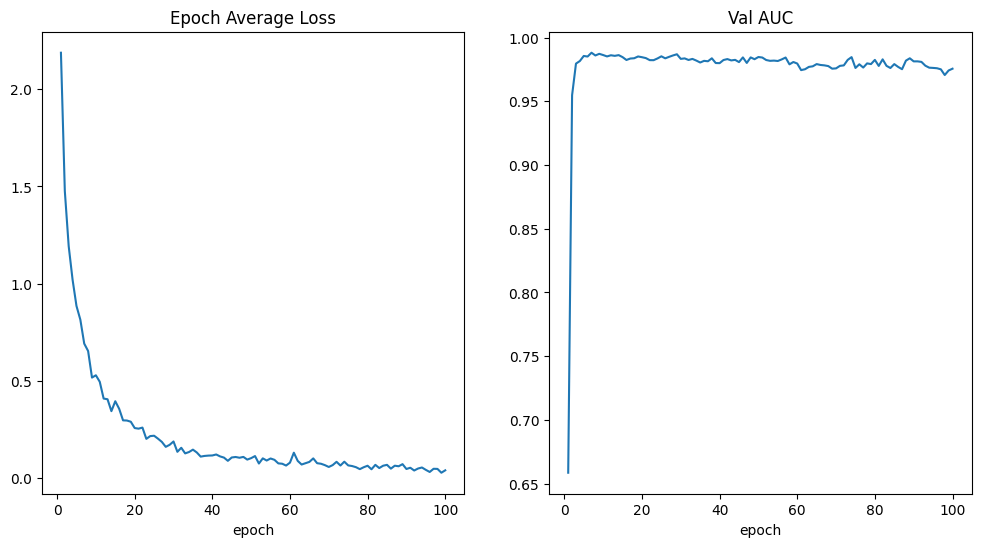

In [52]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [53]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [54]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8312    0.9275    0.8767        69
           1     0.5167    0.4559    0.4844        68
           2     0.5455    0.6087    0.5753        69
           3     0.4699    0.6000    0.5270        65
           4     0.3333    0.2000    0.2500        65
           5     0.7042    0.7576    0.7299        66
           6     0.8947    0.6071    0.7234        28
           7     0.9500    0.9048    0.9268        21
           8     0.9048    0.9048    0.9048        21
           9     0.6406    0.5942    0.6165        69
          10     0.5823    0.6667    0.6216        69

    accuracy                         0.6246       610
   macro avg     0.6703    0.6570    0.6579       610
weighted avg     0.6183    0.6246    0.6163       610



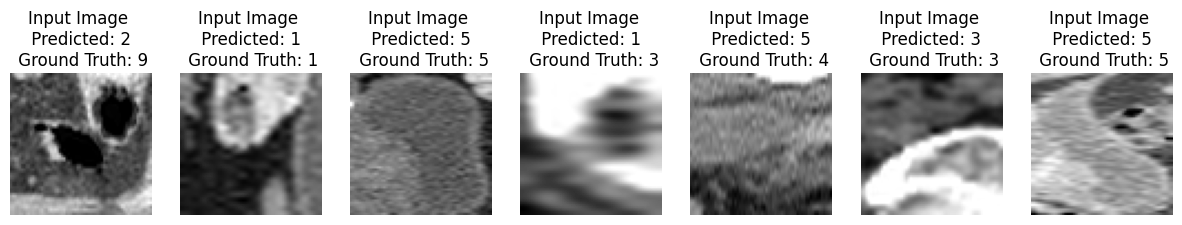

In [55]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, len(images))
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(example_axial[1], example_preds[1], example_labels[1], n=7)

## Unpretrained

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [57]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    batch_iter = tqdm(train_loader, desc="Training Batches", leave=False)
    
    for batch_data in batch_iter:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(axial.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        batch_iter.set_postfix(train_loss=loss.item())
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_axial.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_axial.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.23it/s, train_loss=1.79]
                                                                                  

epoch 1 average loss: 1.9739
1


Epochs:   1%|          | 1/100 [00:07<12:24,  7.52s/it]

saved new best metric model
current epoch: 1 current AUC: 0.5694 current accuracy: 0.0932 best AUC: 0.5694 at epoch: 1
----------
epoch 2/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.51it/s, train_loss=1.21]
                                                                                  

epoch 2 average loss: 1.5586
1


Epochs:   2%|▏         | 2/100 [00:14<12:07,  7.42s/it]

saved new best metric model
current epoch: 2 current AUC: 0.8504 current accuracy: 0.3354 best AUC: 0.8504 at epoch: 2
----------
epoch 3/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.39it/s, train_loss=1.37]
                                                                                  

epoch 3 average loss: 1.3115
1


Epochs:   3%|▎         | 3/100 [00:22<12:01,  7.44s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9585 current accuracy: 0.5714 best AUC: 0.9585 at epoch: 3
----------
epoch 4/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.46it/s, train_loss=1.8]  
                                                                                 

epoch 4 average loss: 1.1748
1


Epochs:   4%|▍         | 4/100 [00:29<11:58,  7.48s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9801 current accuracy: 0.7391 best AUC: 0.9801 at epoch: 4
----------
epoch 5/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.41it/s, train_loss=2.04] 
                                                                                  

epoch 5 average loss: 1.0607
1


Epochs:   5%|▌         | 5/100 [00:37<11:46,  7.44s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9833 current accuracy: 0.7143 best AUC: 0.9833 at epoch: 5
----------
epoch 6/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.52it/s, train_loss=1.16]
                                                                                  

epoch 6 average loss: 0.9512
1


Epochs:   6%|▌         | 6/100 [00:44<11:38,  7.43s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9851 current accuracy: 0.7391 best AUC: 0.9851 at epoch: 6
----------
epoch 7/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.57it/s, train_loss=0.838]
                                                                                   

epoch 7 average loss: 0.8946


Epochs:   7%|▋         | 7/100 [00:51<11:18,  7.30s/it]

1
current epoch: 7 current AUC: 0.9785 current accuracy: 0.6894 best AUC: 0.9851 at epoch: 6
----------
epoch 8/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.59it/s, train_loss=0.919]
                                                                                   

epoch 8 average loss: 0.8335


Epochs:   8%|▊         | 8/100 [00:58<11:04,  7.23s/it]

1
current epoch: 8 current AUC: 0.9844 current accuracy: 0.7764 best AUC: 0.9851 at epoch: 6
----------
epoch 9/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  3.87it/s, train_loss=1.35] 
                                                                                  

epoch 9 average loss: 0.7724


Epochs:   9%|▉         | 9/100 [01:06<10:58,  7.23s/it]

1
current epoch: 9 current AUC: 0.9850 current accuracy: 0.7267 best AUC: 0.9851 at epoch: 6
----------
epoch 10/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.64it/s, train_loss=1.15] 
                                                                                  

epoch 10 average loss: 0.7110
1


Epochs:  10%|█         | 10/100 [01:13<11:01,  7.35s/it]

saved new best metric model
current epoch: 10 current AUC: 0.9884 current accuracy: 0.7888 best AUC: 0.9884 at epoch: 10
----------
epoch 11/100



Training Batches:  97%|█████████▋| 30/31 [00:06<00:00,  4.48it/s, train_loss=0.781]
                                                                                   

epoch 11 average loss: 0.6449
1


Epochs:  11%|█         | 11/100 [01:20<10:46,  7.26s/it]

current epoch: 11 current AUC: 0.9780 current accuracy: 0.7453 best AUC: 0.9884 at epoch: 10
----------
epoch 12/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.15it/s, train_loss=1.14] 
                                                                                  

epoch 12 average loss: 0.6459
1


Epochs:  12%|█▏        | 12/100 [01:28<10:53,  7.43s/it]

current epoch: 12 current AUC: 0.9875 current accuracy: 0.8012 best AUC: 0.9884 at epoch: 10
----------
epoch 13/100



Training Batches:  97%|█████████▋| 30/31 [00:08<00:00,  4.08it/s, train_loss=0.745]
                                                                                   

epoch 13 average loss: 0.5635


Epochs:  13%|█▎        | 13/100 [01:36<11:12,  7.73s/it]

1
current epoch: 13 current AUC: 0.9866 current accuracy: 0.8012 best AUC: 0.9884 at epoch: 10
----------
epoch 14/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.65it/s, train_loss=1.17]
                                                                                  

epoch 14 average loss: 0.5833


Epochs:  14%|█▍        | 14/100 [01:47<12:25,  8.67s/it]

1
current epoch: 14 current AUC: 0.9844 current accuracy: 0.7578 best AUC: 0.9884 at epoch: 10
----------
epoch 15/100



Training Batches:  97%|█████████▋| 30/31 [00:09<00:00,  3.07it/s, train_loss=0.689]
                                                                                   

epoch 15 average loss: 0.5201


Epochs:  15%|█▌        | 15/100 [01:57<12:55,  9.13s/it]

1
current epoch: 15 current AUC: 0.9865 current accuracy: 0.7950 best AUC: 0.9884 at epoch: 10
----------
epoch 16/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.94it/s, train_loss=0.522]
                                                                                   

epoch 16 average loss: 0.4898


Epochs:  16%|█▌        | 16/100 [02:08<13:32,  9.68s/it]

1
current epoch: 16 current AUC: 0.9856 current accuracy: 0.8012 best AUC: 0.9884 at epoch: 10
----------
epoch 17/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  4.42it/s, train_loss=0.219]
                                                                                   

epoch 17 average loss: 0.4562


Epochs:  17%|█▋        | 17/100 [02:19<13:55, 10.07s/it]

1
current epoch: 17 current AUC: 0.9876 current accuracy: 0.7950 best AUC: 0.9884 at epoch: 10
----------
epoch 18/100



Training Batches: 100%|██████████| 31/31 [00:09<00:00,  3.67it/s, train_loss=0.389]
                                                                                   

epoch 18 average loss: 0.4069
1


Epochs:  18%|█▊        | 18/100 [02:29<13:42, 10.03s/it]

current epoch: 18 current AUC: 0.9865 current accuracy: 0.8199 best AUC: 0.9884 at epoch: 10
----------
epoch 19/100



Training Batches:  97%|█████████▋| 30/31 [00:08<00:00,  3.15it/s, train_loss=0.418]
                                                                                   

epoch 19 average loss: 0.3901
1


Epochs:  19%|█▉        | 19/100 [02:39<13:22,  9.91s/it]

saved new best metric model
current epoch: 19 current AUC: 0.9915 current accuracy: 0.8323 best AUC: 0.9915 at epoch: 19
----------
epoch 20/100



Training Batches:  97%|█████████▋| 30/31 [00:10<00:00,  3.51it/s, train_loss=0.644]
                                                                                   

epoch 20 average loss: 0.3557


Epochs:  20%|██        | 20/100 [02:50<13:34, 10.19s/it]

1
current epoch: 20 current AUC: 0.9859 current accuracy: 0.8199 best AUC: 0.9915 at epoch: 19
----------
epoch 21/100



Training Batches: 100%|██████████| 31/31 [00:09<00:00,  3.72it/s, train_loss=0.462]
                                                                                   

epoch 21 average loss: 0.3601


Epochs:  21%|██        | 21/100 [02:59<13:07,  9.97s/it]

1
current epoch: 21 current AUC: 0.9899 current accuracy: 0.8012 best AUC: 0.9915 at epoch: 19
----------
epoch 22/100



Training Batches:  97%|█████████▋| 30/31 [00:10<00:00,  3.82it/s, train_loss=0.537]
                                                                                   

epoch 22 average loss: 0.3348


Epochs:  22%|██▏       | 22/100 [03:10<13:06, 10.09s/it]

1
current epoch: 22 current AUC: 0.9858 current accuracy: 0.7391 best AUC: 0.9915 at epoch: 19
----------
epoch 23/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.49it/s, train_loss=0.218]
                                                                                   

epoch 23 average loss: 0.3471


Epochs:  23%|██▎       | 23/100 [03:20<13:01, 10.15s/it]

1
current epoch: 23 current AUC: 0.9875 current accuracy: 0.8137 best AUC: 0.9915 at epoch: 19
----------
epoch 24/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.64it/s, train_loss=0.385]
                                                                                   

epoch 24 average loss: 0.3039


Epochs:  24%|██▍       | 24/100 [03:31<13:09, 10.38s/it]

1
current epoch: 24 current AUC: 0.9857 current accuracy: 0.8323 best AUC: 0.9915 at epoch: 19
----------
epoch 25/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  2.99it/s, train_loss=0.821]
                                                                                   

epoch 25 average loss: 0.3016
1


Epochs:  25%|██▌       | 25/100 [03:42<13:07, 10.50s/it]

current epoch: 25 current AUC: 0.9837 current accuracy: 0.7826 best AUC: 0.9915 at epoch: 19
----------
epoch 26/100



Training Batches:  97%|█████████▋| 30/31 [00:10<00:00,  2.50it/s, train_loss=0.356]
                                                                                   

epoch 26 average loss: 0.3057
1


Epochs:  26%|██▌       | 26/100 [03:53<13:10, 10.69s/it]

current epoch: 26 current AUC: 0.9880 current accuracy: 0.7826 best AUC: 0.9915 at epoch: 19
----------
epoch 27/100



Training Batches: 100%|██████████| 31/31 [00:09<00:00,  4.18it/s, train_loss=0.714]
                                                                                   

epoch 27 average loss: 0.2922


Epochs:  27%|██▋       | 27/100 [04:03<12:50, 10.55s/it]

1
current epoch: 27 current AUC: 0.9869 current accuracy: 0.7578 best AUC: 0.9915 at epoch: 19
----------
epoch 28/100



Training Batches: 100%|██████████| 31/31 [00:08<00:00,  4.70it/s, train_loss=0.205]
                                                                                   

epoch 28 average loss: 0.2912
1


Epochs:  28%|██▊       | 28/100 [04:12<11:57,  9.97s/it]

current epoch: 28 current AUC: 0.9844 current accuracy: 0.7888 best AUC: 0.9915 at epoch: 19
----------
epoch 29/100



Training Batches: 100%|██████████| 31/31 [00:07<00:00,  5.19it/s, train_loss=0.537]
                                                                                   

epoch 29 average loss: 0.2725
1


Epochs:  29%|██▉       | 29/100 [04:19<10:57,  9.26s/it]

current epoch: 29 current AUC: 0.9848 current accuracy: 0.8137 best AUC: 0.9915 at epoch: 19
----------
epoch 30/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  2.77it/s, train_loss=0.373]
                                                                                   

epoch 30 average loss: 0.2852


Epochs:  30%|███       | 30/100 [04:31<11:31,  9.88s/it]

1
current epoch: 30 current AUC: 0.9796 current accuracy: 0.7267 best AUC: 0.9915 at epoch: 19
----------
epoch 31/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.92it/s, train_loss=0.233]
                                                                                   

epoch 31 average loss: 0.2646


Epochs:  31%|███       | 31/100 [04:41<11:38, 10.12s/it]

1
current epoch: 31 current AUC: 0.9848 current accuracy: 0.7826 best AUC: 0.9915 at epoch: 19
----------
epoch 32/100



Training Batches:  97%|█████████▋| 30/31 [00:10<00:00,  3.27it/s, train_loss=0.0664]
                                                                                    

epoch 32 average loss: 0.2150
1


Epochs:  32%|███▏      | 32/100 [04:52<11:38, 10.26s/it]

current epoch: 32 current AUC: 0.9843 current accuracy: 0.8075 best AUC: 0.9915 at epoch: 19
----------
epoch 33/100



Training Batches:  97%|█████████▋| 30/31 [00:09<00:00,  2.96it/s, train_loss=0.304]
                                                                                   

epoch 33 average loss: 0.2732
1


Epochs:  33%|███▎      | 33/100 [05:01<11:14, 10.06s/it]

current epoch: 33 current AUC: 0.9832 current accuracy: 0.8012 best AUC: 0.9915 at epoch: 19
----------
epoch 34/100



Training Batches:  97%|█████████▋| 30/31 [00:11<00:00,  2.47it/s, train_loss=0.444]
                                                                                   

epoch 34 average loss: 0.2033
1


Epochs:  34%|███▍      | 34/100 [05:14<11:46, 10.70s/it]

current epoch: 34 current AUC: 0.9872 current accuracy: 0.8323 best AUC: 0.9915 at epoch: 19
----------
epoch 35/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.21it/s, train_loss=0.336]
                                                                                   

epoch 35 average loss: 0.2033


Epochs:  35%|███▌      | 35/100 [05:25<11:43, 10.82s/it]

1
current epoch: 35 current AUC: 0.9877 current accuracy: 0.7826 best AUC: 0.9915 at epoch: 19
----------
epoch 36/100



Training Batches: 100%|██████████| 31/31 [00:09<00:00,  4.74it/s, train_loss=0.175]
                                                                                   

epoch 36 average loss: 0.2321


Epochs:  36%|███▌      | 36/100 [05:34<11:06, 10.42s/it]

1
current epoch: 36 current AUC: 0.9856 current accuracy: 0.7950 best AUC: 0.9915 at epoch: 19
----------
epoch 37/100



Training Batches:  97%|█████████▋| 30/31 [00:08<00:00,  3.83it/s, train_loss=0.132]
                                                                                   

epoch 37 average loss: 0.1951
1


Epochs:  37%|███▋      | 37/100 [05:43<10:31, 10.02s/it]

current epoch: 37 current AUC: 0.9872 current accuracy: 0.8012 best AUC: 0.9915 at epoch: 19
----------
epoch 38/100



Training Batches: 100%|██████████| 31/31 [00:09<00:00,  3.95it/s, train_loss=0.656]
                                                                                   

epoch 38 average loss: 0.2123


Epochs:  38%|███▊      | 38/100 [05:53<10:11,  9.87s/it]

1
current epoch: 38 current AUC: 0.9895 current accuracy: 0.8323 best AUC: 0.9915 at epoch: 19
----------
epoch 39/100



Training Batches: 100%|██████████| 31/31 [00:08<00:00,  4.00it/s, train_loss=0.179]
                                                                                   

epoch 39 average loss: 0.2060


Epochs:  39%|███▉      | 39/100 [06:02<09:53,  9.73s/it]

1
current epoch: 39 current AUC: 0.9819 current accuracy: 0.7888 best AUC: 0.9915 at epoch: 19
----------
epoch 40/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.48it/s, train_loss=0.128]
                                                                                   

epoch 40 average loss: 0.2048


Epochs:  40%|████      | 40/100 [06:13<10:11, 10.20s/it]

1
current epoch: 40 current AUC: 0.9836 current accuracy: 0.7950 best AUC: 0.9915 at epoch: 19
----------
epoch 41/100



Training Batches: 100%|██████████| 31/31 [00:11<00:00,  3.40it/s, train_loss=0.392]
                                                                                   

epoch 41 average loss: 0.1913
1


Epochs:  41%|████      | 41/100 [06:25<10:32, 10.72s/it]

current epoch: 41 current AUC: 0.9855 current accuracy: 0.8075 best AUC: 0.9915 at epoch: 19
----------
epoch 42/100



Training Batches:  97%|█████████▋| 30/31 [00:09<00:00,  3.95it/s, train_loss=0.275]
                                                                                   

epoch 42 average loss: 0.1879
1


Epochs:  42%|████▏     | 42/100 [06:35<10:07, 10.47s/it]

current epoch: 42 current AUC: 0.9836 current accuracy: 0.7826 best AUC: 0.9915 at epoch: 19
----------
epoch 43/100



Training Batches: 100%|██████████| 31/31 [00:08<00:00,  3.48it/s, train_loss=0.273]
                                                                                   

epoch 43 average loss: 0.1590


Epochs:  43%|████▎     | 43/100 [06:44<09:33, 10.06s/it]

1
current epoch: 43 current AUC: 0.9874 current accuracy: 0.7826 best AUC: 0.9915 at epoch: 19
----------
epoch 44/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  4.62it/s, train_loss=0.432]
                                                                                   

epoch 44 average loss: 0.1892
1


Epochs:  44%|████▍     | 44/100 [06:55<09:30, 10.19s/it]

current epoch: 44 current AUC: 0.9827 current accuracy: 0.7764 best AUC: 0.9915 at epoch: 19
----------
epoch 45/100



Training Batches:  97%|█████████▋| 30/31 [00:08<00:00,  4.13it/s, train_loss=0.0283]
                                                                                    

epoch 45 average loss: 0.1699
1


Epochs:  45%|████▌     | 45/100 [07:04<09:06,  9.93s/it]

current epoch: 45 current AUC: 0.9816 current accuracy: 0.7950 best AUC: 0.9915 at epoch: 19
----------
epoch 46/100



Training Batches: 100%|██████████| 31/31 [00:09<00:00,  3.87it/s, train_loss=0.455]
                                                                                   

epoch 46 average loss: 0.1854
1


Epochs:  46%|████▌     | 46/100 [07:14<08:53,  9.88s/it]

current epoch: 46 current AUC: 0.9834 current accuracy: 0.7826 best AUC: 0.9915 at epoch: 19
----------
epoch 47/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.60it/s, train_loss=0.208]
                                                                                   

epoch 47 average loss: 0.1774


Epochs:  47%|████▋     | 47/100 [07:25<08:54, 10.08s/it]

1
current epoch: 47 current AUC: 0.9884 current accuracy: 0.8385 best AUC: 0.9915 at epoch: 19
----------
epoch 48/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.98it/s, train_loss=0.156]
                                                                                   

epoch 48 average loss: 0.1538


Epochs:  48%|████▊     | 48/100 [07:36<09:03, 10.44s/it]

1
current epoch: 48 current AUC: 0.9870 current accuracy: 0.8385 best AUC: 0.9915 at epoch: 19
----------
epoch 49/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.80it/s, train_loss=0.152]
                                                                                   

epoch 49 average loss: 0.1402


Epochs:  49%|████▉     | 49/100 [07:46<08:56, 10.51s/it]

1
current epoch: 49 current AUC: 0.9848 current accuracy: 0.8137 best AUC: 0.9915 at epoch: 19
----------
epoch 50/100



Training Batches: 100%|██████████| 31/31 [00:09<00:00,  4.50it/s, train_loss=0.443]
                                                                                   

epoch 50 average loss: 0.1528
1


Epochs:  50%|█████     | 50/100 [07:57<08:40, 10.40s/it]

current epoch: 50 current AUC: 0.9872 current accuracy: 0.8261 best AUC: 0.9915 at epoch: 19
----------
epoch 51/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  2.80it/s, train_loss=0.207]
                                                                                   

epoch 51 average loss: 0.1432


Epochs:  51%|█████     | 51/100 [08:07<08:35, 10.52s/it]

1
current epoch: 51 current AUC: 0.9867 current accuracy: 0.8075 best AUC: 0.9915 at epoch: 19
----------
epoch 52/100



Training Batches:  97%|█████████▋| 30/31 [00:11<00:00,  3.06it/s, train_loss=0.133]
                                                                                   

epoch 52 average loss: 0.1579


Epochs:  52%|█████▏    | 52/100 [08:19<08:35, 10.75s/it]

1
current epoch: 52 current AUC: 0.9850 current accuracy: 0.8075 best AUC: 0.9915 at epoch: 19
----------
epoch 53/100



Training Batches:  97%|█████████▋| 30/31 [00:10<00:00,  2.62it/s, train_loss=0.14]  
                                                                                  

epoch 53 average loss: 0.1235
1


Epochs:  53%|█████▎    | 53/100 [08:30<08:27, 10.81s/it]

current epoch: 53 current AUC: 0.9876 current accuracy: 0.8012 best AUC: 0.9915 at epoch: 19
----------
epoch 54/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.87it/s, train_loss=0.262]
                                                                                   

epoch 54 average loss: 0.1474


Epochs:  54%|█████▍    | 54/100 [08:40<08:16, 10.79s/it]

1
current epoch: 54 current AUC: 0.9863 current accuracy: 0.8261 best AUC: 0.9915 at epoch: 19
----------
epoch 55/100



Training Batches: 100%|██████████| 31/31 [00:09<00:00,  3.60it/s, train_loss=0.114]
                                                                                   

epoch 55 average loss: 0.1433


Epochs:  55%|█████▌    | 55/100 [08:50<07:53, 10.52s/it]

1
current epoch: 55 current AUC: 0.9870 current accuracy: 0.8385 best AUC: 0.9915 at epoch: 19
----------
epoch 56/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.44it/s, train_loss=0.249]
                                                                                   

epoch 56 average loss: 0.1305
1


Epochs:  56%|█████▌    | 56/100 [09:01<07:47, 10.63s/it]

current epoch: 56 current AUC: 0.9901 current accuracy: 0.8571 best AUC: 0.9915 at epoch: 19
----------
epoch 57/100



Training Batches: 100%|██████████| 31/31 [00:09<00:00,  3.81it/s, train_loss=0.392]
                                                                                   

epoch 57 average loss: 0.1445


Epochs:  57%|█████▋    | 57/100 [09:11<07:25, 10.37s/it]

1
current epoch: 57 current AUC: 0.9874 current accuracy: 0.8323 best AUC: 0.9915 at epoch: 19
----------
epoch 58/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.84it/s, train_loss=0.514]
                                                                                   

epoch 58 average loss: 0.1328


Epochs:  58%|█████▊    | 58/100 [09:21<07:16, 10.39s/it]

1
current epoch: 58 current AUC: 0.9875 current accuracy: 0.8199 best AUC: 0.9915 at epoch: 19
----------
epoch 59/100



Training Batches:  97%|█████████▋| 30/31 [00:10<00:00,  3.26it/s, train_loss=0.325] 
                                                                                   

epoch 59 average loss: 0.1389


Epochs:  59%|█████▉    | 59/100 [09:32<07:07, 10.42s/it]

1
current epoch: 59 current AUC: 0.9881 current accuracy: 0.8261 best AUC: 0.9915 at epoch: 19
----------
epoch 60/100



Training Batches:  97%|█████████▋| 30/31 [00:09<00:00,  3.36it/s, train_loss=0.195]
                                                                                   

epoch 60 average loss: 0.1453
1


Epochs:  60%|██████    | 60/100 [09:42<06:47, 10.20s/it]

current epoch: 60 current AUC: 0.9854 current accuracy: 0.8261 best AUC: 0.9915 at epoch: 19
----------
epoch 61/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.86it/s, train_loss=0.309]
                                                                                   

epoch 61 average loss: 0.1164


Epochs:  61%|██████    | 61/100 [09:52<06:41, 10.30s/it]

1
current epoch: 61 current AUC: 0.9861 current accuracy: 0.8137 best AUC: 0.9915 at epoch: 19
----------
epoch 62/100



Training Batches:  97%|█████████▋| 30/31 [00:10<00:00,  2.70it/s, train_loss=0.0975]
                                                                                    

epoch 62 average loss: 0.1357


Epochs:  62%|██████▏   | 62/100 [10:03<06:35, 10.41s/it]

1
current epoch: 62 current AUC: 0.9901 current accuracy: 0.8509 best AUC: 0.9915 at epoch: 19
----------
epoch 63/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.96it/s, train_loss=0.59]
                                                                                  

epoch 63 average loss: 0.1588
1


Epochs:  63%|██████▎   | 63/100 [10:13<06:28, 10.50s/it]

current epoch: 63 current AUC: 0.9881 current accuracy: 0.8199 best AUC: 0.9915 at epoch: 19
----------
epoch 64/100



Training Batches: 100%|██████████| 31/31 [00:11<00:00,  3.11it/s, train_loss=0.0354]
                                                                                    

epoch 64 average loss: 0.1181


Epochs:  64%|██████▍   | 64/100 [10:25<06:29, 10.82s/it]

1
current epoch: 64 current AUC: 0.9806 current accuracy: 0.8261 best AUC: 0.9915 at epoch: 19
----------
epoch 65/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  2.96it/s, train_loss=0.0691]
                                                                                    

epoch 65 average loss: 0.1107
1


Epochs:  65%|██████▌   | 65/100 [10:36<06:22, 10.91s/it]

current epoch: 65 current AUC: 0.9863 current accuracy: 0.8075 best AUC: 0.9915 at epoch: 19
----------
epoch 66/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.10it/s, train_loss=0.307] 
                                                                                   

epoch 66 average loss: 0.1078
1


Epochs:  66%|██████▌   | 66/100 [10:44<05:42, 10.06s/it]

current epoch: 66 current AUC: 0.9837 current accuracy: 0.8075 best AUC: 0.9915 at epoch: 19
----------
epoch 67/100



Training Batches:  97%|█████████▋| 30/31 [00:08<00:00,  3.39it/s, train_loss=0.219]
                                                                                   

epoch 67 average loss: 0.1181
1


Epochs:  67%|██████▋   | 67/100 [10:53<05:21,  9.76s/it]

current epoch: 67 current AUC: 0.9834 current accuracy: 0.8199 best AUC: 0.9915 at epoch: 19
----------
epoch 68/100



Training Batches: 100%|██████████| 31/31 [00:08<00:00,  3.53it/s, train_loss=0.161]
                                                                                   

epoch 68 average loss: 0.1058
1


Epochs:  68%|██████▊   | 68/100 [11:02<05:05,  9.55s/it]

current epoch: 68 current AUC: 0.9839 current accuracy: 0.7888 best AUC: 0.9915 at epoch: 19
----------
epoch 69/100



Training Batches:  97%|█████████▋| 30/31 [00:08<00:00,  3.45it/s, train_loss=0.128] 
                                                                                   

epoch 69 average loss: 0.1100


Epochs:  69%|██████▉   | 69/100 [11:11<04:49,  9.32s/it]

1
current epoch: 69 current AUC: 0.9835 current accuracy: 0.8137 best AUC: 0.9915 at epoch: 19
----------
epoch 70/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.32it/s, train_loss=0.0499]
                                                                                    

epoch 70 average loss: 0.0830


Epochs:  70%|███████   | 70/100 [11:22<04:50,  9.68s/it]

1
current epoch: 70 current AUC: 0.9824 current accuracy: 0.7764 best AUC: 0.9915 at epoch: 19
----------
epoch 71/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  2.91it/s, train_loss=0.337]
                                                                                   

epoch 71 average loss: 0.0958


Epochs:  71%|███████   | 71/100 [11:33<04:53, 10.11s/it]

1
current epoch: 71 current AUC: 0.9845 current accuracy: 0.8012 best AUC: 0.9915 at epoch: 19
----------
epoch 72/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.12it/s, train_loss=0.145]
                                                                                   

epoch 72 average loss: 0.1204
1


Epochs:  72%|███████▏  | 72/100 [11:44<04:54, 10.51s/it]

current epoch: 72 current AUC: 0.9852 current accuracy: 0.8012 best AUC: 0.9915 at epoch: 19
----------
epoch 73/100



Training Batches:  97%|█████████▋| 30/31 [00:09<00:00,  3.81it/s, train_loss=0.475]
                                                                                   

epoch 73 average loss: 0.0953
1


Epochs:  73%|███████▎  | 73/100 [11:54<04:40, 10.37s/it]

current epoch: 73 current AUC: 0.9852 current accuracy: 0.7950 best AUC: 0.9915 at epoch: 19
----------
epoch 74/100



Training Batches:  97%|█████████▋| 30/31 [00:09<00:00,  3.25it/s, train_loss=0.122] 
                                                                                   

epoch 74 average loss: 0.1297


Epochs:  74%|███████▍  | 74/100 [12:04<04:22, 10.08s/it]

1
current epoch: 74 current AUC: 0.9860 current accuracy: 0.8261 best AUC: 0.9915 at epoch: 19
----------
epoch 75/100



Training Batches: 100%|██████████| 31/31 [00:12<00:00,  3.83it/s, train_loss=0.135]
                                                                                   

epoch 75 average loss: 0.1015


Epochs:  75%|███████▌  | 75/100 [12:16<04:28, 10.75s/it]

1
current epoch: 75 current AUC: 0.9861 current accuracy: 0.8012 best AUC: 0.9915 at epoch: 19
----------
epoch 76/100



Training Batches:  97%|█████████▋| 30/31 [00:10<00:00,  3.19it/s, train_loss=0.0621]
                                                                                    

epoch 76 average loss: 0.0896


Epochs:  76%|███████▌  | 76/100 [12:26<04:15, 10.67s/it]

1
current epoch: 76 current AUC: 0.9862 current accuracy: 0.8075 best AUC: 0.9915 at epoch: 19
----------
epoch 77/100



Training Batches: 100%|██████████| 31/31 [00:11<00:00,  4.31it/s, train_loss=0.0386]
                                                                                    

epoch 77 average loss: 0.0975


Epochs:  77%|███████▋  | 77/100 [12:38<04:10, 10.87s/it]

1
current epoch: 77 current AUC: 0.9849 current accuracy: 0.7888 best AUC: 0.9915 at epoch: 19
----------
epoch 78/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.69it/s, train_loss=0.151]
                                                                                   

epoch 78 average loss: 0.0872


Epochs:  78%|███████▊  | 78/100 [12:49<04:03, 11.05s/it]

1
current epoch: 78 current AUC: 0.9855 current accuracy: 0.8137 best AUC: 0.9915 at epoch: 19
----------
epoch 79/100



Training Batches:  97%|█████████▋| 30/31 [00:10<00:00,  2.55it/s, train_loss=0.19]  
                                                                                  

epoch 79 average loss: 0.0833


Epochs:  79%|███████▉  | 79/100 [13:00<03:50, 10.97s/it]

1
current epoch: 79 current AUC: 0.9824 current accuracy: 0.7888 best AUC: 0.9915 at epoch: 19
----------
epoch 80/100



Training Batches:  97%|█████████▋| 30/31 [00:09<00:00,  3.64it/s, train_loss=0.0495]
                                                                                    

epoch 80 average loss: 0.0960


Epochs:  80%|████████  | 80/100 [13:10<03:31, 10.56s/it]

1
current epoch: 80 current AUC: 0.9846 current accuracy: 0.7888 best AUC: 0.9915 at epoch: 19
----------
epoch 81/100



Training Batches:  97%|█████████▋| 30/31 [00:08<00:00,  3.78it/s, train_loss=0.132]
                                                                                   

epoch 81 average loss: 0.0942
1


Epochs:  81%|████████  | 81/100 [13:18<03:10, 10.00s/it]

current epoch: 81 current AUC: 0.9846 current accuracy: 0.8199 best AUC: 0.9915 at epoch: 19
----------
epoch 82/100



Training Batches:  97%|█████████▋| 30/31 [00:08<00:00,  3.49it/s, train_loss=0.0267]
                                                                                    

epoch 82 average loss: 0.0929
1


Epochs:  82%|████████▏ | 82/100 [13:27<02:54,  9.72s/it]

current epoch: 82 current AUC: 0.9845 current accuracy: 0.8012 best AUC: 0.9915 at epoch: 19
----------
epoch 83/100



Training Batches: 100%|██████████| 31/31 [00:08<00:00,  4.26it/s, train_loss=0.104]
                                                                                   

epoch 83 average loss: 0.0840
1


Epochs:  83%|████████▎ | 83/100 [13:36<02:41,  9.49s/it]

current epoch: 83 current AUC: 0.9846 current accuracy: 0.8012 best AUC: 0.9915 at epoch: 19
----------
epoch 84/100



Training Batches: 100%|██████████| 31/31 [00:08<00:00,  4.13it/s, train_loss=0.417]
                                                                                   

epoch 84 average loss: 0.1023
1


Epochs:  84%|████████▍ | 84/100 [13:45<02:28,  9.25s/it]

current epoch: 84 current AUC: 0.9863 current accuracy: 0.8323 best AUC: 0.9915 at epoch: 19
----------
epoch 85/100



Training Batches:  97%|█████████▋| 30/31 [00:12<00:00,  3.75it/s, train_loss=0.0755]
                                                                                    

epoch 85 average loss: 0.0799
1


Epochs:  85%|████████▌ | 85/100 [13:57<02:32, 10.15s/it]

current epoch: 85 current AUC: 0.9862 current accuracy: 0.8385 best AUC: 0.9915 at epoch: 19
----------
epoch 86/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  3.98it/s, train_loss=0.364] 
                                                                                   

epoch 86 average loss: 0.0868
1


Epochs:  86%|████████▌ | 86/100 [14:05<02:11,  9.38s/it]

current epoch: 86 current AUC: 0.9857 current accuracy: 0.8199 best AUC: 0.9915 at epoch: 19
----------
epoch 87/100



Training Batches: 100%|██████████| 31/31 [00:08<00:00,  4.87it/s, train_loss=0.288]
                                                                                   

epoch 87 average loss: 0.0910


Epochs:  87%|████████▋ | 87/100 [14:14<02:00,  9.25s/it]

1
current epoch: 87 current AUC: 0.9877 current accuracy: 0.8199 best AUC: 0.9915 at epoch: 19
----------
epoch 88/100



Training Batches: 100%|██████████| 31/31 [00:09<00:00,  4.38it/s, train_loss=0.0839]
                                                                                    

epoch 88 average loss: 0.0791


Epochs:  88%|████████▊ | 88/100 [14:23<01:52,  9.36s/it]

1
current epoch: 88 current AUC: 0.9827 current accuracy: 0.7950 best AUC: 0.9915 at epoch: 19
----------
epoch 89/100



Training Batches: 100%|██████████| 31/31 [00:07<00:00,  4.00it/s, train_loss=0.215]
                                                                                   

epoch 89 average loss: 0.0797
1


Epochs:  89%|████████▉ | 89/100 [14:31<01:38,  8.94s/it]

current epoch: 89 current AUC: 0.9792 current accuracy: 0.7888 best AUC: 0.9915 at epoch: 19
----------
epoch 90/100



Training Batches:  97%|█████████▋| 30/31 [00:08<00:00,  3.12it/s, train_loss=0.124] 
                                                                                   

epoch 90 average loss: 0.0998
1


Epochs:  90%|█████████ | 90/100 [14:40<01:27,  8.79s/it]

current epoch: 90 current AUC: 0.9809 current accuracy: 0.7826 best AUC: 0.9915 at epoch: 19
----------
epoch 91/100



Training Batches: 100%|██████████| 31/31 [00:10<00:00,  3.71it/s, train_loss=0.0267]
                                                                                    

epoch 91 average loss: 0.0864


Epochs:  91%|█████████ | 91/100 [14:50<01:23,  9.31s/it]

1
current epoch: 91 current AUC: 0.9849 current accuracy: 0.8199 best AUC: 0.9915 at epoch: 19
----------
epoch 92/100



Training Batches:  97%|█████████▋| 30/31 [00:10<00:00,  3.00it/s, train_loss=0.0735]
                                                                                    

epoch 92 average loss: 0.0710


Epochs:  92%|█████████▏| 92/100 [15:01<01:17,  9.66s/it]

1
current epoch: 92 current AUC: 0.9824 current accuracy: 0.8075 best AUC: 0.9915 at epoch: 19
----------
epoch 93/100



Training Batches:  97%|█████████▋| 30/31 [00:08<00:00,  3.09it/s, train_loss=0.0151]
                                                                                    

epoch 93 average loss: 0.0707
1


Epochs:  93%|█████████▎| 93/100 [15:10<01:05,  9.39s/it]

current epoch: 93 current AUC: 0.9839 current accuracy: 0.8012 best AUC: 0.9915 at epoch: 19
----------
epoch 94/100



Training Batches:  97%|█████████▋| 30/31 [00:08<00:00,  3.48it/s, train_loss=0.0171]
                                                                                    

epoch 94 average loss: 0.0797
1


Epochs:  94%|█████████▍| 94/100 [15:19<00:55,  9.29s/it]

current epoch: 94 current AUC: 0.9871 current accuracy: 0.8323 best AUC: 0.9915 at epoch: 19
----------
epoch 95/100



Training Batches: 100%|██████████| 31/31 [00:09<00:00,  3.87it/s, train_loss=0.0179]
                                                                                    

epoch 95 average loss: 0.0864


Epochs:  95%|█████████▌| 95/100 [15:28<00:47,  9.43s/it]

1
current epoch: 95 current AUC: 0.9847 current accuracy: 0.8137 best AUC: 0.9915 at epoch: 19
----------
epoch 96/100



Training Batches: 100%|██████████| 31/31 [00:09<00:00,  4.03it/s, train_loss=0.593]
                                                                                   

epoch 96 average loss: 0.0763
1


Epochs:  96%|█████████▌| 96/100 [15:38<00:37,  9.43s/it]

current epoch: 96 current AUC: 0.9837 current accuracy: 0.8075 best AUC: 0.9915 at epoch: 19
----------
epoch 97/100



Training Batches: 100%|██████████| 31/31 [00:09<00:00,  3.78it/s, train_loss=0.122]
                                                                                   

epoch 97 average loss: 0.0812
1


Epochs:  97%|█████████▋| 97/100 [15:47<00:28,  9.42s/it]

current epoch: 97 current AUC: 0.9865 current accuracy: 0.8447 best AUC: 0.9915 at epoch: 19
----------
epoch 98/100



Training Batches:  97%|█████████▋| 30/31 [00:09<00:00,  3.85it/s, train_loss=0.368] 
                                                                                   

epoch 98 average loss: 0.0890


Epochs:  98%|█████████▊| 98/100 [15:57<00:18,  9.43s/it]

1
current epoch: 98 current AUC: 0.9848 current accuracy: 0.8323 best AUC: 0.9915 at epoch: 19
----------
epoch 99/100



Training Batches: 100%|██████████| 31/31 [00:08<00:00,  4.11it/s, train_loss=0.0316]
                                                                                    

epoch 99 average loss: 0.1064
1


Epochs:  99%|█████████▉| 99/100 [16:05<00:09,  9.14s/it]

current epoch: 99 current AUC: 0.9839 current accuracy: 0.7950 best AUC: 0.9915 at epoch: 19
----------
epoch 100/100



Training Batches:  97%|█████████▋| 30/31 [00:07<00:00,  4.13it/s, train_loss=0.12]  
                                                                                  

epoch 100 average loss: 0.0876
1


Epochs: 100%|██████████| 100/100 [16:13<00:00,  9.73s/it]

current epoch: 100 current AUC: 0.9838 current accuracy: 0.8199 best AUC: 0.9915 at epoch: 19
train completed, best_metric: 0.9915 at epoch: 19


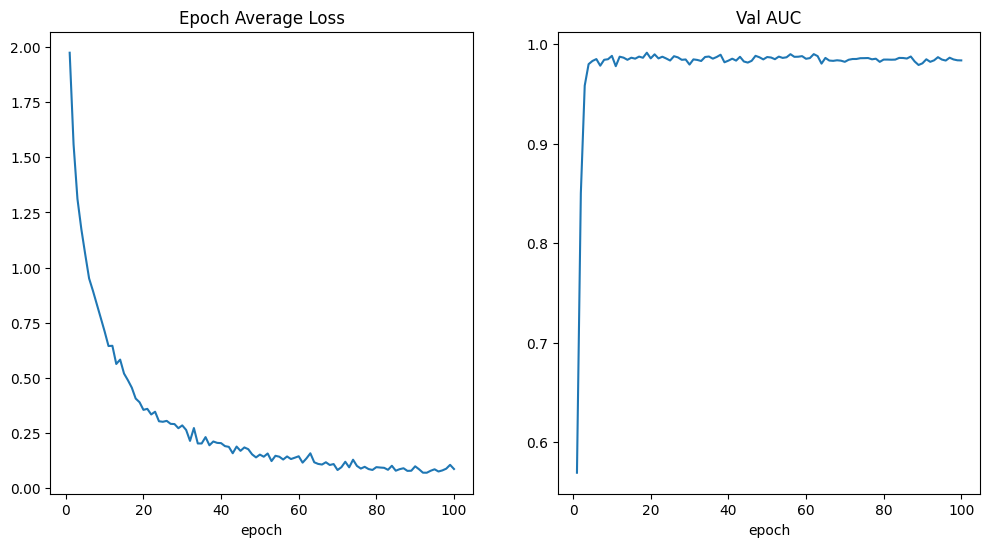

In [58]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [59]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [60]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8451    0.8696    0.8571        69
           1     0.6800    0.5000    0.5763        68
           2     0.6406    0.5942    0.6165        69
           3     0.4242    0.2154    0.2857        65
           4     0.4773    0.6462    0.5490        65
           5     0.8070    0.6970    0.7480        66
           6     0.7857    0.7857    0.7857        28
           7     0.8077    1.0000    0.8936        21
           8     1.0000    0.8095    0.8947        21
           9     0.5098    0.7536    0.6082        69
          10     0.5541    0.5942    0.5734        69

    accuracy                         0.6393       610
   macro avg     0.6847    0.6787    0.6717       610
weighted avg     0.6459    0.6393    0.6321       610



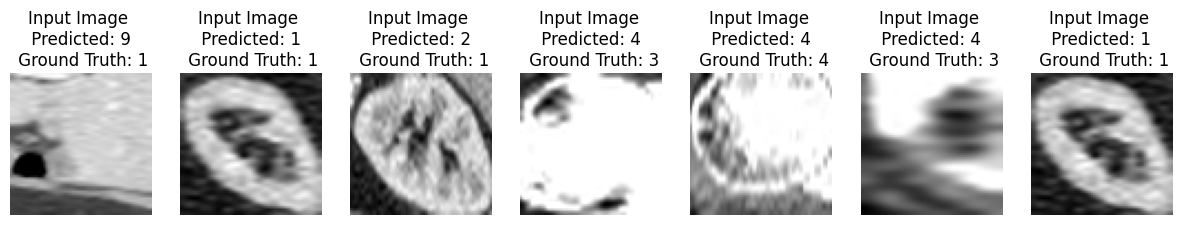

In [61]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, len(images))
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(example_axial[1], example_preds[1], example_labels[1], n=7)

# Coronal and sagittal parts

## Training cycle for the coronal part

## Pretrained

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [65]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    # batch_iter = tqdm(train_loader, desc="Training Batches", leave=False)
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        batch_iter.set_postfix(train_loss=loss.item())
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100
epoch 1 average loss: 2.1583
1


Epochs:   1%|          | 1/100 [00:08<14:10,  8.59s/it]

saved new best metric model
current epoch: 1 current AUC: 0.5843 current accuracy: 0.1304 best AUC: 0.5843 at epoch: 1
----------
epoch 2/100
epoch 2 average loss: 1.3728
1


Epochs:   2%|▏         | 2/100 [00:16<13:35,  8.33s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9624 current accuracy: 0.6894 best AUC: 0.9624 at epoch: 2
----------
epoch 3/100
epoch 3 average loss: 1.0205
1


Epochs:   3%|▎         | 3/100 [00:25<13:59,  8.65s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9831 current accuracy: 0.7578 best AUC: 0.9831 at epoch: 3
----------
epoch 4/100
epoch 4 average loss: 0.8984
1


Epochs:   4%|▍         | 4/100 [00:35<14:27,  9.04s/it]

saved new best metric model
current epoch: 4 current AUC: 0.9914 current accuracy: 0.8447 best AUC: 0.9914 at epoch: 4
----------
epoch 5/100
epoch 5 average loss: 0.7866


Epochs:   5%|▌         | 5/100 [00:43<14:02,  8.87s/it]

1
current epoch: 5 current AUC: 0.9835 current accuracy: 0.7888 best AUC: 0.9914 at epoch: 4
----------
epoch 6/100
epoch 6 average loss: 0.6534


Epochs:   6%|▌         | 6/100 [00:52<13:26,  8.58s/it]

1
current epoch: 6 current AUC: 0.9832 current accuracy: 0.8012 best AUC: 0.9914 at epoch: 4
----------
epoch 7/100
epoch 7 average loss: 0.5515
1


Epochs:   7%|▋         | 7/100 [01:02<14:12,  9.17s/it]

current epoch: 7 current AUC: 0.9846 current accuracy: 0.8323 best AUC: 0.9914 at epoch: 4
----------
epoch 8/100
epoch 8 average loss: 0.5430


Epochs:   8%|▊         | 8/100 [01:10<13:19,  8.69s/it]

1
current epoch: 8 current AUC: 0.9884 current accuracy: 0.7702 best AUC: 0.9914 at epoch: 4
----------
epoch 9/100
epoch 9 average loss: 0.4979


Epochs:   9%|▉         | 9/100 [01:19<13:40,  9.01s/it]

1
current epoch: 9 current AUC: 0.9885 current accuracy: 0.8137 best AUC: 0.9914 at epoch: 4
----------
epoch 10/100
epoch 10 average loss: 0.4579
1


Epochs:  10%|█         | 10/100 [01:29<14:01,  9.35s/it]

current epoch: 10 current AUC: 0.9911 current accuracy: 0.8385 best AUC: 0.9914 at epoch: 4
----------
epoch 11/100
epoch 11 average loss: 0.3834


Epochs:  11%|█         | 11/100 [01:40<14:38,  9.87s/it]

1
current epoch: 11 current AUC: 0.9909 current accuracy: 0.8571 best AUC: 0.9914 at epoch: 4
----------
epoch 12/100
epoch 12 average loss: 0.3740


Epochs:  12%|█▏        | 12/100 [01:52<15:26, 10.52s/it]

1
current epoch: 12 current AUC: 0.9892 current accuracy: 0.8137 best AUC: 0.9914 at epoch: 4
----------
epoch 13/100
epoch 13 average loss: 0.3484


Epochs:  13%|█▎        | 13/100 [02:03<15:06, 10.42s/it]

1
current epoch: 13 current AUC: 0.9914 current accuracy: 0.8758 best AUC: 0.9914 at epoch: 4
----------
epoch 14/100
epoch 14 average loss: 0.3346


Epochs:  14%|█▍        | 14/100 [02:12<14:40, 10.24s/it]

1
current epoch: 14 current AUC: 0.9883 current accuracy: 0.8261 best AUC: 0.9914 at epoch: 4
----------
epoch 15/100
epoch 15 average loss: 0.2827


Epochs:  15%|█▌        | 15/100 [02:21<13:41,  9.67s/it]

1
current epoch: 15 current AUC: 0.9878 current accuracy: 0.7888 best AUC: 0.9914 at epoch: 4
----------
epoch 16/100
epoch 16 average loss: 0.3010
1


Epochs:  16%|█▌        | 16/100 [02:30<13:13,  9.45s/it]

current epoch: 16 current AUC: 0.9870 current accuracy: 0.8261 best AUC: 0.9914 at epoch: 4
----------
epoch 17/100
epoch 17 average loss: 0.2389
1


Epochs:  17%|█▋        | 17/100 [02:39<13:05,  9.46s/it]

current epoch: 17 current AUC: 0.9901 current accuracy: 0.8447 best AUC: 0.9914 at epoch: 4
----------
epoch 18/100
epoch 18 average loss: 0.2393


Epochs:  18%|█▊        | 18/100 [02:49<13:06,  9.59s/it]

1
current epoch: 18 current AUC: 0.9838 current accuracy: 0.8137 best AUC: 0.9914 at epoch: 4
----------
epoch 19/100
epoch 19 average loss: 0.2029


Epochs:  19%|█▉        | 19/100 [02:57<12:13,  9.06s/it]

1
current epoch: 19 current AUC: 0.9914 current accuracy: 0.8820 best AUC: 0.9914 at epoch: 4
----------
epoch 20/100
epoch 20 average loss: 0.1938
1


Epochs:  20%|██        | 20/100 [03:06<12:10,  9.14s/it]

saved new best metric model
current epoch: 20 current AUC: 0.9929 current accuracy: 0.8944 best AUC: 0.9929 at epoch: 20
----------
epoch 21/100
epoch 21 average loss: 0.2103


Epochs:  21%|██        | 21/100 [03:15<11:43,  8.91s/it]

1
current epoch: 21 current AUC: 0.9909 current accuracy: 0.8571 best AUC: 0.9929 at epoch: 20
----------
epoch 22/100
epoch 22 average loss: 0.1776


Epochs:  22%|██▏       | 22/100 [03:24<11:55,  9.17s/it]

1
current epoch: 22 current AUC: 0.9887 current accuracy: 0.8199 best AUC: 0.9929 at epoch: 20
----------
epoch 23/100
epoch 23 average loss: 0.1800


Epochs:  23%|██▎       | 23/100 [03:32<11:20,  8.83s/it]

1
current epoch: 23 current AUC: 0.9905 current accuracy: 0.8385 best AUC: 0.9929 at epoch: 20
----------
epoch 24/100
epoch 24 average loss: 0.1511


Epochs:  24%|██▍       | 24/100 [03:41<10:56,  8.64s/it]

1
current epoch: 24 current AUC: 0.9923 current accuracy: 0.8385 best AUC: 0.9929 at epoch: 20
----------
epoch 25/100
epoch 25 average loss: 0.1386
1


Epochs:  25%|██▌       | 25/100 [03:49<10:50,  8.67s/it]

saved new best metric model
current epoch: 25 current AUC: 0.9939 current accuracy: 0.9006 best AUC: 0.9939 at epoch: 25
----------
epoch 26/100
epoch 26 average loss: 0.1216


Epochs:  26%|██▌       | 26/100 [03:57<10:18,  8.35s/it]

1
current epoch: 26 current AUC: 0.9929 current accuracy: 0.8758 best AUC: 0.9939 at epoch: 25
----------
epoch 27/100
epoch 27 average loss: 0.1361
1


Epochs:  27%|██▋       | 27/100 [04:05<10:06,  8.31s/it]

current epoch: 27 current AUC: 0.9858 current accuracy: 0.8385 best AUC: 0.9939 at epoch: 25
----------
epoch 28/100
epoch 28 average loss: 0.1312
1


Epochs:  28%|██▊       | 28/100 [04:15<10:38,  8.87s/it]

saved new best metric model
current epoch: 28 current AUC: 0.9962 current accuracy: 0.8944 best AUC: 0.9962 at epoch: 28
----------
epoch 29/100
epoch 29 average loss: 0.1420


Epochs:  29%|██▉       | 29/100 [04:25<10:41,  9.03s/it]

1
current epoch: 29 current AUC: 0.9809 current accuracy: 0.8571 best AUC: 0.9962 at epoch: 28
----------
epoch 30/100
epoch 30 average loss: 0.1184


Epochs:  30%|███       | 30/100 [04:34<10:39,  9.13s/it]

1
current epoch: 30 current AUC: 0.9845 current accuracy: 0.8571 best AUC: 0.9962 at epoch: 28
----------
epoch 31/100
epoch 31 average loss: 0.1389


Epochs:  31%|███       | 31/100 [04:43<10:32,  9.17s/it]

1
current epoch: 31 current AUC: 0.9889 current accuracy: 0.8820 best AUC: 0.9962 at epoch: 28
----------
epoch 32/100
epoch 32 average loss: 0.1255


Epochs:  32%|███▏      | 32/100 [04:53<10:31,  9.29s/it]

1
current epoch: 32 current AUC: 0.9848 current accuracy: 0.8012 best AUC: 0.9962 at epoch: 28
----------
epoch 33/100
epoch 33 average loss: 0.1306


Epochs:  33%|███▎      | 33/100 [05:03<10:28,  9.39s/it]

1
current epoch: 33 current AUC: 0.9901 current accuracy: 0.8509 best AUC: 0.9962 at epoch: 28
----------
epoch 34/100
epoch 34 average loss: 0.1011


Epochs:  34%|███▍      | 34/100 [05:13<10:38,  9.68s/it]

1
current epoch: 34 current AUC: 0.9885 current accuracy: 0.8634 best AUC: 0.9962 at epoch: 28
----------
epoch 35/100
epoch 35 average loss: 0.1131


Epochs:  35%|███▌      | 35/100 [05:26<11:36, 10.72s/it]

1
current epoch: 35 current AUC: 0.9886 current accuracy: 0.8323 best AUC: 0.9962 at epoch: 28
----------
epoch 36/100
epoch 36 average loss: 0.0989


Epochs:  36%|███▌      | 36/100 [05:37<11:20, 10.64s/it]

1
current epoch: 36 current AUC: 0.9898 current accuracy: 0.8634 best AUC: 0.9962 at epoch: 28
----------
epoch 37/100
epoch 37 average loss: 0.0808


Epochs:  37%|███▋      | 37/100 [05:47<11:14, 10.70s/it]

1
current epoch: 37 current AUC: 0.9909 current accuracy: 0.8634 best AUC: 0.9962 at epoch: 28
----------
epoch 38/100
epoch 38 average loss: 0.0954


Epochs:  38%|███▊      | 38/100 [05:58<10:58, 10.62s/it]

1
current epoch: 38 current AUC: 0.9884 current accuracy: 0.8571 best AUC: 0.9962 at epoch: 28
----------
epoch 39/100
epoch 39 average loss: 0.1231


Epochs:  39%|███▉      | 39/100 [06:09<10:58, 10.80s/it]

1
current epoch: 39 current AUC: 0.9948 current accuracy: 0.8882 best AUC: 0.9962 at epoch: 28
----------
epoch 40/100
epoch 40 average loss: 0.1219
1


Epochs:  40%|████      | 40/100 [06:20<10:57, 10.96s/it]

current epoch: 40 current AUC: 0.9932 current accuracy: 0.8820 best AUC: 0.9962 at epoch: 28
----------
epoch 41/100
epoch 41 average loss: 0.1100


Epochs:  41%|████      | 41/100 [06:31<10:38, 10.82s/it]

1
current epoch: 41 current AUC: 0.9918 current accuracy: 0.8634 best AUC: 0.9962 at epoch: 28
----------
epoch 42/100
epoch 42 average loss: 0.0825


Epochs:  42%|████▏     | 42/100 [06:41<10:19, 10.68s/it]

1
current epoch: 42 current AUC: 0.9907 current accuracy: 0.8820 best AUC: 0.9962 at epoch: 28
----------
epoch 43/100
epoch 43 average loss: 0.0907


Epochs:  43%|████▎     | 43/100 [06:54<10:38, 11.20s/it]

1
current epoch: 43 current AUC: 0.9843 current accuracy: 0.8261 best AUC: 0.9962 at epoch: 28
----------
epoch 44/100
epoch 44 average loss: 0.0742


Epochs:  44%|████▍     | 44/100 [07:03<09:58, 10.70s/it]

1
current epoch: 44 current AUC: 0.9934 current accuracy: 0.8882 best AUC: 0.9962 at epoch: 28
----------
epoch 45/100
epoch 45 average loss: 0.0677


Epochs:  45%|████▌     | 45/100 [07:14<09:42, 10.59s/it]

1
current epoch: 45 current AUC: 0.9898 current accuracy: 0.8758 best AUC: 0.9962 at epoch: 28
----------
epoch 46/100
epoch 46 average loss: 0.0727


Epochs:  46%|████▌     | 46/100 [07:24<09:24, 10.46s/it]

1
current epoch: 46 current AUC: 0.9889 current accuracy: 0.8385 best AUC: 0.9962 at epoch: 28
----------
epoch 47/100
epoch 47 average loss: 0.0622


Epochs:  47%|████▋     | 47/100 [07:35<09:31, 10.78s/it]

1
current epoch: 47 current AUC: 0.9912 current accuracy: 0.8696 best AUC: 0.9962 at epoch: 28
----------
epoch 48/100
epoch 48 average loss: 0.0650


Epochs:  48%|████▊     | 48/100 [07:46<09:23, 10.83s/it]

1
current epoch: 48 current AUC: 0.9884 current accuracy: 0.8447 best AUC: 0.9962 at epoch: 28
----------
epoch 49/100
epoch 49 average loss: 0.0723


Epochs:  49%|████▉     | 49/100 [07:58<09:29, 11.16s/it]

1
current epoch: 49 current AUC: 0.9876 current accuracy: 0.8385 best AUC: 0.9962 at epoch: 28
----------
epoch 50/100
epoch 50 average loss: 0.0621


Epochs:  50%|█████     | 50/100 [08:10<09:22, 11.24s/it]

1
current epoch: 50 current AUC: 0.9910 current accuracy: 0.8509 best AUC: 0.9962 at epoch: 28
----------
epoch 51/100
epoch 51 average loss: 0.0658


Epochs:  51%|█████     | 51/100 [08:21<09:18, 11.40s/it]

1
current epoch: 51 current AUC: 0.9857 current accuracy: 0.8137 best AUC: 0.9962 at epoch: 28
----------
epoch 52/100
epoch 52 average loss: 0.0707


Epochs:  52%|█████▏    | 52/100 [08:33<09:04, 11.35s/it]

1
current epoch: 52 current AUC: 0.9920 current accuracy: 0.8820 best AUC: 0.9962 at epoch: 28
----------
epoch 53/100
epoch 53 average loss: 0.0824


Epochs:  53%|█████▎    | 53/100 [08:45<09:05, 11.61s/it]

1
current epoch: 53 current AUC: 0.9891 current accuracy: 0.8571 best AUC: 0.9962 at epoch: 28
----------
epoch 54/100
epoch 54 average loss: 0.0704


Epochs:  54%|█████▍    | 54/100 [08:55<08:31, 11.12s/it]

1
current epoch: 54 current AUC: 0.9892 current accuracy: 0.8758 best AUC: 0.9962 at epoch: 28
----------
epoch 55/100
epoch 55 average loss: 0.0519


Epochs:  55%|█████▌    | 55/100 [09:06<08:25, 11.24s/it]

1
current epoch: 55 current AUC: 0.9890 current accuracy: 0.8385 best AUC: 0.9962 at epoch: 28
----------
epoch 56/100
epoch 56 average loss: 0.0629


Epochs:  56%|█████▌    | 56/100 [09:17<08:05, 11.02s/it]

1
current epoch: 56 current AUC: 0.9914 current accuracy: 0.8944 best AUC: 0.9962 at epoch: 28
----------
epoch 57/100
epoch 57 average loss: 0.0745


Epochs:  57%|█████▋    | 57/100 [09:27<07:38, 10.65s/it]

1
current epoch: 57 current AUC: 0.9890 current accuracy: 0.8820 best AUC: 0.9962 at epoch: 28
----------
epoch 58/100
epoch 58 average loss: 0.0395


Epochs:  58%|█████▊    | 58/100 [09:36<07:07, 10.18s/it]

1
current epoch: 58 current AUC: 0.9906 current accuracy: 0.8944 best AUC: 0.9962 at epoch: 28
----------
epoch 59/100
epoch 59 average loss: 0.0699
1


Epochs:  59%|█████▉    | 59/100 [09:47<07:14, 10.60s/it]

saved new best metric model
current epoch: 59 current AUC: 0.9969 current accuracy: 0.8944 best AUC: 0.9969 at epoch: 59
----------
epoch 60/100
epoch 60 average loss: 0.0588


Epochs:  60%|██████    | 60/100 [09:56<06:47, 10.18s/it]

1
current epoch: 60 current AUC: 0.9929 current accuracy: 0.8571 best AUC: 0.9969 at epoch: 59
----------
epoch 61/100
epoch 61 average loss: 0.0778


Epochs:  61%|██████    | 61/100 [10:08<06:51, 10.55s/it]

1
current epoch: 61 current AUC: 0.9906 current accuracy: 0.8758 best AUC: 0.9969 at epoch: 59
----------
epoch 62/100
epoch 62 average loss: 0.0811


Epochs:  62%|██████▏   | 62/100 [10:20<06:58, 11.02s/it]

1
current epoch: 62 current AUC: 0.9848 current accuracy: 0.8261 best AUC: 0.9969 at epoch: 59
----------
epoch 63/100
epoch 63 average loss: 0.0786


Epochs:  63%|██████▎   | 63/100 [10:29<06:30, 10.56s/it]

1
current epoch: 63 current AUC: 0.9957 current accuracy: 0.8944 best AUC: 0.9969 at epoch: 59
----------
epoch 64/100
epoch 64 average loss: 0.0483


Epochs:  64%|██████▍   | 64/100 [10:40<06:15, 10.44s/it]

1
current epoch: 64 current AUC: 0.9826 current accuracy: 0.8075 best AUC: 0.9969 at epoch: 59
----------
epoch 65/100
epoch 65 average loss: 0.0672


Epochs:  65%|██████▌   | 65/100 [10:51<06:15, 10.73s/it]

1
current epoch: 65 current AUC: 0.9889 current accuracy: 0.8571 best AUC: 0.9969 at epoch: 59
----------
epoch 66/100
epoch 66 average loss: 0.0550


Epochs:  66%|██████▌   | 66/100 [11:02<06:10, 10.91s/it]

1
current epoch: 66 current AUC: 0.9830 current accuracy: 0.8137 best AUC: 0.9969 at epoch: 59
----------
epoch 67/100
epoch 67 average loss: 0.0532


Epochs:  67%|██████▋   | 67/100 [11:14<06:10, 11.24s/it]

1
current epoch: 67 current AUC: 0.9889 current accuracy: 0.8634 best AUC: 0.9969 at epoch: 59
----------
epoch 68/100
epoch 68 average loss: 0.0537


Epochs:  68%|██████▊   | 68/100 [11:26<06:07, 11.48s/it]

1
current epoch: 68 current AUC: 0.9925 current accuracy: 0.8882 best AUC: 0.9969 at epoch: 59
----------
epoch 69/100
epoch 69 average loss: 0.0599


Epochs:  69%|██████▉   | 69/100 [11:37<05:52, 11.37s/it]

1
current epoch: 69 current AUC: 0.9906 current accuracy: 0.8634 best AUC: 0.9969 at epoch: 59
----------
epoch 70/100
epoch 70 average loss: 0.0576


Epochs:  70%|███████   | 70/100 [11:50<05:47, 11.58s/it]

1
current epoch: 70 current AUC: 0.9892 current accuracy: 0.8385 best AUC: 0.9969 at epoch: 59
----------
epoch 71/100
epoch 71 average loss: 0.0601


Epochs:  71%|███████   | 71/100 [12:01<05:38, 11.67s/it]

1
current epoch: 71 current AUC: 0.9870 current accuracy: 0.8571 best AUC: 0.9969 at epoch: 59
----------
epoch 72/100
epoch 72 average loss: 0.0631


Epochs:  72%|███████▏  | 72/100 [12:13<05:24, 11.59s/it]

1
current epoch: 72 current AUC: 0.9924 current accuracy: 0.8820 best AUC: 0.9969 at epoch: 59
----------
epoch 73/100
epoch 73 average loss: 0.0520


Epochs:  73%|███████▎  | 73/100 [12:24<05:12, 11.57s/it]

1
current epoch: 73 current AUC: 0.9889 current accuracy: 0.8571 best AUC: 0.9969 at epoch: 59
----------
epoch 74/100
epoch 74 average loss: 0.0428


Epochs:  74%|███████▍  | 74/100 [12:35<04:56, 11.42s/it]

1
current epoch: 74 current AUC: 0.9914 current accuracy: 0.8758 best AUC: 0.9969 at epoch: 59
----------
epoch 75/100
epoch 75 average loss: 0.0541


Epochs:  75%|███████▌  | 75/100 [12:46<04:41, 11.26s/it]

1
current epoch: 75 current AUC: 0.9833 current accuracy: 0.8758 best AUC: 0.9969 at epoch: 59
----------
epoch 76/100
epoch 76 average loss: 0.0471


Epochs:  76%|███████▌  | 76/100 [12:56<04:18, 10.75s/it]

1
current epoch: 76 current AUC: 0.9857 current accuracy: 0.8696 best AUC: 0.9969 at epoch: 59
----------
epoch 77/100
epoch 77 average loss: 0.0438


Epochs:  77%|███████▋  | 77/100 [13:05<03:54, 10.18s/it]

1
current epoch: 77 current AUC: 0.9778 current accuracy: 0.8509 best AUC: 0.9969 at epoch: 59
----------
epoch 78/100
epoch 78 average loss: 0.0591


Epochs:  78%|███████▊  | 78/100 [13:16<03:53, 10.63s/it]

1
current epoch: 78 current AUC: 0.9899 current accuracy: 0.8758 best AUC: 0.9969 at epoch: 59
----------
epoch 79/100
epoch 79 average loss: 0.0779


Epochs:  79%|███████▉  | 79/100 [13:29<03:53, 11.10s/it]

1
current epoch: 79 current AUC: 0.9865 current accuracy: 0.8385 best AUC: 0.9969 at epoch: 59
----------
epoch 80/100
epoch 80 average loss: 0.0473


Epochs:  80%|████████  | 80/100 [13:40<03:41, 11.08s/it]

1
current epoch: 80 current AUC: 0.9915 current accuracy: 0.8696 best AUC: 0.9969 at epoch: 59
----------
epoch 81/100
epoch 81 average loss: 0.0621


Epochs:  81%|████████  | 81/100 [13:49<03:21, 10.61s/it]

1
current epoch: 81 current AUC: 0.9888 current accuracy: 0.8696 best AUC: 0.9969 at epoch: 59
----------
epoch 82/100
epoch 82 average loss: 0.0462


Epochs:  82%|████████▏ | 82/100 [14:00<03:11, 10.63s/it]

1
current epoch: 82 current AUC: 0.9904 current accuracy: 0.8509 best AUC: 0.9969 at epoch: 59
----------
epoch 83/100
epoch 83 average loss: 0.0447


Epochs:  83%|████████▎ | 83/100 [14:11<03:01, 10.69s/it]

1
current epoch: 83 current AUC: 0.9848 current accuracy: 0.8447 best AUC: 0.9969 at epoch: 59
----------
epoch 84/100
epoch 84 average loss: 0.0593


Epochs:  84%|████████▍ | 84/100 [14:20<02:44, 10.28s/it]

1
current epoch: 84 current AUC: 0.9855 current accuracy: 0.8323 best AUC: 0.9969 at epoch: 59
----------
epoch 85/100
epoch 85 average loss: 0.0566


Epochs:  85%|████████▌ | 85/100 [14:31<02:37, 10.49s/it]

1
current epoch: 85 current AUC: 0.9869 current accuracy: 0.8758 best AUC: 0.9969 at epoch: 59
----------
epoch 86/100
epoch 86 average loss: 0.0538


Epochs:  86%|████████▌ | 86/100 [14:41<02:26, 10.49s/it]

1
current epoch: 86 current AUC: 0.9884 current accuracy: 0.8261 best AUC: 0.9969 at epoch: 59
----------
epoch 87/100
epoch 87 average loss: 0.0612


Epochs:  87%|████████▋ | 87/100 [14:52<02:18, 10.62s/it]

1
current epoch: 87 current AUC: 0.9871 current accuracy: 0.8385 best AUC: 0.9969 at epoch: 59
----------
epoch 88/100
epoch 88 average loss: 0.0554


Epochs:  88%|████████▊ | 88/100 [15:03<02:06, 10.57s/it]

1
current epoch: 88 current AUC: 0.9898 current accuracy: 0.8696 best AUC: 0.9969 at epoch: 59
----------
epoch 89/100
epoch 89 average loss: 0.0527


Epochs:  89%|████████▉ | 89/100 [15:14<01:57, 10.67s/it]

1
current epoch: 89 current AUC: 0.9901 current accuracy: 0.8385 best AUC: 0.9969 at epoch: 59
----------
epoch 90/100
epoch 90 average loss: 0.0223


Epochs:  90%|█████████ | 90/100 [15:26<01:50, 11.06s/it]

1
current epoch: 90 current AUC: 0.9905 current accuracy: 0.8385 best AUC: 0.9969 at epoch: 59
----------
epoch 91/100
epoch 91 average loss: 0.0324


Epochs:  91%|█████████ | 91/100 [15:37<01:40, 11.17s/it]

1
current epoch: 91 current AUC: 0.9910 current accuracy: 0.8696 best AUC: 0.9969 at epoch: 59
----------
epoch 92/100
epoch 92 average loss: 0.0469


Epochs:  92%|█████████▏| 92/100 [15:48<01:29, 11.16s/it]

1
current epoch: 92 current AUC: 0.9890 current accuracy: 0.8758 best AUC: 0.9969 at epoch: 59
----------
epoch 93/100
epoch 93 average loss: 0.0598


Epochs:  93%|█████████▎| 93/100 [15:58<01:15, 10.77s/it]

1
current epoch: 93 current AUC: 0.9836 current accuracy: 0.8261 best AUC: 0.9969 at epoch: 59
----------
epoch 94/100
epoch 94 average loss: 0.0574


Epochs:  94%|█████████▍| 94/100 [16:09<01:04, 10.76s/it]

1
current epoch: 94 current AUC: 0.9907 current accuracy: 0.8323 best AUC: 0.9969 at epoch: 59
----------
epoch 95/100
epoch 95 average loss: 0.0462


Epochs:  95%|█████████▌| 95/100 [16:20<00:54, 10.90s/it]

1
current epoch: 95 current AUC: 0.9839 current accuracy: 0.8447 best AUC: 0.9969 at epoch: 59
----------
epoch 96/100
epoch 96 average loss: 0.0559


Epochs:  96%|█████████▌| 96/100 [16:32<00:44, 11.14s/it]

1
current epoch: 96 current AUC: 0.9929 current accuracy: 0.8882 best AUC: 0.9969 at epoch: 59
----------
epoch 97/100
epoch 97 average loss: 0.0360


Epochs:  97%|█████████▋| 97/100 [16:41<00:31, 10.60s/it]

1
current epoch: 97 current AUC: 0.9875 current accuracy: 0.8571 best AUC: 0.9969 at epoch: 59
----------
epoch 98/100
epoch 98 average loss: 0.0319


Epochs:  98%|█████████▊| 98/100 [16:53<00:21, 10.89s/it]

1
current epoch: 98 current AUC: 0.9902 current accuracy: 0.8758 best AUC: 0.9969 at epoch: 59
----------
epoch 99/100
epoch 99 average loss: 0.0414


Epochs:  99%|█████████▉| 99/100 [17:03<00:10, 10.58s/it]

1
current epoch: 99 current AUC: 0.9928 current accuracy: 0.8944 best AUC: 0.9969 at epoch: 59
----------
epoch 100/100
epoch 100 average loss: 0.0230


Epochs: 100%|██████████| 100/100 [17:13<00:00, 10.33s/it]

1
current epoch: 100 current AUC: 0.9900 current accuracy: 0.8696 best AUC: 0.9969 at epoch: 59
train completed, best_metric: 0.9969 at epoch: 59


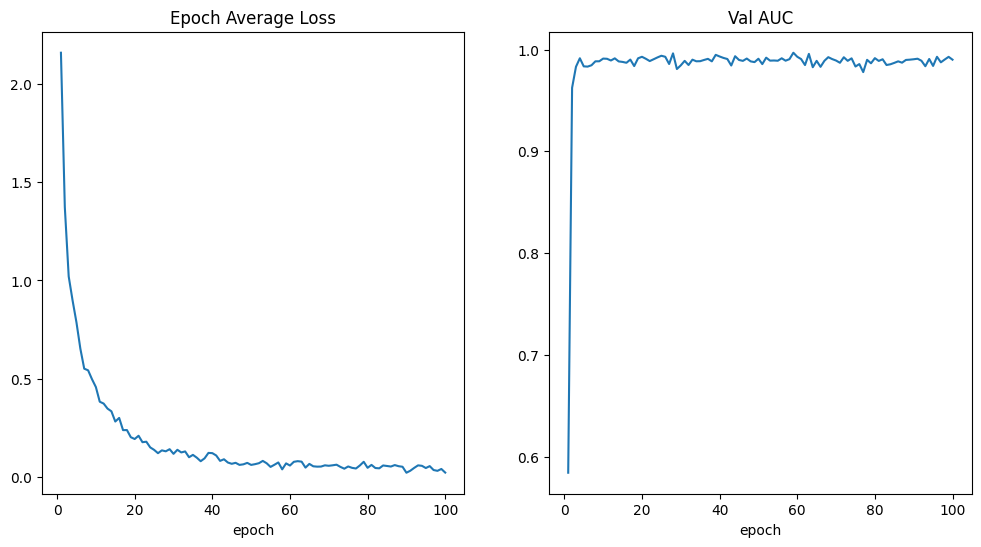

In [66]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [67]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_coronal.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [68]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9014    0.9275    0.9143        69
           1     0.6250    0.5882    0.6061        68
           2     0.7143    0.6522    0.6818        69
           3     0.6364    0.6462    0.6412        65
           4     0.6061    0.6154    0.6107        65
           5     0.8361    0.7727    0.8031        66
           6     0.9600    0.8571    0.9057        28
           7     0.9048    0.9048    0.9048        21
           8     0.8636    0.9048    0.8837        21
           9     0.7612    0.7391    0.7500        69
          10     0.7143    0.8696    0.7843        69

    accuracy                         0.7459       610
   macro avg     0.7748    0.7707    0.7714       610
weighted avg     0.7471    0.7459    0.7451       610



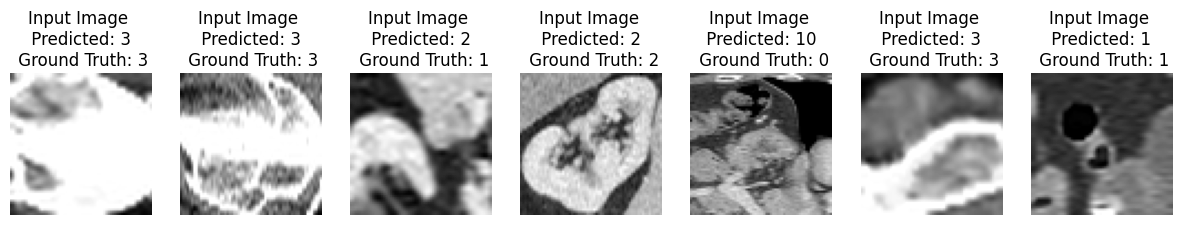

In [69]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, len(images))
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(example_coronal[1], example_preds[1], example_labels[1], n=7)

## Unpretrained

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [71]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    # batch_iter = tqdm(train_loader, desc="Training Batches", leave=False)
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(coronal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        batch_iter.set_postfix(train_loss=loss.item())
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_coronal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_coronal.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100
epoch 1 average loss: 2.0491
1


Epochs:   1%|          | 1/100 [00:11<19:33, 11.86s/it]

saved new best metric model
current epoch: 1 current AUC: 0.5882 current accuracy: 0.0932 best AUC: 0.5882 at epoch: 1
----------
epoch 2/100
epoch 2 average loss: 1.5861
1


Epochs:   2%|▏         | 2/100 [00:20<16:23, 10.04s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9384 current accuracy: 0.4037 best AUC: 0.9384 at epoch: 2
----------
epoch 3/100
epoch 3 average loss: 1.2955
1


Epochs:   3%|▎         | 3/100 [00:30<16:19, 10.09s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9700 current accuracy: 0.6398 best AUC: 0.9700 at epoch: 3
----------
epoch 4/100
epoch 4 average loss: 1.0967
1


Epochs:   4%|▍         | 4/100 [00:40<16:12, 10.13s/it]

current epoch: 4 current AUC: 0.9651 current accuracy: 0.5590 best AUC: 0.9700 at epoch: 3
----------
epoch 5/100
epoch 5 average loss: 0.9291
1


Epochs:   5%|▌         | 5/100 [00:51<16:25, 10.37s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9780 current accuracy: 0.7081 best AUC: 0.9780 at epoch: 5
----------
epoch 6/100
epoch 6 average loss: 0.8235
1


Epochs:   6%|▌         | 6/100 [01:02<16:25, 10.49s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9824 current accuracy: 0.7391 best AUC: 0.9824 at epoch: 6
----------
epoch 7/100
epoch 7 average loss: 0.7376
1


Epochs:   7%|▋         | 7/100 [01:14<16:52, 10.89s/it]

saved new best metric model
current epoch: 7 current AUC: 0.9829 current accuracy: 0.7391 best AUC: 0.9829 at epoch: 7
----------
epoch 8/100
epoch 8 average loss: 0.7276
1


Epochs:   8%|▊         | 8/100 [01:25<17:02, 11.11s/it]

current epoch: 8 current AUC: 0.9812 current accuracy: 0.7640 best AUC: 0.9829 at epoch: 7
----------
epoch 9/100
epoch 9 average loss: 0.6417


Epochs:   9%|▉         | 9/100 [01:37<17:09, 11.32s/it]

1
current epoch: 9 current AUC: 0.9816 current accuracy: 0.7267 best AUC: 0.9829 at epoch: 7
----------
epoch 10/100
epoch 10 average loss: 0.6614
1


Epochs:  10%|█         | 10/100 [01:47<16:29, 10.99s/it]

current epoch: 10 current AUC: 0.9759 current accuracy: 0.6957 best AUC: 0.9829 at epoch: 7
----------
epoch 11/100
epoch 11 average loss: 0.5740
1


Epochs:  11%|█         | 11/100 [01:59<16:33, 11.16s/it]

current epoch: 11 current AUC: 0.9825 current accuracy: 0.7702 best AUC: 0.9829 at epoch: 7
----------
epoch 12/100
epoch 12 average loss: 0.5255


Epochs:  12%|█▏        | 12/100 [02:09<16:07, 10.99s/it]

1
current epoch: 12 current AUC: 0.9790 current accuracy: 0.7267 best AUC: 0.9829 at epoch: 7
----------
epoch 13/100
epoch 13 average loss: 0.5362
1


Epochs:  13%|█▎        | 13/100 [02:19<15:28, 10.68s/it]

current epoch: 13 current AUC: 0.9808 current accuracy: 0.7888 best AUC: 0.9829 at epoch: 7
----------
epoch 14/100
epoch 14 average loss: 0.4961


Epochs:  14%|█▍        | 14/100 [02:30<15:11, 10.60s/it]

1
current epoch: 14 current AUC: 0.9788 current accuracy: 0.7329 best AUC: 0.9829 at epoch: 7
----------
epoch 15/100
epoch 15 average loss: 0.4672


Epochs:  15%|█▌        | 15/100 [02:41<15:11, 10.72s/it]

1
current epoch: 15 current AUC: 0.9802 current accuracy: 0.8012 best AUC: 0.9829 at epoch: 7
----------
epoch 16/100
epoch 16 average loss: 0.4159


Epochs:  16%|█▌        | 16/100 [02:53<15:33, 11.12s/it]

1
current epoch: 16 current AUC: 0.9807 current accuracy: 0.7826 best AUC: 0.9829 at epoch: 7
----------
epoch 17/100
epoch 17 average loss: 0.3592


Epochs:  17%|█▋        | 17/100 [03:03<15:06, 10.92s/it]

1
current epoch: 17 current AUC: 0.9816 current accuracy: 0.8012 best AUC: 0.9829 at epoch: 7
----------
epoch 18/100
epoch 18 average loss: 0.3808


Epochs:  18%|█▊        | 18/100 [03:14<14:47, 10.83s/it]

1
current epoch: 18 current AUC: 0.9751 current accuracy: 0.7516 best AUC: 0.9829 at epoch: 7
----------
epoch 19/100
epoch 19 average loss: 0.3353


Epochs:  19%|█▉        | 19/100 [03:23<13:46, 10.20s/it]

1
current epoch: 19 current AUC: 0.9809 current accuracy: 0.7702 best AUC: 0.9829 at epoch: 7
----------
epoch 20/100
epoch 20 average loss: 0.3961
1


Epochs:  20%|██        | 20/100 [03:33<13:31, 10.14s/it]

saved new best metric model
current epoch: 20 current AUC: 0.9835 current accuracy: 0.8261 best AUC: 0.9835 at epoch: 20
----------
epoch 21/100
epoch 21 average loss: 0.3402
1


Epochs:  21%|██        | 21/100 [03:43<13:24, 10.19s/it]

saved new best metric model
current epoch: 21 current AUC: 0.9850 current accuracy: 0.8075 best AUC: 0.9850 at epoch: 21
----------
epoch 22/100
epoch 22 average loss: 0.3288


Epochs:  22%|██▏       | 22/100 [03:54<13:30, 10.39s/it]

1
current epoch: 22 current AUC: 0.9813 current accuracy: 0.7888 best AUC: 0.9850 at epoch: 21
----------
epoch 23/100
epoch 23 average loss: 0.2988


Epochs:  23%|██▎       | 23/100 [04:04<13:09, 10.25s/it]

1
current epoch: 23 current AUC: 0.9836 current accuracy: 0.8012 best AUC: 0.9850 at epoch: 21
----------
epoch 24/100
epoch 24 average loss: 0.2547


Epochs:  24%|██▍       | 24/100 [04:14<13:06, 10.35s/it]

1
current epoch: 24 current AUC: 0.9830 current accuracy: 0.7888 best AUC: 0.9850 at epoch: 21
----------
epoch 25/100
epoch 25 average loss: 0.2742


Epochs:  25%|██▌       | 25/100 [04:26<13:18, 10.64s/it]

1
current epoch: 25 current AUC: 0.9740 current accuracy: 0.6460 best AUC: 0.9850 at epoch: 21
----------
epoch 26/100
epoch 26 average loss: 0.2772
1


Epochs:  26%|██▌       | 26/100 [04:36<12:50, 10.41s/it]

current epoch: 26 current AUC: 0.9833 current accuracy: 0.7826 best AUC: 0.9850 at epoch: 21
----------
epoch 27/100
epoch 27 average loss: 0.2504


Epochs:  27%|██▋       | 27/100 [04:45<12:23, 10.19s/it]

1
current epoch: 27 current AUC: 0.9699 current accuracy: 0.7640 best AUC: 0.9850 at epoch: 21
----------
epoch 28/100
epoch 28 average loss: 0.2363


Epochs:  28%|██▊       | 28/100 [04:55<11:59, 10.00s/it]

1
current epoch: 28 current AUC: 0.9800 current accuracy: 0.7640 best AUC: 0.9850 at epoch: 21
----------
epoch 29/100
epoch 29 average loss: 0.2168
1


Epochs:  29%|██▉       | 29/100 [05:08<12:50, 10.86s/it]

saved new best metric model
current epoch: 29 current AUC: 0.9865 current accuracy: 0.8509 best AUC: 0.9865 at epoch: 29
----------
epoch 30/100
epoch 30 average loss: 0.2095
1


Epochs:  30%|███       | 30/100 [05:17<12:17, 10.53s/it]

current epoch: 30 current AUC: 0.9860 current accuracy: 0.8509 best AUC: 0.9865 at epoch: 29
----------
epoch 31/100
epoch 31 average loss: 0.2205


Epochs:  31%|███       | 31/100 [05:28<12:01, 10.46s/it]

1
current epoch: 31 current AUC: 0.9848 current accuracy: 0.7888 best AUC: 0.9865 at epoch: 29
----------
epoch 32/100
epoch 32 average loss: 0.2024


Epochs:  32%|███▏      | 32/100 [05:38<11:55, 10.53s/it]

1
current epoch: 32 current AUC: 0.9806 current accuracy: 0.7640 best AUC: 0.9865 at epoch: 29
----------
epoch 33/100
epoch 33 average loss: 0.1873
1


Epochs:  33%|███▎      | 33/100 [05:49<11:39, 10.45s/it]

current epoch: 33 current AUC: 0.9814 current accuracy: 0.8012 best AUC: 0.9865 at epoch: 29
----------
epoch 34/100
epoch 34 average loss: 0.2198
1


Epochs:  34%|███▍      | 34/100 [05:58<11:12, 10.19s/it]

current epoch: 34 current AUC: 0.9762 current accuracy: 0.7516 best AUC: 0.9865 at epoch: 29
----------
epoch 35/100
epoch 35 average loss: 0.1914


Epochs:  35%|███▌      | 35/100 [06:09<11:09, 10.30s/it]

1
current epoch: 35 current AUC: 0.9860 current accuracy: 0.7950 best AUC: 0.9865 at epoch: 29
----------
epoch 36/100
epoch 36 average loss: 0.1793
1


Epochs:  36%|███▌      | 36/100 [06:20<11:18, 10.60s/it]

saved new best metric model
current epoch: 36 current AUC: 0.9869 current accuracy: 0.8261 best AUC: 0.9869 at epoch: 36
----------
epoch 37/100
epoch 37 average loss: 0.1757
1


Epochs:  37%|███▋      | 37/100 [06:30<10:51, 10.34s/it]

saved new best metric model
current epoch: 37 current AUC: 0.9895 current accuracy: 0.8571 best AUC: 0.9895 at epoch: 37
----------
epoch 38/100
epoch 38 average loss: 0.1536


Epochs:  38%|███▊      | 38/100 [06:41<10:48, 10.46s/it]

1
current epoch: 38 current AUC: 0.9870 current accuracy: 0.8261 best AUC: 0.9895 at epoch: 37
----------
epoch 39/100
epoch 39 average loss: 0.1608
1


Epochs:  39%|███▉      | 39/100 [06:51<10:42, 10.54s/it]

current epoch: 39 current AUC: 0.9844 current accuracy: 0.8075 best AUC: 0.9895 at epoch: 37
----------
epoch 40/100
epoch 40 average loss: 0.1512


Epochs:  40%|████      | 40/100 [07:03<10:58, 10.98s/it]

1
current epoch: 40 current AUC: 0.9859 current accuracy: 0.8261 best AUC: 0.9895 at epoch: 37
----------
epoch 41/100
epoch 41 average loss: 0.1425
1


Epochs:  41%|████      | 41/100 [07:14<10:37, 10.81s/it]

current epoch: 41 current AUC: 0.9805 current accuracy: 0.7764 best AUC: 0.9895 at epoch: 37
----------
epoch 42/100
epoch 42 average loss: 0.1474


Epochs:  42%|████▏     | 42/100 [07:24<10:23, 10.75s/it]

1
current epoch: 42 current AUC: 0.9818 current accuracy: 0.8012 best AUC: 0.9895 at epoch: 37
----------
epoch 43/100
epoch 43 average loss: 0.1486


Epochs:  43%|████▎     | 43/100 [07:35<10:13, 10.77s/it]

1
current epoch: 43 current AUC: 0.9826 current accuracy: 0.8261 best AUC: 0.9895 at epoch: 37
----------
epoch 44/100
epoch 44 average loss: 0.1487


Epochs:  44%|████▍     | 44/100 [07:45<09:56, 10.65s/it]

1
current epoch: 44 current AUC: 0.9826 current accuracy: 0.8199 best AUC: 0.9895 at epoch: 37
----------
epoch 45/100
epoch 45 average loss: 0.1302


Epochs:  45%|████▌     | 45/100 [07:57<10:06, 11.03s/it]

1
current epoch: 45 current AUC: 0.9879 current accuracy: 0.8447 best AUC: 0.9895 at epoch: 37
----------
epoch 46/100
epoch 46 average loss: 0.1623


Epochs:  46%|████▌     | 46/100 [08:08<09:51, 10.95s/it]

1
current epoch: 46 current AUC: 0.9895 current accuracy: 0.8385 best AUC: 0.9895 at epoch: 37
----------
epoch 47/100
epoch 47 average loss: 0.1354


Epochs:  47%|████▋     | 47/100 [08:18<09:21, 10.59s/it]

1
current epoch: 47 current AUC: 0.9862 current accuracy: 0.7888 best AUC: 0.9895 at epoch: 37
----------
epoch 48/100
epoch 48 average loss: 0.1483
1


Epochs:  48%|████▊     | 48/100 [08:29<09:20, 10.78s/it]

current epoch: 48 current AUC: 0.9839 current accuracy: 0.8137 best AUC: 0.9895 at epoch: 37
----------
epoch 49/100
epoch 49 average loss: 0.1130
1


Epochs:  49%|████▉     | 49/100 [08:41<09:19, 10.98s/it]

current epoch: 49 current AUC: 0.9889 current accuracy: 0.8571 best AUC: 0.9895 at epoch: 37
----------
epoch 50/100
epoch 50 average loss: 0.1432
1


Epochs:  50%|█████     | 50/100 [08:53<09:23, 11.27s/it]

saved new best metric model
current epoch: 50 current AUC: 0.9903 current accuracy: 0.8385 best AUC: 0.9903 at epoch: 50
----------
epoch 51/100
epoch 51 average loss: 0.1245
1


Epochs:  51%|█████     | 51/100 [09:05<09:23, 11.51s/it]

current epoch: 51 current AUC: 0.9859 current accuracy: 0.7950 best AUC: 0.9903 at epoch: 50
----------
epoch 52/100
epoch 52 average loss: 0.1053


Epochs:  52%|█████▏    | 52/100 [09:15<08:56, 11.17s/it]

1
current epoch: 52 current AUC: 0.9891 current accuracy: 0.8447 best AUC: 0.9903 at epoch: 50
----------
epoch 53/100
epoch 53 average loss: 0.1572


Epochs:  53%|█████▎    | 53/100 [09:26<08:40, 11.07s/it]

1
current epoch: 53 current AUC: 0.9834 current accuracy: 0.8012 best AUC: 0.9903 at epoch: 50
----------
epoch 54/100
epoch 54 average loss: 0.1212


Epochs:  54%|█████▍    | 54/100 [09:36<08:17, 10.82s/it]

1
current epoch: 54 current AUC: 0.9806 current accuracy: 0.8137 best AUC: 0.9903 at epoch: 50
----------
epoch 55/100
epoch 55 average loss: 0.1014


Epochs:  55%|█████▌    | 55/100 [09:47<08:13, 10.96s/it]

1
current epoch: 55 current AUC: 0.9815 current accuracy: 0.7950 best AUC: 0.9903 at epoch: 50
----------
epoch 56/100
epoch 56 average loss: 0.1366


Epochs:  56%|█████▌    | 56/100 [09:59<08:04, 11.02s/it]

1
current epoch: 56 current AUC: 0.9810 current accuracy: 0.8137 best AUC: 0.9903 at epoch: 50
----------
epoch 57/100
epoch 57 average loss: 0.0967
1


Epochs:  57%|█████▋    | 57/100 [10:09<07:40, 10.71s/it]

current epoch: 57 current AUC: 0.9853 current accuracy: 0.8075 best AUC: 0.9903 at epoch: 50
----------
epoch 58/100
epoch 58 average loss: 0.0833


Epochs:  58%|█████▊    | 58/100 [10:18<07:20, 10.48s/it]

1
current epoch: 58 current AUC: 0.9854 current accuracy: 0.8012 best AUC: 0.9903 at epoch: 50
----------
epoch 59/100
epoch 59 average loss: 0.0887


Epochs:  59%|█████▉    | 59/100 [10:29<07:11, 10.52s/it]

1
current epoch: 59 current AUC: 0.9853 current accuracy: 0.8137 best AUC: 0.9903 at epoch: 50
----------
epoch 60/100
epoch 60 average loss: 0.1327


Epochs:  60%|██████    | 60/100 [10:40<07:00, 10.51s/it]

1
current epoch: 60 current AUC: 0.9873 current accuracy: 0.8199 best AUC: 0.9903 at epoch: 50
----------
epoch 61/100
epoch 61 average loss: 0.1080


Epochs:  61%|██████    | 61/100 [10:50<06:46, 10.42s/it]

1
current epoch: 61 current AUC: 0.9819 current accuracy: 0.8199 best AUC: 0.9903 at epoch: 50
----------
epoch 62/100
epoch 62 average loss: 0.1007


Epochs:  62%|██████▏   | 62/100 [11:01<06:42, 10.59s/it]

1
current epoch: 62 current AUC: 0.9884 current accuracy: 0.8385 best AUC: 0.9903 at epoch: 50
----------
epoch 63/100
epoch 63 average loss: 0.0828


Epochs:  63%|██████▎   | 63/100 [11:11<06:32, 10.62s/it]

1
current epoch: 63 current AUC: 0.9878 current accuracy: 0.8137 best AUC: 0.9903 at epoch: 50
----------
epoch 64/100
epoch 64 average loss: 0.0927
1


Epochs:  64%|██████▍   | 64/100 [11:22<06:18, 10.53s/it]

current epoch: 64 current AUC: 0.9860 current accuracy: 0.8012 best AUC: 0.9903 at epoch: 50
----------
epoch 65/100
epoch 65 average loss: 0.1051


Epochs:  65%|██████▌   | 65/100 [11:33<06:15, 10.72s/it]

1
current epoch: 65 current AUC: 0.9858 current accuracy: 0.7950 best AUC: 0.9903 at epoch: 50
----------
epoch 66/100
epoch 66 average loss: 0.0839


Epochs:  66%|██████▌   | 66/100 [11:43<06:01, 10.63s/it]

1
current epoch: 66 current AUC: 0.9844 current accuracy: 0.8323 best AUC: 0.9903 at epoch: 50
----------
epoch 67/100
epoch 67 average loss: 0.1071


Epochs:  67%|██████▋   | 67/100 [11:55<05:57, 10.82s/it]

1
current epoch: 67 current AUC: 0.9825 current accuracy: 0.8137 best AUC: 0.9903 at epoch: 50
----------
epoch 68/100
epoch 68 average loss: 0.1068


Epochs:  68%|██████▊   | 68/100 [12:05<05:43, 10.74s/it]

1
current epoch: 68 current AUC: 0.9867 current accuracy: 0.8323 best AUC: 0.9903 at epoch: 50
----------
epoch 69/100
epoch 69 average loss: 0.1016


Epochs:  69%|██████▉   | 69/100 [12:17<05:43, 11.10s/it]

1
current epoch: 69 current AUC: 0.9841 current accuracy: 0.8509 best AUC: 0.9903 at epoch: 50
----------
epoch 70/100
epoch 70 average loss: 0.1251
1


Epochs:  70%|███████   | 70/100 [12:28<05:29, 10.97s/it]

saved new best metric model
current epoch: 70 current AUC: 0.9923 current accuracy: 0.8509 best AUC: 0.9923 at epoch: 70
----------
epoch 71/100
epoch 71 average loss: 0.0916
1


Epochs:  71%|███████   | 71/100 [12:38<05:14, 10.84s/it]

current epoch: 71 current AUC: 0.9867 current accuracy: 0.8137 best AUC: 0.9923 at epoch: 70
----------
epoch 72/100
epoch 72 average loss: 0.0708


Epochs:  72%|███████▏  | 72/100 [12:49<05:01, 10.76s/it]

1
current epoch: 72 current AUC: 0.9859 current accuracy: 0.8509 best AUC: 0.9923 at epoch: 70
----------
epoch 73/100
epoch 73 average loss: 0.0718
1


Epochs:  73%|███████▎  | 73/100 [13:01<04:58, 11.05s/it]

current epoch: 73 current AUC: 0.9856 current accuracy: 0.8261 best AUC: 0.9923 at epoch: 70
----------
epoch 74/100
epoch 74 average loss: 0.0673
1


Epochs:  74%|███████▍  | 74/100 [13:10<04:35, 10.61s/it]

current epoch: 74 current AUC: 0.9836 current accuracy: 0.8199 best AUC: 0.9923 at epoch: 70
----------
epoch 75/100
epoch 75 average loss: 0.0714


Epochs:  75%|███████▌  | 75/100 [13:21<04:28, 10.75s/it]

1
current epoch: 75 current AUC: 0.9837 current accuracy: 0.7826 best AUC: 0.9923 at epoch: 70
----------
epoch 76/100
epoch 76 average loss: 0.1061


Epochs:  76%|███████▌  | 76/100 [13:32<04:18, 10.76s/it]

1
current epoch: 76 current AUC: 0.9891 current accuracy: 0.8447 best AUC: 0.9923 at epoch: 70
----------
epoch 77/100
epoch 77 average loss: 0.0802
1


Epochs:  77%|███████▋  | 77/100 [13:43<04:08, 10.80s/it]

current epoch: 77 current AUC: 0.9858 current accuracy: 0.8323 best AUC: 0.9923 at epoch: 70
----------
epoch 78/100
epoch 78 average loss: 0.0817


Epochs:  78%|███████▊  | 78/100 [13:53<03:54, 10.64s/it]

1
current epoch: 78 current AUC: 0.9867 current accuracy: 0.8447 best AUC: 0.9923 at epoch: 70
----------
epoch 79/100
epoch 79 average loss: 0.0948
1


Epochs:  79%|███████▉  | 79/100 [14:05<03:50, 10.96s/it]

current epoch: 79 current AUC: 0.9897 current accuracy: 0.8571 best AUC: 0.9923 at epoch: 70
----------
epoch 80/100
epoch 80 average loss: 0.0851


Epochs:  80%|████████  | 80/100 [14:15<03:35, 10.79s/it]

1
current epoch: 80 current AUC: 0.9853 current accuracy: 0.8385 best AUC: 0.9923 at epoch: 70
----------
epoch 81/100
epoch 81 average loss: 0.0972


Epochs:  81%|████████  | 81/100 [14:28<03:34, 11.27s/it]

1
current epoch: 81 current AUC: 0.9875 current accuracy: 0.8571 best AUC: 0.9923 at epoch: 70
----------
epoch 82/100
epoch 82 average loss: 0.0705


Epochs:  82%|████████▏ | 82/100 [14:38<03:16, 10.90s/it]

1
current epoch: 82 current AUC: 0.9880 current accuracy: 0.8261 best AUC: 0.9923 at epoch: 70
----------
epoch 83/100
epoch 83 average loss: 0.0738


Epochs:  83%|████████▎ | 83/100 [14:49<03:07, 11.00s/it]

1
current epoch: 83 current AUC: 0.9817 current accuracy: 0.7888 best AUC: 0.9923 at epoch: 70
----------
epoch 84/100
epoch 84 average loss: 0.0797


Epochs:  84%|████████▍ | 84/100 [15:01<02:58, 11.17s/it]

1
current epoch: 84 current AUC: 0.9835 current accuracy: 0.7888 best AUC: 0.9923 at epoch: 70
----------
epoch 85/100
epoch 85 average loss: 0.0636


Epochs:  85%|████████▌ | 85/100 [15:12<02:46, 11.12s/it]

1
current epoch: 85 current AUC: 0.9857 current accuracy: 0.8323 best AUC: 0.9923 at epoch: 70
----------
epoch 86/100
epoch 86 average loss: 0.0544


Epochs:  86%|████████▌ | 86/100 [15:22<02:34, 11.06s/it]

1
current epoch: 86 current AUC: 0.9786 current accuracy: 0.8012 best AUC: 0.9923 at epoch: 70
----------
epoch 87/100
epoch 87 average loss: 0.0792
1


Epochs:  87%|████████▋ | 87/100 [15:33<02:20, 10.85s/it]

current epoch: 87 current AUC: 0.9848 current accuracy: 0.8075 best AUC: 0.9923 at epoch: 70
----------
epoch 88/100
epoch 88 average loss: 0.0744
1


Epochs:  88%|████████▊ | 88/100 [15:42<02:04, 10.37s/it]

current epoch: 88 current AUC: 0.9750 current accuracy: 0.8012 best AUC: 0.9923 at epoch: 70
----------
epoch 89/100
epoch 89 average loss: 0.0825


Epochs:  89%|████████▉ | 89/100 [15:53<01:57, 10.65s/it]

1
current epoch: 89 current AUC: 0.9805 current accuracy: 0.8012 best AUC: 0.9923 at epoch: 70
----------
epoch 90/100
epoch 90 average loss: 0.0510


Epochs:  90%|█████████ | 90/100 [16:04<01:46, 10.64s/it]

1
current epoch: 90 current AUC: 0.9877 current accuracy: 0.8137 best AUC: 0.9923 at epoch: 70
----------
epoch 91/100
epoch 91 average loss: 0.0607


Epochs:  91%|█████████ | 91/100 [16:14<01:35, 10.59s/it]

1
current epoch: 91 current AUC: 0.9789 current accuracy: 0.7764 best AUC: 0.9923 at epoch: 70
----------
epoch 92/100
epoch 92 average loss: 0.0434


Epochs:  92%|█████████▏| 92/100 [16:25<01:25, 10.70s/it]

1
current epoch: 92 current AUC: 0.9855 current accuracy: 0.8199 best AUC: 0.9923 at epoch: 70
----------
epoch 93/100
epoch 93 average loss: 0.0589


Epochs:  93%|█████████▎| 93/100 [16:37<01:16, 10.91s/it]

1
current epoch: 93 current AUC: 0.9816 current accuracy: 0.8323 best AUC: 0.9923 at epoch: 70
----------
epoch 94/100
epoch 94 average loss: 0.0770
1


Epochs:  94%|█████████▍| 94/100 [16:47<01:04, 10.78s/it]

current epoch: 94 current AUC: 0.9812 current accuracy: 0.8012 best AUC: 0.9923 at epoch: 70
----------
epoch 95/100
epoch 95 average loss: 0.0888


Epochs:  95%|█████████▌| 95/100 [16:58<00:53, 10.79s/it]

1
current epoch: 95 current AUC: 0.9730 current accuracy: 0.7702 best AUC: 0.9923 at epoch: 70
----------
epoch 96/100
epoch 96 average loss: 0.0828


Epochs:  96%|█████████▌| 96/100 [17:08<00:42, 10.56s/it]

1
current epoch: 96 current AUC: 0.9839 current accuracy: 0.8323 best AUC: 0.9923 at epoch: 70
----------
epoch 97/100
epoch 97 average loss: 0.0603


Epochs:  97%|█████████▋| 97/100 [17:18<00:30, 10.32s/it]

1
current epoch: 97 current AUC: 0.9811 current accuracy: 0.8137 best AUC: 0.9923 at epoch: 70
----------
epoch 98/100
epoch 98 average loss: 0.0623


Epochs:  98%|█████████▊| 98/100 [17:29<00:20, 10.49s/it]

1
current epoch: 98 current AUC: 0.9800 current accuracy: 0.8075 best AUC: 0.9923 at epoch: 70
----------
epoch 99/100
epoch 99 average loss: 0.0491
1


Epochs:  99%|█████████▉| 99/100 [17:38<00:10, 10.26s/it]

current epoch: 99 current AUC: 0.9851 current accuracy: 0.8261 best AUC: 0.9923 at epoch: 70
----------
epoch 100/100
epoch 100 average loss: 0.0518
1


Epochs: 100%|██████████| 100/100 [17:49<00:00, 10.69s/it]

current epoch: 100 current AUC: 0.9833 current accuracy: 0.8137 best AUC: 0.9923 at epoch: 70
train completed, best_metric: 0.9923 at epoch: 70


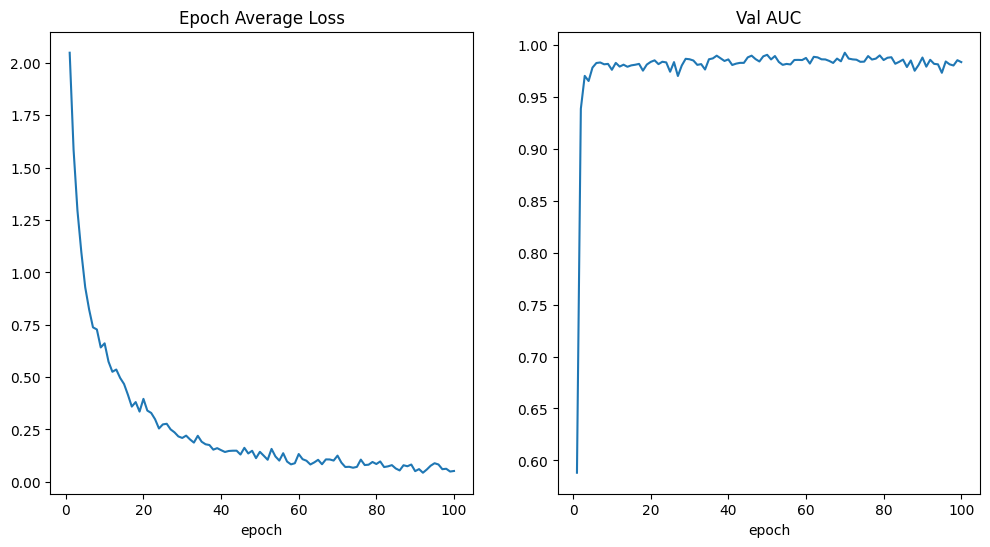

In [72]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [73]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [74]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8197    0.7246    0.7692        69
           1     0.5373    0.5294    0.5333        68
           2     0.5283    0.4058    0.4590        69
           3     0.4146    0.5231    0.4626        65
           4     0.4231    0.3385    0.3761        65
           5     0.7612    0.7727    0.7669        66
           6     0.7857    0.3929    0.5238        28
           7     0.6452    0.9524    0.7692        21
           8     0.9000    0.4286    0.5806        21
           9     0.5854    0.6957    0.6358        69
          10     0.4505    0.5942    0.5125        69

    accuracy                         0.5738       610
   macro avg     0.6228    0.5780    0.5808       610
weighted avg     0.5904    0.5738    0.5711       610



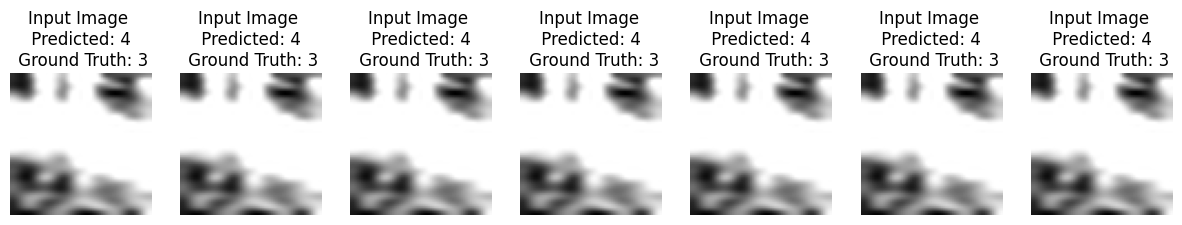

In [75]:
plot_examples(test_coronal, pred, test_labels, n=7)

## Training cycle for the sagittal part

## Pretrained

In [76]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [77]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    # batch_iter = tqdm(train_loader, desc="Training Batches", leave=False)
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        batch_iter.set_postfix(train_loss=loss.item())
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100
epoch 1 average loss: 2.1277
1


Epochs:   1%|          | 1/100 [00:11<19:22, 11.75s/it]

saved new best metric model
current epoch: 1 current AUC: 0.6944 current accuracy: 0.1677 best AUC: 0.6944 at epoch: 1
----------
epoch 2/100
epoch 2 average loss: 1.3438
1


Epochs:   2%|▏         | 2/100 [00:24<19:42, 12.07s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9557 current accuracy: 0.6460 best AUC: 0.9557 at epoch: 2
----------
epoch 3/100
epoch 3 average loss: 1.0256
1


Epochs:   3%|▎         | 3/100 [00:35<18:46, 11.61s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9673 current accuracy: 0.6522 best AUC: 0.9673 at epoch: 3
----------
epoch 4/100
epoch 4 average loss: 0.8677


Epochs:   4%|▍         | 4/100 [00:45<17:42, 11.07s/it]

1
current epoch: 4 current AUC: 0.9666 current accuracy: 0.6584 best AUC: 0.9673 at epoch: 3
----------
epoch 5/100
epoch 5 average loss: 0.7797
1


Epochs:   5%|▌         | 5/100 [00:56<17:22, 10.97s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9723 current accuracy: 0.7267 best AUC: 0.9723 at epoch: 5
----------
epoch 6/100
epoch 6 average loss: 0.6968
1


Epochs:   6%|▌         | 6/100 [01:07<17:32, 11.20s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9789 current accuracy: 0.7640 best AUC: 0.9789 at epoch: 6
----------
epoch 7/100
epoch 7 average loss: 0.5940
1


Epochs:   7%|▋         | 7/100 [01:17<16:49, 10.86s/it]

saved new best metric model
current epoch: 7 current AUC: 0.9816 current accuracy: 0.7640 best AUC: 0.9816 at epoch: 7
----------
epoch 8/100
epoch 8 average loss: 0.5599


Epochs:   8%|▊         | 8/100 [01:29<16:46, 10.94s/it]

1
current epoch: 8 current AUC: 0.9814 current accuracy: 0.7578 best AUC: 0.9816 at epoch: 7
----------
epoch 9/100
epoch 9 average loss: 0.5032
1


Epochs:   9%|▉         | 9/100 [01:38<15:51, 10.45s/it]

current epoch: 9 current AUC: 0.9787 current accuracy: 0.7764 best AUC: 0.9816 at epoch: 7
----------
epoch 10/100
epoch 10 average loss: 0.4539
1


Epochs:  10%|█         | 10/100 [01:48<15:19, 10.22s/it]

saved new best metric model
current epoch: 10 current AUC: 0.9820 current accuracy: 0.7578 best AUC: 0.9820 at epoch: 10
----------
epoch 11/100
epoch 11 average loss: 0.4073


Epochs:  11%|█         | 11/100 [01:57<14:49,  9.99s/it]

1
current epoch: 11 current AUC: 0.9814 current accuracy: 0.7826 best AUC: 0.9820 at epoch: 10
----------
epoch 12/100
epoch 12 average loss: 0.3503
1


Epochs:  12%|█▏        | 12/100 [02:09<15:40, 10.69s/it]

saved new best metric model
current epoch: 12 current AUC: 0.9872 current accuracy: 0.8199 best AUC: 0.9872 at epoch: 12
----------
epoch 13/100
epoch 13 average loss: 0.3527
1


Epochs:  13%|█▎        | 13/100 [02:19<15:01, 10.36s/it]

current epoch: 13 current AUC: 0.9858 current accuracy: 0.8137 best AUC: 0.9872 at epoch: 12
----------
epoch 14/100
epoch 14 average loss: 0.3285


Epochs:  14%|█▍        | 14/100 [02:28<14:23, 10.04s/it]

1
current epoch: 14 current AUC: 0.9856 current accuracy: 0.8261 best AUC: 0.9872 at epoch: 12
----------
epoch 15/100
epoch 15 average loss: 0.3046
1


Epochs:  15%|█▌        | 15/100 [02:40<14:47, 10.45s/it]

current epoch: 15 current AUC: 0.9754 current accuracy: 0.7516 best AUC: 0.9872 at epoch: 12
----------
epoch 16/100
epoch 16 average loss: 0.2645


Epochs:  16%|█▌        | 16/100 [02:50<14:29, 10.35s/it]

1
current epoch: 16 current AUC: 0.9832 current accuracy: 0.8012 best AUC: 0.9872 at epoch: 12
----------
epoch 17/100
epoch 17 average loss: 0.2383


Epochs:  17%|█▋        | 17/100 [03:00<14:27, 10.45s/it]

1
current epoch: 17 current AUC: 0.9757 current accuracy: 0.7453 best AUC: 0.9872 at epoch: 12
----------
epoch 18/100
epoch 18 average loss: 0.2202


Epochs:  18%|█▊        | 18/100 [03:11<14:12, 10.39s/it]

1
current epoch: 18 current AUC: 0.9811 current accuracy: 0.7826 best AUC: 0.9872 at epoch: 12
----------
epoch 19/100
epoch 19 average loss: 0.2489


Epochs:  19%|█▉        | 19/100 [03:21<14:07, 10.46s/it]

1
current epoch: 19 current AUC: 0.9867 current accuracy: 0.8509 best AUC: 0.9872 at epoch: 12
----------
epoch 20/100
epoch 20 average loss: 0.2169


Epochs:  20%|██        | 20/100 [03:32<13:59, 10.50s/it]

1
current epoch: 20 current AUC: 0.9843 current accuracy: 0.8075 best AUC: 0.9872 at epoch: 12
----------
epoch 21/100
epoch 21 average loss: 0.2185
1


Epochs:  21%|██        | 21/100 [03:43<14:02, 10.66s/it]

saved new best metric model
current epoch: 21 current AUC: 0.9891 current accuracy: 0.8509 best AUC: 0.9891 at epoch: 21
----------
epoch 22/100
epoch 22 average loss: 0.1788


Epochs:  22%|██▏       | 22/100 [03:54<13:49, 10.63s/it]

1
current epoch: 22 current AUC: 0.9821 current accuracy: 0.8075 best AUC: 0.9891 at epoch: 21
----------
epoch 23/100
epoch 23 average loss: 0.1873


Epochs:  23%|██▎       | 23/100 [04:03<13:18, 10.37s/it]

1
current epoch: 23 current AUC: 0.9799 current accuracy: 0.7640 best AUC: 0.9891 at epoch: 21
----------
epoch 24/100
epoch 24 average loss: 0.1418
1


Epochs:  24%|██▍       | 24/100 [04:15<13:32, 10.69s/it]

saved new best metric model
current epoch: 24 current AUC: 0.9892 current accuracy: 0.8385 best AUC: 0.9892 at epoch: 24
----------
epoch 25/100
epoch 25 average loss: 0.1768


Epochs:  25%|██▌       | 25/100 [04:26<13:25, 10.74s/it]

1
current epoch: 25 current AUC: 0.9783 current accuracy: 0.7826 best AUC: 0.9892 at epoch: 24
----------
epoch 26/100
epoch 26 average loss: 0.1295


Epochs:  26%|██▌       | 26/100 [04:35<12:40, 10.27s/it]

1
current epoch: 26 current AUC: 0.9815 current accuracy: 0.8012 best AUC: 0.9892 at epoch: 24
----------
epoch 27/100
epoch 27 average loss: 0.1468
1


Epochs:  27%|██▋       | 27/100 [04:45<12:38, 10.39s/it]

current epoch: 27 current AUC: 0.9757 current accuracy: 0.7578 best AUC: 0.9892 at epoch: 24
----------
epoch 28/100
epoch 28 average loss: 0.1268


Epochs:  28%|██▊       | 28/100 [04:57<12:44, 10.62s/it]

1
current epoch: 28 current AUC: 0.9800 current accuracy: 0.7826 best AUC: 0.9892 at epoch: 24
----------
epoch 29/100
epoch 29 average loss: 0.1279


Epochs:  29%|██▉       | 29/100 [05:07<12:28, 10.55s/it]

1
current epoch: 29 current AUC: 0.9832 current accuracy: 0.8075 best AUC: 0.9892 at epoch: 24
----------
epoch 30/100
epoch 30 average loss: 0.1483


Epochs:  30%|███       | 30/100 [05:16<11:48, 10.12s/it]

1
current epoch: 30 current AUC: 0.9854 current accuracy: 0.8323 best AUC: 0.9892 at epoch: 24
----------
epoch 31/100
epoch 31 average loss: 0.1218
1


Epochs:  31%|███       | 31/100 [05:25<11:11,  9.72s/it]

saved new best metric model
current epoch: 31 current AUC: 0.9900 current accuracy: 0.8634 best AUC: 0.9900 at epoch: 31
----------
epoch 32/100
epoch 32 average loss: 0.1028
1


Epochs:  32%|███▏      | 32/100 [05:32<10:00,  8.83s/it]

current epoch: 32 current AUC: 0.9766 current accuracy: 0.7826 best AUC: 0.9900 at epoch: 31
----------
epoch 33/100
epoch 33 average loss: 0.1131
1


Epochs:  33%|███▎      | 33/100 [05:38<09:10,  8.21s/it]

current epoch: 33 current AUC: 0.9824 current accuracy: 0.7764 best AUC: 0.9900 at epoch: 31
----------
epoch 34/100
epoch 34 average loss: 0.1214
1


Epochs:  34%|███▍      | 34/100 [05:45<08:36,  7.82s/it]

current epoch: 34 current AUC: 0.9805 current accuracy: 0.7826 best AUC: 0.9900 at epoch: 31
----------
epoch 35/100
epoch 35 average loss: 0.1469
1


Epochs:  35%|███▌      | 35/100 [05:52<08:06,  7.49s/it]

current epoch: 35 current AUC: 0.9885 current accuracy: 0.8261 best AUC: 0.9900 at epoch: 31
----------
epoch 36/100
epoch 36 average loss: 0.1339
1


Epochs:  36%|███▌      | 36/100 [05:59<07:43,  7.24s/it]

current epoch: 36 current AUC: 0.9815 current accuracy: 0.8012 best AUC: 0.9900 at epoch: 31
----------
epoch 37/100
epoch 37 average loss: 0.1508
1


Epochs:  37%|███▋      | 37/100 [06:06<07:29,  7.13s/it]

current epoch: 37 current AUC: 0.9882 current accuracy: 0.8509 best AUC: 0.9900 at epoch: 31
----------
epoch 38/100
epoch 38 average loss: 0.1072
1


Epochs:  38%|███▊      | 38/100 [06:12<07:14,  7.01s/it]

current epoch: 38 current AUC: 0.9826 current accuracy: 0.8137 best AUC: 0.9900 at epoch: 31
----------
epoch 39/100
epoch 39 average loss: 0.1159
1


Epochs:  39%|███▉      | 39/100 [06:19<07:02,  6.92s/it]

current epoch: 39 current AUC: 0.9856 current accuracy: 0.8137 best AUC: 0.9900 at epoch: 31
----------
epoch 40/100
epoch 40 average loss: 0.0880
1


Epochs:  40%|████      | 40/100 [06:26<06:52,  6.87s/it]

current epoch: 40 current AUC: 0.9810 current accuracy: 0.8012 best AUC: 0.9900 at epoch: 31
----------
epoch 41/100
epoch 41 average loss: 0.0935
1


Epochs:  41%|████      | 41/100 [06:33<06:42,  6.82s/it]

current epoch: 41 current AUC: 0.9833 current accuracy: 0.8261 best AUC: 0.9900 at epoch: 31
----------
epoch 42/100
epoch 42 average loss: 0.0728
1


Epochs:  42%|████▏     | 42/100 [06:39<06:32,  6.78s/it]

current epoch: 42 current AUC: 0.9809 current accuracy: 0.8075 best AUC: 0.9900 at epoch: 31
----------
epoch 43/100
epoch 43 average loss: 0.0857
1


Epochs:  43%|████▎     | 43/100 [06:46<06:24,  6.75s/it]

current epoch: 43 current AUC: 0.9800 current accuracy: 0.7826 best AUC: 0.9900 at epoch: 31
----------
epoch 44/100
epoch 44 average loss: 0.0731
1


Epochs:  44%|████▍     | 44/100 [06:53<06:17,  6.74s/it]

current epoch: 44 current AUC: 0.9852 current accuracy: 0.8261 best AUC: 0.9900 at epoch: 31
----------
epoch 45/100
epoch 45 average loss: 0.0882
1


Epochs:  45%|████▌     | 45/100 [06:59<06:09,  6.73s/it]

current epoch: 45 current AUC: 0.9873 current accuracy: 0.8012 best AUC: 0.9900 at epoch: 31
----------
epoch 46/100
epoch 46 average loss: 0.0905
1


Epochs:  46%|████▌     | 46/100 [07:06<06:03,  6.74s/it]

current epoch: 46 current AUC: 0.9845 current accuracy: 0.8199 best AUC: 0.9900 at epoch: 31
----------
epoch 47/100
epoch 47 average loss: 0.0728
1


Epochs:  47%|████▋     | 47/100 [07:13<05:56,  6.73s/it]

current epoch: 47 current AUC: 0.9821 current accuracy: 0.8385 best AUC: 0.9900 at epoch: 31
----------
epoch 48/100
epoch 48 average loss: 0.0791
1


Epochs:  48%|████▊     | 48/100 [07:20<05:55,  6.84s/it]

saved new best metric model
current epoch: 48 current AUC: 0.9900 current accuracy: 0.8944 best AUC: 0.9900 at epoch: 48
----------
epoch 49/100
epoch 49 average loss: 0.0743
1


Epochs:  49%|████▉     | 49/100 [07:27<05:46,  6.80s/it]

current epoch: 49 current AUC: 0.9842 current accuracy: 0.8137 best AUC: 0.9900 at epoch: 48
----------
epoch 50/100
epoch 50 average loss: 0.0792
1


Epochs:  50%|█████     | 50/100 [07:34<05:46,  6.94s/it]

current epoch: 50 current AUC: 0.9801 current accuracy: 0.8137 best AUC: 0.9900 at epoch: 48
----------
epoch 51/100
epoch 51 average loss: 0.0654
1


Epochs:  51%|█████     | 51/100 [07:41<05:37,  6.88s/it]

current epoch: 51 current AUC: 0.9845 current accuracy: 0.8137 best AUC: 0.9900 at epoch: 48
----------
epoch 52/100
epoch 52 average loss: 0.0549
1


Epochs:  52%|█████▏    | 52/100 [07:47<05:26,  6.80s/it]

current epoch: 52 current AUC: 0.9834 current accuracy: 0.8385 best AUC: 0.9900 at epoch: 48
----------
epoch 53/100
epoch 53 average loss: 0.0652
1


Epochs:  53%|█████▎    | 53/100 [07:54<05:19,  6.80s/it]

current epoch: 53 current AUC: 0.9820 current accuracy: 0.8137 best AUC: 0.9900 at epoch: 48
----------
epoch 54/100
epoch 54 average loss: 0.0691
1


Epochs:  54%|█████▍    | 54/100 [08:01<05:11,  6.78s/it]

current epoch: 54 current AUC: 0.9866 current accuracy: 0.8385 best AUC: 0.9900 at epoch: 48
----------
epoch 55/100
epoch 55 average loss: 0.0538
1


Epochs:  55%|█████▌    | 55/100 [08:07<05:04,  6.76s/it]

current epoch: 55 current AUC: 0.9878 current accuracy: 0.8261 best AUC: 0.9900 at epoch: 48
----------
epoch 56/100
epoch 56 average loss: 0.0666
1


Epochs:  56%|█████▌    | 56/100 [08:15<05:03,  6.90s/it]

saved new best metric model
current epoch: 56 current AUC: 0.9903 current accuracy: 0.8447 best AUC: 0.9903 at epoch: 56
----------
epoch 57/100
epoch 57 average loss: 0.0720
1


Epochs:  57%|█████▋    | 57/100 [08:22<05:04,  7.07s/it]

current epoch: 57 current AUC: 0.9864 current accuracy: 0.8137 best AUC: 0.9903 at epoch: 56
----------
epoch 58/100
epoch 58 average loss: 0.0724
1


Epochs:  58%|█████▊    | 58/100 [08:29<04:53,  6.98s/it]

current epoch: 58 current AUC: 0.9888 current accuracy: 0.8199 best AUC: 0.9903 at epoch: 56
----------
epoch 59/100
epoch 59 average loss: 0.0527
1


Epochs:  59%|█████▉    | 59/100 [08:36<04:42,  6.90s/it]

current epoch: 59 current AUC: 0.9891 current accuracy: 0.8323 best AUC: 0.9903 at epoch: 56
----------
epoch 60/100
epoch 60 average loss: 0.0594
1


Epochs:  60%|██████    | 60/100 [08:43<04:40,  7.01s/it]

saved new best metric model
current epoch: 60 current AUC: 0.9904 current accuracy: 0.8385 best AUC: 0.9904 at epoch: 60
----------
epoch 61/100
epoch 61 average loss: 0.0544
1


Epochs:  61%|██████    | 61/100 [08:50<04:30,  6.92s/it]

current epoch: 61 current AUC: 0.9859 current accuracy: 0.8323 best AUC: 0.9904 at epoch: 60
----------
epoch 62/100
epoch 62 average loss: 0.0737
1


Epochs:  62%|██████▏   | 62/100 [08:56<04:20,  6.85s/it]

current epoch: 62 current AUC: 0.9828 current accuracy: 0.8012 best AUC: 0.9904 at epoch: 60
----------
epoch 63/100
epoch 63 average loss: 0.0609
1


Epochs:  63%|██████▎   | 63/100 [09:03<04:13,  6.85s/it]

current epoch: 63 current AUC: 0.9790 current accuracy: 0.7888 best AUC: 0.9904 at epoch: 60
----------
epoch 64/100
epoch 64 average loss: 0.1077
1


Epochs:  64%|██████▍   | 64/100 [09:10<04:06,  6.85s/it]

current epoch: 64 current AUC: 0.9770 current accuracy: 0.7826 best AUC: 0.9904 at epoch: 60
----------
epoch 65/100
epoch 65 average loss: 0.0698
1


Epochs:  65%|██████▌   | 65/100 [09:17<04:00,  6.86s/it]

current epoch: 65 current AUC: 0.9836 current accuracy: 0.8261 best AUC: 0.9904 at epoch: 60
----------
epoch 66/100
epoch 66 average loss: 0.0536
1


Epochs:  66%|██████▌   | 66/100 [09:24<03:56,  6.96s/it]

saved new best metric model
current epoch: 66 current AUC: 0.9909 current accuracy: 0.8447 best AUC: 0.9909 at epoch: 66
----------
epoch 67/100
epoch 67 average loss: 0.0434
1


Epochs:  67%|██████▋   | 67/100 [09:31<03:47,  6.89s/it]

current epoch: 67 current AUC: 0.9903 current accuracy: 0.8137 best AUC: 0.9909 at epoch: 66
----------
epoch 68/100
epoch 68 average loss: 0.0431
1


Epochs:  68%|██████▊   | 68/100 [09:38<03:44,  7.02s/it]

current epoch: 68 current AUC: 0.9892 current accuracy: 0.8447 best AUC: 0.9909 at epoch: 66
----------
epoch 69/100
epoch 69 average loss: 0.0495
1


Epochs:  69%|██████▉   | 69/100 [09:45<03:34,  6.91s/it]

current epoch: 69 current AUC: 0.9885 current accuracy: 0.8012 best AUC: 0.9909 at epoch: 66
----------
epoch 70/100
epoch 70 average loss: 0.0356
1


Epochs:  70%|███████   | 70/100 [09:51<03:25,  6.85s/it]

current epoch: 70 current AUC: 0.9867 current accuracy: 0.8012 best AUC: 0.9909 at epoch: 66
----------
epoch 71/100
epoch 71 average loss: 0.0607
1


Epochs:  71%|███████   | 71/100 [09:58<03:17,  6.79s/it]

current epoch: 71 current AUC: 0.9823 current accuracy: 0.7888 best AUC: 0.9909 at epoch: 66
----------
epoch 72/100
epoch 72 average loss: 0.0560
1


Epochs:  72%|███████▏  | 72/100 [10:05<03:09,  6.78s/it]

current epoch: 72 current AUC: 0.9871 current accuracy: 0.8323 best AUC: 0.9909 at epoch: 66
----------
epoch 73/100
epoch 73 average loss: 0.0424
1


Epochs:  73%|███████▎  | 73/100 [10:12<03:06,  6.89s/it]

saved new best metric model
current epoch: 73 current AUC: 0.9940 current accuracy: 0.9006 best AUC: 0.9940 at epoch: 73
----------
epoch 74/100
epoch 74 average loss: 0.0508
1


Epochs:  74%|███████▍  | 74/100 [10:19<02:58,  6.86s/it]

current epoch: 74 current AUC: 0.9862 current accuracy: 0.8075 best AUC: 0.9940 at epoch: 73
----------
epoch 75/100
epoch 75 average loss: 0.0578
1


Epochs:  75%|███████▌  | 75/100 [10:25<02:49,  6.80s/it]

current epoch: 75 current AUC: 0.9888 current accuracy: 0.7950 best AUC: 0.9940 at epoch: 73
----------
epoch 76/100
epoch 76 average loss: 0.0494
1


Epochs:  76%|███████▌  | 76/100 [10:32<02:42,  6.76s/it]

current epoch: 76 current AUC: 0.9920 current accuracy: 0.8696 best AUC: 0.9940 at epoch: 73
----------
epoch 77/100
epoch 77 average loss: 0.0471
1


Epochs:  77%|███████▋  | 77/100 [10:39<02:35,  6.76s/it]

current epoch: 77 current AUC: 0.9918 current accuracy: 0.8634 best AUC: 0.9940 at epoch: 73
----------
epoch 78/100
epoch 78 average loss: 0.0464
1


Epochs:  78%|███████▊  | 78/100 [10:46<02:28,  6.74s/it]

current epoch: 78 current AUC: 0.9911 current accuracy: 0.8634 best AUC: 0.9940 at epoch: 73
----------
epoch 79/100
epoch 79 average loss: 0.0560
1


Epochs:  79%|███████▉  | 79/100 [10:52<02:21,  6.72s/it]

current epoch: 79 current AUC: 0.9907 current accuracy: 0.8571 best AUC: 0.9940 at epoch: 73
----------
epoch 80/100
epoch 80 average loss: 0.0402
1


Epochs:  80%|████████  | 80/100 [10:59<02:14,  6.73s/it]

current epoch: 80 current AUC: 0.9750 current accuracy: 0.7640 best AUC: 0.9940 at epoch: 73
----------
epoch 81/100
epoch 81 average loss: 0.0429
1


Epochs:  81%|████████  | 81/100 [11:06<02:07,  6.71s/it]

current epoch: 81 current AUC: 0.9850 current accuracy: 0.7888 best AUC: 0.9940 at epoch: 73
----------
epoch 82/100
epoch 82 average loss: 0.0517
1


Epochs:  82%|████████▏ | 82/100 [11:12<02:00,  6.71s/it]

current epoch: 82 current AUC: 0.9822 current accuracy: 0.8385 best AUC: 0.9940 at epoch: 73
----------
epoch 83/100
epoch 83 average loss: 0.0397
1


Epochs:  83%|████████▎ | 83/100 [11:19<01:54,  6.72s/it]

current epoch: 83 current AUC: 0.9800 current accuracy: 0.7950 best AUC: 0.9940 at epoch: 73
----------
epoch 84/100
epoch 84 average loss: 0.0528
1


Epochs:  84%|████████▍ | 84/100 [11:26<01:47,  6.71s/it]

current epoch: 84 current AUC: 0.9895 current accuracy: 0.8385 best AUC: 0.9940 at epoch: 73
----------
epoch 85/100
epoch 85 average loss: 0.0644
1


Epochs:  85%|████████▌ | 85/100 [11:33<01:40,  6.71s/it]

current epoch: 85 current AUC: 0.9917 current accuracy: 0.8571 best AUC: 0.9940 at epoch: 73
----------
epoch 86/100
epoch 86 average loss: 0.0573
1


Epochs:  86%|████████▌ | 86/100 [11:39<01:33,  6.71s/it]

current epoch: 86 current AUC: 0.9880 current accuracy: 0.8447 best AUC: 0.9940 at epoch: 73
----------
epoch 87/100
epoch 87 average loss: 0.0480
1


Epochs:  87%|████████▋ | 87/100 [11:46<01:27,  6.70s/it]

current epoch: 87 current AUC: 0.9839 current accuracy: 0.7888 best AUC: 0.9940 at epoch: 73
----------
epoch 88/100
epoch 88 average loss: 0.0448
1


Epochs:  88%|████████▊ | 88/100 [11:53<01:20,  6.70s/it]

current epoch: 88 current AUC: 0.9804 current accuracy: 0.7950 best AUC: 0.9940 at epoch: 73
----------
epoch 89/100
epoch 89 average loss: 0.0295
1


Epochs:  89%|████████▉ | 89/100 [11:59<01:13,  6.71s/it]

current epoch: 89 current AUC: 0.9857 current accuracy: 0.8261 best AUC: 0.9940 at epoch: 73
----------
epoch 90/100
epoch 90 average loss: 0.0494
1


Epochs:  90%|█████████ | 90/100 [12:06<01:07,  6.72s/it]

current epoch: 90 current AUC: 0.9860 current accuracy: 0.8012 best AUC: 0.9940 at epoch: 73
----------
epoch 91/100
epoch 91 average loss: 0.0407
1


Epochs:  91%|█████████ | 91/100 [12:13<01:00,  6.69s/it]

current epoch: 91 current AUC: 0.9638 current accuracy: 0.7950 best AUC: 0.9940 at epoch: 73
----------
epoch 92/100
epoch 92 average loss: 0.0429
1


Epochs:  92%|█████████▏| 92/100 [12:19<00:53,  6.69s/it]

current epoch: 92 current AUC: 0.9852 current accuracy: 0.7950 best AUC: 0.9940 at epoch: 73
----------
epoch 93/100
epoch 93 average loss: 0.0393
1


Epochs:  93%|█████████▎| 93/100 [12:26<00:47,  6.73s/it]

current epoch: 93 current AUC: 0.9872 current accuracy: 0.8509 best AUC: 0.9940 at epoch: 73
----------
epoch 94/100
epoch 94 average loss: 0.0294
1


Epochs:  94%|█████████▍| 94/100 [12:33<00:40,  6.73s/it]

current epoch: 94 current AUC: 0.9839 current accuracy: 0.8385 best AUC: 0.9940 at epoch: 73
----------
epoch 95/100
epoch 95 average loss: 0.0681
1


Epochs:  95%|█████████▌| 95/100 [12:40<00:33,  6.72s/it]

current epoch: 95 current AUC: 0.9833 current accuracy: 0.8199 best AUC: 0.9940 at epoch: 73
----------
epoch 96/100
epoch 96 average loss: 0.0492
1


Epochs:  96%|█████████▌| 96/100 [12:46<00:26,  6.72s/it]

current epoch: 96 current AUC: 0.9807 current accuracy: 0.8075 best AUC: 0.9940 at epoch: 73
----------
epoch 97/100
epoch 97 average loss: 0.0494
1


Epochs:  97%|█████████▋| 97/100 [12:53<00:20,  6.71s/it]

current epoch: 97 current AUC: 0.9837 current accuracy: 0.8509 best AUC: 0.9940 at epoch: 73
----------
epoch 98/100
epoch 98 average loss: 0.0647
1


Epochs:  98%|█████████▊| 98/100 [13:00<00:13,  6.70s/it]

current epoch: 98 current AUC: 0.9766 current accuracy: 0.7826 best AUC: 0.9940 at epoch: 73
----------
epoch 99/100
epoch 99 average loss: 0.0392
1


Epochs:  99%|█████████▉| 99/100 [13:06<00:06,  6.67s/it]

current epoch: 99 current AUC: 0.9865 current accuracy: 0.8323 best AUC: 0.9940 at epoch: 73
----------
epoch 100/100
epoch 100 average loss: 0.0289
1


Epochs: 100%|██████████| 100/100 [13:13<00:00,  7.94s/it]

current epoch: 100 current AUC: 0.9842 current accuracy: 0.8075 best AUC: 0.9940 at epoch: 73
train completed, best_metric: 0.9940 at epoch: 73


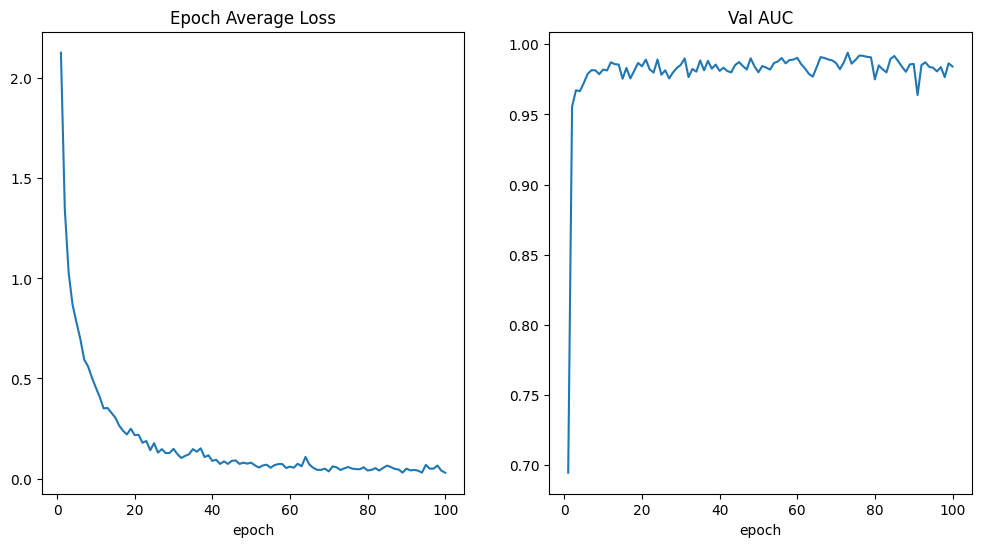

In [78]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [79]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_sagittal.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [80]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8649    0.9275    0.8951        69
           1     0.5882    0.5882    0.5882        68
           2     0.5357    0.4348    0.4800        69
           3     0.6000    0.6000    0.6000        65
           4     0.5806    0.5538    0.5669        65
           5     0.8088    0.8333    0.8209        66
           6     1.0000    0.9643    0.9818        28
           7     0.8667    0.6190    0.7222        21
           8     0.6786    0.9048    0.7755        21
           9     0.7183    0.7391    0.7286        69
          10     0.7895    0.8696    0.8276        69

    accuracy                         0.7115       610
   macro avg     0.7301    0.7304    0.7261       610
weighted avg     0.7070    0.7115    0.7069       610



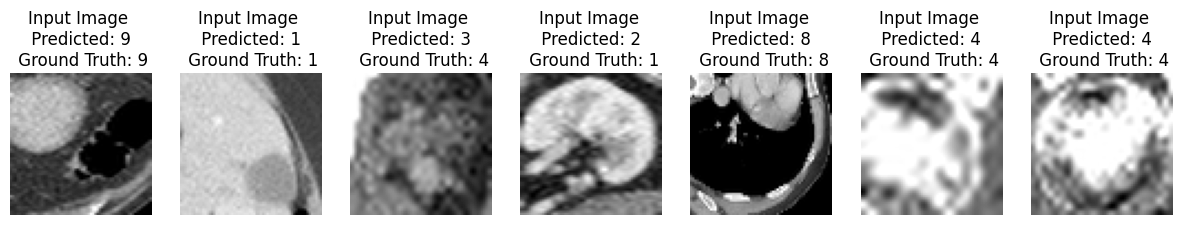

In [81]:
def plot_examples(images, preds, labels, n=5):
    plt.figure(figsize=(15, n))
    for i in range(n):
        j = np.random.randint(0, len(images))
        plt.subplot(1, n, i + 1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Input Image \n Predicted: {preds[j]} \n Ground Truth: {labels[j]}")
        plt.axis('off')

    plt.show()

plot_examples(example_sagittal[1], example_preds[1], example_labels[1], n=7)

## Unpretrained

In [82]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.00005)
max_epochs = 100
val_interval = 1
auc_metric = ROCAUCMetric()

In [83]:
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
writer = SummaryWriter()

for epoch in tqdm(range(max_epochs), desc="Epochs"):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    # batch_iter = tqdm(train_loader, desc="Training Batches", leave=False)
    
    for batch_data in train_loader:
        step += 1
        images, labels = batch_data['images'], batch_data['label'][:, 0].type(torch.LongTensor).to(device)
        axial, coronal, sagittal = images
        optimizer.zero_grad()
        outputs = model(sagittal.to(device))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_dataset) // train_loader.batch_size
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        batch_iter.set_postfix(train_loss=loss.item())
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            y_pred = torch.tensor([], dtype=torch.float32, device=device)
            y = torch.tensor([], dtype=torch.long, device=device)
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data['images'],
                    val_data['label'][:, 0].type(torch.LongTensor).to(device),
                )
                val_axial, val_coronal, val_sagittal = val_images
                y_pred = torch.cat([y_pred, model(val_sagittal.to(device))], dim=0)
                y = torch.cat([y, val_labels], dim=0)
            y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
            print('1')
            y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
            auc_metric(y_pred_act, y_onehot)
            result = auc_metric.aggregate()
            auc_metric.reset()
            del y_pred_act, y_onehot
            metric_values.append(result)
            acc_value = torch.eq(y_pred.argmax(dim=1), y)
            acc_metric = acc_value.sum().item() / len(acc_value)
            if result > best_metric:
                best_metric = result
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model_sagittal.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current AUC: {result:.4f}"
                f" current accuracy: {acc_metric:.4f}"
                f" best AUC: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
            writer.add_scalar("val_accuracy", acc_metric, epoch + 1)

print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
writer.close()

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

----------
epoch 1/100
epoch 1 average loss: 2.0100
1


Epochs:   1%|          | 1/100 [00:07<11:54,  7.22s/it]

saved new best metric model
current epoch: 1 current AUC: 0.6563 current accuracy: 0.0932 best AUC: 0.6563 at epoch: 1
----------
epoch 2/100
epoch 2 average loss: 1.5708
1


Epochs:   2%|▏         | 2/100 [00:14<11:49,  7.24s/it]

saved new best metric model
current epoch: 2 current AUC: 0.9004 current accuracy: 0.4410 best AUC: 0.9004 at epoch: 2
----------
epoch 3/100
epoch 3 average loss: 1.3036
1


Epochs:   3%|▎         | 3/100 [00:21<11:40,  7.22s/it]

saved new best metric model
current epoch: 3 current AUC: 0.9631 current accuracy: 0.5901 best AUC: 0.9631 at epoch: 3
----------
epoch 4/100
epoch 4 average loss: 1.1333
1


Epochs:   4%|▍         | 4/100 [00:28<11:19,  7.07s/it]

current epoch: 4 current AUC: 0.9598 current accuracy: 0.5652 best AUC: 0.9631 at epoch: 3
----------
epoch 5/100
epoch 5 average loss: 1.0420
1


Epochs:   5%|▌         | 5/100 [00:35<11:17,  7.13s/it]

saved new best metric model
current epoch: 5 current AUC: 0.9705 current accuracy: 0.7019 best AUC: 0.9705 at epoch: 5
----------
epoch 6/100
epoch 6 average loss: 0.9003
1


Epochs:   6%|▌         | 6/100 [00:43<11:15,  7.18s/it]

saved new best metric model
current epoch: 6 current AUC: 0.9844 current accuracy: 0.7578 best AUC: 0.9844 at epoch: 6
----------
epoch 7/100
epoch 7 average loss: 0.7942
1


Epochs:   7%|▋         | 7/100 [00:49<10:55,  7.05s/it]

current epoch: 7 current AUC: 0.9799 current accuracy: 0.7516 best AUC: 0.9844 at epoch: 6
----------
epoch 8/100
epoch 8 average loss: 0.7776
1


Epochs:   8%|▊         | 8/100 [00:56<10:42,  6.98s/it]

current epoch: 8 current AUC: 0.9812 current accuracy: 0.7329 best AUC: 0.9844 at epoch: 6
----------
epoch 9/100
epoch 9 average loss: 0.7116
1


Epochs:   9%|▉         | 9/100 [01:04<10:48,  7.13s/it]

saved new best metric model
current epoch: 9 current AUC: 0.9858 current accuracy: 0.7640 best AUC: 0.9858 at epoch: 9
----------
epoch 10/100
epoch 10 average loss: 0.6569
1


Epochs:  10%|█         | 10/100 [01:10<10:33,  7.04s/it]

current epoch: 10 current AUC: 0.9802 current accuracy: 0.7453 best AUC: 0.9858 at epoch: 9
----------
epoch 11/100
epoch 11 average loss: 0.6164
1


Epochs:  11%|█         | 11/100 [01:17<10:19,  6.96s/it]

current epoch: 11 current AUC: 0.9803 current accuracy: 0.7453 best AUC: 0.9858 at epoch: 9
----------
epoch 12/100
epoch 12 average loss: 0.5969
1


Epochs:  12%|█▏        | 12/100 [01:24<10:17,  7.02s/it]

saved new best metric model
current epoch: 12 current AUC: 0.9866 current accuracy: 0.7888 best AUC: 0.9866 at epoch: 12
----------
epoch 13/100
epoch 13 average loss: 0.5589
1


Epochs:  13%|█▎        | 13/100 [01:31<10:05,  6.96s/it]

current epoch: 13 current AUC: 0.9861 current accuracy: 0.7950 best AUC: 0.9866 at epoch: 12
----------
epoch 14/100
epoch 14 average loss: 0.5286
1


Epochs:  14%|█▍        | 14/100 [01:38<09:53,  6.90s/it]

current epoch: 14 current AUC: 0.9855 current accuracy: 0.7391 best AUC: 0.9866 at epoch: 12
----------
epoch 15/100
epoch 15 average loss: 0.4704
1


Epochs:  15%|█▌        | 15/100 [01:45<09:41,  6.85s/it]

current epoch: 15 current AUC: 0.9819 current accuracy: 0.7702 best AUC: 0.9866 at epoch: 12
----------
epoch 16/100
epoch 16 average loss: 0.4685
1


Epochs:  16%|█▌        | 16/100 [01:51<09:33,  6.83s/it]

current epoch: 16 current AUC: 0.9851 current accuracy: 0.7453 best AUC: 0.9866 at epoch: 12
----------
epoch 17/100
epoch 17 average loss: 0.4101
1


Epochs:  17%|█▋        | 17/100 [01:58<09:26,  6.83s/it]

current epoch: 17 current AUC: 0.9864 current accuracy: 0.8137 best AUC: 0.9866 at epoch: 12
----------
epoch 18/100
epoch 18 average loss: 0.4164
1


Epochs:  18%|█▊        | 18/100 [02:05<09:17,  6.80s/it]

current epoch: 18 current AUC: 0.9859 current accuracy: 0.8199 best AUC: 0.9866 at epoch: 12
----------
epoch 19/100
epoch 19 average loss: 0.4092
1


Epochs:  19%|█▉        | 19/100 [02:12<09:20,  6.93s/it]

saved new best metric model
current epoch: 19 current AUC: 0.9894 current accuracy: 0.8323 best AUC: 0.9894 at epoch: 19
----------
epoch 20/100
epoch 20 average loss: 0.3561
1


Epochs:  20%|██        | 20/100 [02:19<09:19,  7.00s/it]

saved new best metric model
current epoch: 20 current AUC: 0.9917 current accuracy: 0.7950 best AUC: 0.9917 at epoch: 20
----------
epoch 21/100
epoch 21 average loss: 0.3429
1


Epochs:  21%|██        | 21/100 [02:26<09:07,  6.93s/it]

current epoch: 21 current AUC: 0.9852 current accuracy: 0.7516 best AUC: 0.9917 at epoch: 20
----------
epoch 22/100
epoch 22 average loss: 0.3355
1


Epochs:  22%|██▏       | 22/100 [02:33<08:59,  6.92s/it]

current epoch: 22 current AUC: 0.9844 current accuracy: 0.7640 best AUC: 0.9917 at epoch: 20
----------
epoch 23/100
epoch 23 average loss: 0.3190
1


Epochs:  23%|██▎       | 23/100 [02:40<08:52,  6.91s/it]

current epoch: 23 current AUC: 0.9893 current accuracy: 0.8199 best AUC: 0.9917 at epoch: 20
----------
epoch 24/100
epoch 24 average loss: 0.2788
1


Epochs:  24%|██▍       | 24/100 [02:47<08:42,  6.88s/it]

current epoch: 24 current AUC: 0.9856 current accuracy: 0.7950 best AUC: 0.9917 at epoch: 20
----------
epoch 25/100
epoch 25 average loss: 0.2814
1


Epochs:  25%|██▌       | 25/100 [02:54<08:35,  6.88s/it]

current epoch: 25 current AUC: 0.9858 current accuracy: 0.8137 best AUC: 0.9917 at epoch: 20
----------
epoch 26/100
epoch 26 average loss: 0.2970
1


Epochs:  26%|██▌       | 26/100 [03:00<08:28,  6.87s/it]

current epoch: 26 current AUC: 0.9856 current accuracy: 0.7888 best AUC: 0.9917 at epoch: 20
----------
epoch 27/100
epoch 27 average loss: 0.2552
1


Epochs:  27%|██▋       | 27/100 [03:07<08:20,  6.86s/it]

current epoch: 27 current AUC: 0.9856 current accuracy: 0.8075 best AUC: 0.9917 at epoch: 20
----------
epoch 28/100
epoch 28 average loss: 0.2294
1


Epochs:  28%|██▊       | 28/100 [03:14<08:11,  6.83s/it]

current epoch: 28 current AUC: 0.9804 current accuracy: 0.8199 best AUC: 0.9917 at epoch: 20
----------
epoch 29/100
epoch 29 average loss: 0.1870
1


Epochs:  29%|██▉       | 29/100 [03:21<08:06,  6.85s/it]

current epoch: 29 current AUC: 0.9903 current accuracy: 0.8571 best AUC: 0.9917 at epoch: 20
----------
epoch 30/100
epoch 30 average loss: 0.1766
1


Epochs:  30%|███       | 30/100 [03:28<07:58,  6.84s/it]

current epoch: 30 current AUC: 0.9915 current accuracy: 0.8509 best AUC: 0.9917 at epoch: 20
----------
epoch 31/100
epoch 31 average loss: 0.2160
1


Epochs:  31%|███       | 31/100 [03:35<07:51,  6.84s/it]

current epoch: 31 current AUC: 0.9901 current accuracy: 0.8385 best AUC: 0.9917 at epoch: 20
----------
epoch 32/100
epoch 32 average loss: 0.2109
1


Epochs:  32%|███▏      | 32/100 [03:41<07:44,  6.83s/it]

current epoch: 32 current AUC: 0.9915 current accuracy: 0.8820 best AUC: 0.9917 at epoch: 20
----------
epoch 33/100
epoch 33 average loss: 0.1678
1


Epochs:  33%|███▎      | 33/100 [03:48<07:37,  6.82s/it]

current epoch: 33 current AUC: 0.9865 current accuracy: 0.8199 best AUC: 0.9917 at epoch: 20
----------
epoch 34/100
epoch 34 average loss: 0.2201
1


Epochs:  34%|███▍      | 34/100 [03:55<07:30,  6.83s/it]

current epoch: 34 current AUC: 0.9906 current accuracy: 0.8137 best AUC: 0.9917 at epoch: 20
----------
epoch 35/100
epoch 35 average loss: 0.1901
1


Epochs:  35%|███▌      | 35/100 [04:02<07:27,  6.88s/it]

current epoch: 35 current AUC: 0.9908 current accuracy: 0.8199 best AUC: 0.9917 at epoch: 20
----------
epoch 36/100
epoch 36 average loss: 0.1871
1


Epochs:  36%|███▌      | 36/100 [04:09<07:18,  6.85s/it]

current epoch: 36 current AUC: 0.9899 current accuracy: 0.8075 best AUC: 0.9917 at epoch: 20
----------
epoch 37/100
epoch 37 average loss: 0.1633
1


Epochs:  37%|███▋      | 37/100 [04:16<07:10,  6.84s/it]

current epoch: 37 current AUC: 0.9848 current accuracy: 0.7888 best AUC: 0.9917 at epoch: 20
----------
epoch 38/100
epoch 38 average loss: 0.1373
1


Epochs:  38%|███▊      | 38/100 [04:22<07:03,  6.83s/it]

current epoch: 38 current AUC: 0.9900 current accuracy: 0.8447 best AUC: 0.9917 at epoch: 20
----------
epoch 39/100
epoch 39 average loss: 0.1356
1


Epochs:  39%|███▉      | 39/100 [04:30<07:03,  6.94s/it]

saved new best metric model
current epoch: 39 current AUC: 0.9925 current accuracy: 0.8385 best AUC: 0.9925 at epoch: 39
----------
epoch 40/100
epoch 40 average loss: 0.1636
1


Epochs:  40%|████      | 40/100 [04:37<07:01,  7.02s/it]

saved new best metric model
current epoch: 40 current AUC: 0.9935 current accuracy: 0.8385 best AUC: 0.9935 at epoch: 40
----------
epoch 41/100
epoch 41 average loss: 0.1631
1


Epochs:  41%|████      | 41/100 [04:44<06:51,  6.97s/it]

current epoch: 41 current AUC: 0.9897 current accuracy: 0.8199 best AUC: 0.9935 at epoch: 40
----------
epoch 42/100
epoch 42 average loss: 0.1531
1


Epochs:  42%|████▏     | 42/100 [04:50<06:39,  6.89s/it]

current epoch: 42 current AUC: 0.9884 current accuracy: 0.8012 best AUC: 0.9935 at epoch: 40
----------
epoch 43/100
epoch 43 average loss: 0.2028
1


Epochs:  43%|████▎     | 43/100 [04:57<06:34,  6.91s/it]

current epoch: 43 current AUC: 0.9932 current accuracy: 0.8758 best AUC: 0.9935 at epoch: 40
----------
epoch 44/100
epoch 44 average loss: 0.1894
1


Epochs:  44%|████▍     | 44/100 [05:04<06:26,  6.90s/it]

current epoch: 44 current AUC: 0.9859 current accuracy: 0.7950 best AUC: 0.9935 at epoch: 40
----------
epoch 45/100
epoch 45 average loss: 0.1629
1


Epochs:  45%|████▌     | 45/100 [05:11<06:17,  6.87s/it]

current epoch: 45 current AUC: 0.9912 current accuracy: 0.8385 best AUC: 0.9935 at epoch: 40
----------
epoch 46/100
epoch 46 average loss: 0.1546
1


Epochs:  46%|████▌     | 46/100 [05:18<06:18,  7.00s/it]

saved new best metric model
current epoch: 46 current AUC: 0.9935 current accuracy: 0.8820 best AUC: 0.9935 at epoch: 46
----------
epoch 47/100
epoch 47 average loss: 0.1398
1


Epochs:  47%|████▋     | 47/100 [05:25<06:07,  6.94s/it]

current epoch: 47 current AUC: 0.9920 current accuracy: 0.8323 best AUC: 0.9935 at epoch: 46
----------
epoch 48/100
epoch 48 average loss: 0.1214
1


Epochs:  48%|████▊     | 48/100 [05:32<05:58,  6.90s/it]

current epoch: 48 current AUC: 0.9920 current accuracy: 0.8385 best AUC: 0.9935 at epoch: 46
----------
epoch 49/100
epoch 49 average loss: 0.1295
1


Epochs:  49%|████▉     | 49/100 [05:39<05:50,  6.88s/it]

current epoch: 49 current AUC: 0.9890 current accuracy: 0.8385 best AUC: 0.9935 at epoch: 46
----------
epoch 50/100
epoch 50 average loss: 0.1250
1


Epochs:  50%|█████     | 50/100 [05:46<05:43,  6.87s/it]

current epoch: 50 current AUC: 0.9911 current accuracy: 0.8447 best AUC: 0.9935 at epoch: 46
----------
epoch 51/100
epoch 51 average loss: 0.1270
1


Epochs:  51%|█████     | 51/100 [05:52<05:35,  6.84s/it]

current epoch: 51 current AUC: 0.9909 current accuracy: 0.8571 best AUC: 0.9935 at epoch: 46
----------
epoch 52/100
epoch 52 average loss: 0.1106
1


Epochs:  52%|█████▏    | 52/100 [05:59<05:27,  6.83s/it]

current epoch: 52 current AUC: 0.9842 current accuracy: 0.8509 best AUC: 0.9935 at epoch: 46
----------
epoch 53/100
epoch 53 average loss: 0.0969
1


Epochs:  53%|█████▎    | 53/100 [06:06<05:20,  6.82s/it]

current epoch: 53 current AUC: 0.9926 current accuracy: 0.8509 best AUC: 0.9935 at epoch: 46
----------
epoch 54/100
epoch 54 average loss: 0.1078
1


Epochs:  54%|█████▍    | 54/100 [06:13<05:20,  6.96s/it]

saved new best metric model
current epoch: 54 current AUC: 0.9940 current accuracy: 0.8571 best AUC: 0.9940 at epoch: 54
----------
epoch 55/100
epoch 55 average loss: 0.1503
1


Epochs:  55%|█████▌    | 55/100 [06:20<05:11,  6.92s/it]

current epoch: 55 current AUC: 0.9933 current accuracy: 0.8012 best AUC: 0.9940 at epoch: 54
----------
epoch 56/100
epoch 56 average loss: 0.1280
1


Epochs:  56%|█████▌    | 56/100 [06:27<05:08,  7.01s/it]

saved new best metric model
current epoch: 56 current AUC: 0.9944 current accuracy: 0.8634 best AUC: 0.9944 at epoch: 56
----------
epoch 57/100
epoch 57 average loss: 0.1133
1


Epochs:  57%|█████▋    | 57/100 [06:34<04:58,  6.95s/it]

current epoch: 57 current AUC: 0.9862 current accuracy: 0.8075 best AUC: 0.9944 at epoch: 56
----------
epoch 58/100
epoch 58 average loss: 0.1319
1


Epochs:  58%|█████▊    | 58/100 [06:41<04:50,  6.91s/it]

current epoch: 58 current AUC: 0.9910 current accuracy: 0.8447 best AUC: 0.9944 at epoch: 56
----------
epoch 59/100
epoch 59 average loss: 0.1064
1


Epochs:  59%|█████▉    | 59/100 [06:48<04:47,  7.01s/it]

saved new best metric model
current epoch: 59 current AUC: 0.9949 current accuracy: 0.8509 best AUC: 0.9949 at epoch: 59
----------
epoch 60/100
epoch 60 average loss: 0.0937
1


Epochs:  60%|██████    | 60/100 [06:55<04:37,  6.95s/it]

current epoch: 60 current AUC: 0.9916 current accuracy: 0.8634 best AUC: 0.9949 at epoch: 59
----------
epoch 61/100
epoch 61 average loss: 0.0929
1


Epochs:  61%|██████    | 61/100 [07:02<04:29,  6.91s/it]

current epoch: 61 current AUC: 0.9939 current accuracy: 0.8758 best AUC: 0.9949 at epoch: 59
----------
epoch 62/100
epoch 62 average loss: 0.0848
1


Epochs:  62%|██████▏   | 62/100 [07:09<04:22,  6.92s/it]

current epoch: 62 current AUC: 0.9921 current accuracy: 0.8323 best AUC: 0.9949 at epoch: 59
----------
epoch 63/100
epoch 63 average loss: 0.0965
1


Epochs:  63%|██████▎   | 63/100 [07:16<04:15,  6.90s/it]

current epoch: 63 current AUC: 0.9941 current accuracy: 0.8820 best AUC: 0.9949 at epoch: 59
----------
epoch 64/100
epoch 64 average loss: 0.1079
1


Epochs:  64%|██████▍   | 64/100 [07:22<04:06,  6.86s/it]

current epoch: 64 current AUC: 0.9902 current accuracy: 0.8261 best AUC: 0.9949 at epoch: 59
----------
epoch 65/100
epoch 65 average loss: 0.0973
1


Epochs:  65%|██████▌   | 65/100 [07:29<04:00,  6.87s/it]

current epoch: 65 current AUC: 0.9897 current accuracy: 0.8199 best AUC: 0.9949 at epoch: 59
----------
epoch 66/100
epoch 66 average loss: 0.0963
1


Epochs:  66%|██████▌   | 66/100 [07:36<03:54,  6.89s/it]

current epoch: 66 current AUC: 0.9872 current accuracy: 0.7888 best AUC: 0.9949 at epoch: 59
----------
epoch 67/100
epoch 67 average loss: 0.0994
1


Epochs:  67%|██████▋   | 67/100 [07:43<03:46,  6.87s/it]

current epoch: 67 current AUC: 0.9896 current accuracy: 0.8385 best AUC: 0.9949 at epoch: 59
----------
epoch 68/100
epoch 68 average loss: 0.0983
1


Epochs:  68%|██████▊   | 68/100 [07:50<03:39,  6.85s/it]

current epoch: 68 current AUC: 0.9919 current accuracy: 0.8447 best AUC: 0.9949 at epoch: 59
----------
epoch 69/100
epoch 69 average loss: 0.0813
1


Epochs:  69%|██████▉   | 69/100 [07:57<03:31,  6.83s/it]

current epoch: 69 current AUC: 0.9899 current accuracy: 0.8323 best AUC: 0.9949 at epoch: 59
----------
epoch 70/100
epoch 70 average loss: 0.0919
1


Epochs:  70%|███████   | 70/100 [08:03<03:24,  6.81s/it]

current epoch: 70 current AUC: 0.9862 current accuracy: 0.7826 best AUC: 0.9949 at epoch: 59
----------
epoch 71/100
epoch 71 average loss: 0.0909
1


Epochs:  71%|███████   | 71/100 [08:10<03:17,  6.82s/it]

current epoch: 71 current AUC: 0.9839 current accuracy: 0.7888 best AUC: 0.9949 at epoch: 59
----------
epoch 72/100
epoch 72 average loss: 0.0858
1


Epochs:  72%|███████▏  | 72/100 [08:17<03:11,  6.84s/it]

current epoch: 72 current AUC: 0.9880 current accuracy: 0.8385 best AUC: 0.9949 at epoch: 59
----------
epoch 73/100
epoch 73 average loss: 0.0873
1


Epochs:  73%|███████▎  | 73/100 [08:24<03:04,  6.82s/it]

current epoch: 73 current AUC: 0.9885 current accuracy: 0.8323 best AUC: 0.9949 at epoch: 59
----------
epoch 74/100
epoch 74 average loss: 0.0659
1


Epochs:  74%|███████▍  | 74/100 [08:31<02:57,  6.83s/it]

current epoch: 74 current AUC: 0.9871 current accuracy: 0.7702 best AUC: 0.9949 at epoch: 59
----------
epoch 75/100
epoch 75 average loss: 0.0710
1


Epochs:  75%|███████▌  | 75/100 [08:38<02:50,  6.82s/it]

current epoch: 75 current AUC: 0.9869 current accuracy: 0.7888 best AUC: 0.9949 at epoch: 59
----------
epoch 76/100
epoch 76 average loss: 0.0681
1


Epochs:  76%|███████▌  | 76/100 [08:44<02:43,  6.80s/it]

current epoch: 76 current AUC: 0.9881 current accuracy: 0.8137 best AUC: 0.9949 at epoch: 59
----------
epoch 77/100
epoch 77 average loss: 0.0718
1


Epochs:  77%|███████▋  | 77/100 [08:51<02:36,  6.80s/it]

current epoch: 77 current AUC: 0.9886 current accuracy: 0.8323 best AUC: 0.9949 at epoch: 59
----------
epoch 78/100
epoch 78 average loss: 0.0580
1


Epochs:  78%|███████▊  | 78/100 [08:58<02:29,  6.77s/it]

current epoch: 78 current AUC: 0.9883 current accuracy: 0.8447 best AUC: 0.9949 at epoch: 59
----------
epoch 79/100
epoch 79 average loss: 0.0733
1


Epochs:  79%|███████▉  | 79/100 [09:05<02:22,  6.80s/it]

current epoch: 79 current AUC: 0.9811 current accuracy: 0.8012 best AUC: 0.9949 at epoch: 59
----------
epoch 80/100
epoch 80 average loss: 0.0783
1


Epochs:  80%|████████  | 80/100 [09:12<02:15,  6.80s/it]

current epoch: 80 current AUC: 0.9887 current accuracy: 0.8385 best AUC: 0.9949 at epoch: 59
----------
epoch 81/100
epoch 81 average loss: 0.0747
1


Epochs:  81%|████████  | 81/100 [09:18<02:09,  6.79s/it]

current epoch: 81 current AUC: 0.9903 current accuracy: 0.8509 best AUC: 0.9949 at epoch: 59
----------
epoch 82/100
epoch 82 average loss: 0.0879
1


Epochs:  82%|████████▏ | 82/100 [09:25<02:02,  6.81s/it]

current epoch: 82 current AUC: 0.9854 current accuracy: 0.8323 best AUC: 0.9949 at epoch: 59
----------
epoch 83/100
epoch 83 average loss: 0.0811
1


Epochs:  83%|████████▎ | 83/100 [09:32<01:55,  6.80s/it]

current epoch: 83 current AUC: 0.9874 current accuracy: 0.8323 best AUC: 0.9949 at epoch: 59
----------
epoch 84/100
epoch 84 average loss: 0.0598
1


Epochs:  84%|████████▍ | 84/100 [09:39<01:48,  6.80s/it]

current epoch: 84 current AUC: 0.9887 current accuracy: 0.8385 best AUC: 0.9949 at epoch: 59
----------
epoch 85/100
epoch 85 average loss: 0.0592
1


Epochs:  85%|████████▌ | 85/100 [09:46<01:42,  6.81s/it]

current epoch: 85 current AUC: 0.9887 current accuracy: 0.8261 best AUC: 0.9949 at epoch: 59
----------
epoch 86/100
epoch 86 average loss: 0.0852
1


Epochs:  86%|████████▌ | 86/100 [09:52<01:35,  6.81s/it]

current epoch: 86 current AUC: 0.9843 current accuracy: 0.8323 best AUC: 0.9949 at epoch: 59
----------
epoch 87/100
epoch 87 average loss: 0.0752
1


Epochs:  87%|████████▋ | 87/100 [09:59<01:28,  6.81s/it]

current epoch: 87 current AUC: 0.9833 current accuracy: 0.8199 best AUC: 0.9949 at epoch: 59
----------
epoch 88/100
epoch 88 average loss: 0.0744
1


Epochs:  88%|████████▊ | 88/100 [10:06<01:21,  6.82s/it]

current epoch: 88 current AUC: 0.9859 current accuracy: 0.8199 best AUC: 0.9949 at epoch: 59
----------
epoch 89/100
epoch 89 average loss: 0.0837
1


Epochs:  89%|████████▉ | 89/100 [10:13<01:15,  6.84s/it]

current epoch: 89 current AUC: 0.9829 current accuracy: 0.8137 best AUC: 0.9949 at epoch: 59
----------
epoch 90/100
epoch 90 average loss: 0.0830
1


Epochs:  90%|█████████ | 90/100 [10:20<01:08,  6.85s/it]

current epoch: 90 current AUC: 0.9859 current accuracy: 0.8323 best AUC: 0.9949 at epoch: 59
----------
epoch 91/100
epoch 91 average loss: 0.0532
1


Epochs:  91%|█████████ | 91/100 [10:27<01:01,  6.83s/it]

current epoch: 91 current AUC: 0.9837 current accuracy: 0.8385 best AUC: 0.9949 at epoch: 59
----------
epoch 92/100
epoch 92 average loss: 0.0772
1


Epochs:  92%|█████████▏| 92/100 [10:33<00:54,  6.85s/it]

current epoch: 92 current AUC: 0.9819 current accuracy: 0.7950 best AUC: 0.9949 at epoch: 59
----------
epoch 93/100
epoch 93 average loss: 0.0715
1


Epochs:  93%|█████████▎| 93/100 [10:40<00:47,  6.84s/it]

current epoch: 93 current AUC: 0.9827 current accuracy: 0.8075 best AUC: 0.9949 at epoch: 59
----------
epoch 94/100
epoch 94 average loss: 0.0572
1


Epochs:  94%|█████████▍| 94/100 [10:47<00:41,  6.83s/it]

current epoch: 94 current AUC: 0.9853 current accuracy: 0.8447 best AUC: 0.9949 at epoch: 59
----------
epoch 95/100
epoch 95 average loss: 0.0537
1


Epochs:  95%|█████████▌| 95/100 [10:54<00:34,  6.81s/it]

current epoch: 95 current AUC: 0.9846 current accuracy: 0.7950 best AUC: 0.9949 at epoch: 59
----------
epoch 96/100
epoch 96 average loss: 0.0515
1


Epochs:  96%|█████████▌| 96/100 [11:01<00:27,  6.81s/it]

current epoch: 96 current AUC: 0.9862 current accuracy: 0.8012 best AUC: 0.9949 at epoch: 59
----------
epoch 97/100
epoch 97 average loss: 0.0400
1


Epochs:  97%|█████████▋| 97/100 [11:07<00:20,  6.81s/it]

current epoch: 97 current AUC: 0.9847 current accuracy: 0.8137 best AUC: 0.9949 at epoch: 59
----------
epoch 98/100
epoch 98 average loss: 0.0589
1


Epochs:  98%|█████████▊| 98/100 [11:14<00:13,  6.82s/it]

current epoch: 98 current AUC: 0.9798 current accuracy: 0.7702 best AUC: 0.9949 at epoch: 59
----------
epoch 99/100
epoch 99 average loss: 0.0558
1


Epochs:  99%|█████████▉| 99/100 [11:21<00:06,  6.85s/it]

current epoch: 99 current AUC: 0.9869 current accuracy: 0.8323 best AUC: 0.9949 at epoch: 59
----------
epoch 100/100
epoch 100 average loss: 0.0677
1


Epochs: 100%|██████████| 100/100 [11:28<00:00,  6.88s/it]

current epoch: 100 current AUC: 0.9849 current accuracy: 0.8385 best AUC: 0.9949 at epoch: 59
train completed, best_metric: 0.9949 at epoch: 59


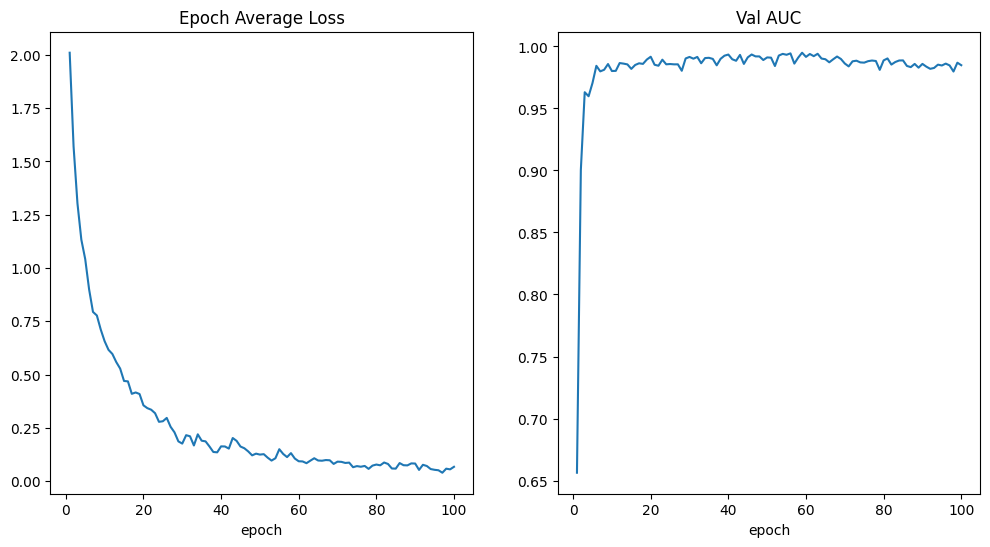

In [84]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

### Evaluation

In [85]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))
model.eval()
y_true = []
y_pred = []
example_axial = []
example_coronal = []
example_sagittal = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        pred = model(test_axial.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_axial.append(test_axial)
            example_coronal.append(test_coronal)
            example_sagittal.append(test_sagittal)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [86]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.5556    0.3623    0.4386        69
           1     0.3295    0.4265    0.3718        68
           2     0.1364    0.0435    0.0659        69
           3     0.5000    0.4000    0.4444        65
           4     0.4286    0.2308    0.3000        65
           5     0.3900    0.5909    0.4699        66
           6     0.3636    0.1429    0.2051        28
           7     0.4091    0.4286    0.4186        21
           8     0.4000    0.0952    0.1538        21
           9     0.2612    0.5072    0.3448        69
          10     0.2708    0.3768    0.3152        69

    accuracy                         0.3492       610
   macro avg     0.3677    0.3277    0.3207       610
weighted avg     0.3609    0.3492    0.3325       610



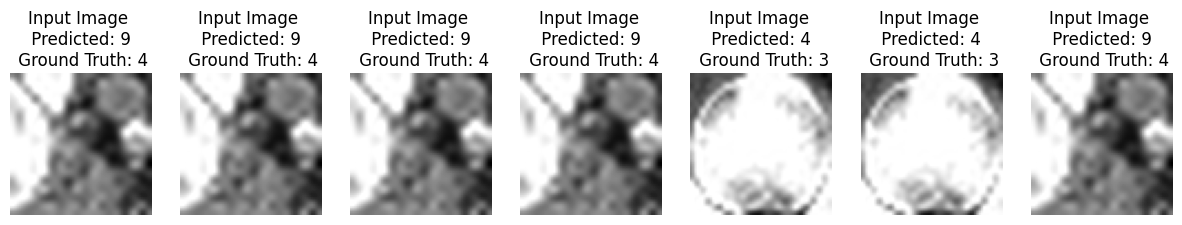

In [87]:
plot_examples(test_sagittal, pred, test_labels, n=7)

## 3D slices evaluation

In [88]:
class Sliced_Dataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, label = self.dataset[idx]

        if self.transform:
            data = self.transform(data)

        axial, coronal, sagittal = self.get_middle_slices(data)

        data = {'axial': axial, 'coronal': coronal, 'sagittal': sagittal}
        
        return {'images': (data['axial'], data['coronal'], data['sagittal']), 'label': label}

    @staticmethod
    def get_middle_slices(data):
        dims = data.shape
        axial, coronal, sagittal = [], [], []
        middle_idx = [dims[i] // 2 for i in range(0, 4)]
        
        for d in range(3):  # 0 - Axial, 1 - Coronal, 2 - Sagittal
            start_idx = middle_idx[d] - 4  # Start 4 slices before the middle
            end_idx = middle_idx[d] + 5    # End 4 slices after the middle
            
            for i in range(start_idx, end_idx):
                if d == 0:
                    axial.append(data[:, i, :, :])
                elif d == 1:
                    coronal.append(data[:, :, i, :])
                elif d == 2:
                    sagittal.append(data[:, :, :, i])
        
        return axial, coronal, sagittal

In [89]:
train_dataset_ = Sliced_Dataset(train_dataset, transform=train_transforms)
val_dataset_ = Sliced_Dataset(val_dataset, transform=val_transforms)
test_dataset_ = Sliced_Dataset(test_dataset, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset_, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset_, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset_, batch_size=BATCH_SIZE, shuffle=False)

## Pretrained

In [90]:
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)


model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"), weights_only=True))
model_axial.eval()

model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"), weights_only=True))
model_coronal.eval()

model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"), weights_only=True))
model_sagittal.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        for i in range(9):
            pred_axial = model_axial(test_axial[i].to(device)).argmax(dim=1)
            pred_coronal = model_coronal(test_coronal[i].to(device)).argmax(dim=1)
            pred_sagittal = model_sagittal(test_sagittal[i].to(device)).argmax(dim=1)
            if i != 0:
                pred = torch.cat((pred, torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)))
            else:
                pred = torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)
        
        for i in range(pred.shape[1]):
            data = pred[:, i]
            counts = torch.bincount(data)
            most_frequent_value = torch.argmax(counts).item()
            
            y_true.append(test_labels[i].item())
            y_pred.append(most_frequent_value)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [91]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.8852    0.7826    0.8308        69
           1     0.5345    0.4559    0.4921        68
           2     0.4808    0.3623    0.4132        69
           3     0.5610    0.3538    0.4340        65
           4     0.5593    0.5077    0.5323        65
           5     0.6176    0.9545    0.7500        66
           6     1.0000    0.8214    0.9020        28
           7     0.8333    0.4762    0.6061        21
           8     0.6207    0.8571    0.7200        21
           9     0.6667    0.8986    0.7654        69
          10     0.8000    0.9275    0.8591        69

    accuracy                         0.6656       610
   macro avg     0.6872    0.6725    0.6641       610
weighted avg     0.6622    0.6656    0.6505       610



## Unpretrained

In [92]:
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_axial.eval()
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_coronal.eval()
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))
model_sagittal.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for test_data in test_loader:
        test_images, test_labels = (
            test_data['images'],
            test_data['label'][:, 0].type(torch.LongTensor).to(device),
        )
        test_axial, test_coronal, test_sagittal = test_images
        for i in range(9):
            pred_axial = model_axial(test_axial[i].to(device)).argmax(dim=1)
            pred_coronal = model_coronal(test_coronal[i].to(device)).argmax(dim=1)
            pred_sagittal = model_sagittal(test_sagittal[i].to(device)).argmax(dim=1)
            if i != 0:
                pred = torch.cat((pred, torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)))
            else:
                pred = torch.stack((pred_axial, pred_coronal, pred_sagittal), axis = 0)
        
        for i in range(pred.shape[1]):
            data = pred[:, i]
            counts = torch.bincount(data)
            most_frequent_value = torch.argmax(counts).item()
            
            y_true.append(test_labels[i].item())
            y_pred.append(most_frequent_value)

In [93]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9444    0.9855    0.9645        69
           1     0.5897    0.6765    0.6301        68
           2     0.7500    0.3478    0.4752        69
           3     0.5579    0.8154    0.6625        65
           4     0.6486    0.3692    0.4706        65
           5     0.8630    0.9545    0.9065        66
           6     1.0000    0.8571    0.9231        28
           7     0.8750    1.0000    0.9333        21
           8     1.0000    0.8571    0.9231        21
           9     0.7000    0.9130    0.7925        69
          10     0.9104    0.8841    0.8971        69

    accuracy                         0.7623       610
   macro avg     0.8036    0.7873    0.7799       610
weighted avg     0.7720    0.7623    0.7493       610



# Using 2d models as a backbone

In [94]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))

<All keys matched successfully>

In [95]:
class CombinedResNetModel(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=n_classes):
        super(CombinedResNetModel, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])

        # Assuming each model outputs a 512-dimension feature vector (from ResNet18)
        combined_feature_size = 512 * 3  # Concatenating features from all three directions
        
        # Final fully connected layer to classify the combined features
        self.fc = nn.Linear(combined_feature_size, num_classes)

    def forward(self, x):
        
        axial_slice = x[:, :, x.shape[2] // 2, :, :].to(torch.float32)
        coronal_slice = x[:, :, :, x.shape[3] // 2, :].to(torch.float32)
        sagittal_slice = x[:, :, :, :, x.shape[4] // 2].to(torch.float32)

        # Get features from the respective models
        axial_features = self.model_axial(axial_slice).flatten(1)
        coronal_features = self.model_coronal(coronal_slice).flatten(1)
        sagittal_features = self.model_sagittal(sagittal_slice).flatten(1)

        # Concatenate the features from all three slices
        combined_features = torch.cat([axial_features, coronal_features, sagittal_features], dim=1)

        # Final classification
        out = self.fc(combined_features)
        return out

## Evaluation on a 3d dataset

In [96]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [97]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [98]:
for epoch in range(30):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.2312430912448513
Epoch 2, Loss: 1.421457217585656
Epoch 3, Loss: 0.922661877447559
Epoch 4, Loss: 0.6472801921829101
Epoch 5, Loss: 0.45579215595799105
Epoch 6, Loss: 0.3697362450822707
Epoch 7, Loss: 0.2796674947584829
Epoch 8, Loss: 0.24498080534319724
Epoch 9, Loss: 0.21896092834011202
Epoch 10, Loss: 0.1828131980953678
Epoch 11, Loss: 0.16094289239375822
Epoch 12, Loss: 0.14291496839254134
Epoch 13, Loss: 0.1332861322068399
Epoch 14, Loss: 0.12199729993458718
Epoch 15, Loss: 0.11563054496242155
Epoch 16, Loss: 0.10485555928560995
Epoch 17, Loss: 0.10262967754275568
Epoch 18, Loss: 0.09630265062855135
Epoch 19, Loss: 0.08798556089881927
Epoch 20, Loss: 0.0789409639133561
Epoch 21, Loss: 0.07574334302015844
Epoch 22, Loss: 0.07293778381520702
Epoch 23, Loss: 0.0698364801224201
Epoch 24, Loss: 0.06811184351963381
Epoch 25, Loss: 0.06529827656284455
Epoch 26, Loss: 0.06125469535829559
Epoch 27, Loss: 0.05333068347986667
Epoch 28, Loss: 0.0587595610488807
Epoch 29, Loss

In [99]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9973, Accuracy: 14.7019


In [100]:
combined_model.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = combined_model(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [101]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9444    0.9855    0.9645        69
           1     0.6250    0.6618    0.6429        68
           2     0.6250    0.5072    0.5600        69
           3     0.5802    0.7231    0.6438        65
           4     0.5893    0.5077    0.5455        65
           5     0.9833    0.8939    0.9365        66
           6     1.0000    0.8929    0.9434        28
           7     1.0000    0.9524    0.9756        21
           8     0.9545    1.0000    0.9767        21
           9     0.8923    0.8406    0.8657        69
          10     0.8148    0.9565    0.8800        69

    accuracy                         0.7820       610
   macro avg     0.8190    0.8111    0.8122       610
weighted avg     0.7845    0.7820    0.7801       610



## Pretrained

In [102]:
train_loader_3d = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_3d = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader_3d = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [103]:
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [104]:
combined_model = CombinedResNetModel(model_axial, model_coronal, model_sagittal, num_classes=n_classes).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(combined_model.fc.parameters(), lr=0.00005)

In [105]:
for epoch in range(30):
    combined_model.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images.to(device), labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = combined_model(images)
        loss = loss_function(outputs, labels[:, 0])

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.209972116254991
Epoch 2, Loss: 1.5391398437561528
Epoch 3, Loss: 1.106486028240573
Epoch 4, Loss: 0.8300667808901879
Epoch 5, Loss: 0.6515264991791018
Epoch 6, Loss: 0.5372383815626944
Epoch 7, Loss: 0.45590533364203667
Epoch 8, Loss: 0.3755879238728554
Epoch 9, Loss: 0.35382200392984575
Epoch 10, Loss: 0.28915675417069464
Epoch 11, Loss: 0.2718480714867192
Epoch 12, Loss: 0.2541493367283575
Epoch 13, Loss: 0.22152516101637193
Epoch 14, Loss: 0.20836776134467894
Epoch 15, Loss: 0.18629736933977373
Epoch 16, Loss: 0.16857336725919478
Epoch 17, Loss: 0.15773695947662478
Epoch 18, Loss: 0.14726027125312435
Epoch 19, Loss: 0.14188698583072232
Epoch 20, Loss: 0.12650460437420877
Epoch 21, Loss: 0.12512190880313998
Epoch 22, Loss: 0.1142291289664084
Epoch 23, Loss: 0.1082615751412607
Epoch 24, Loss: 0.10035355317015801
Epoch 25, Loss: 0.10530646181394977
Epoch 26, Loss: 0.09537249022433834
Epoch 27, Loss: 0.10398807604947398
Epoch 28, Loss: 0.09979269533388076
Epoch 29, Loss

In [106]:
combined_model.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = combined_model(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9975, Accuracy: 14.6708


In [107]:
combined_model.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = combined_model(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [108]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9286    0.9420    0.9353        69
           1     0.5714    0.6471    0.6069        68
           2     0.5231    0.4928    0.5075        69
           3     0.6081    0.6923    0.6475        65
           4     0.6604    0.5385    0.5932        65
           5     0.9118    0.9394    0.9254        66
           6     1.0000    0.9286    0.9630        28
           7     0.9048    0.9048    0.9048        21
           8     0.8696    0.9524    0.9091        21
           9     0.8793    0.7391    0.8031        69
          10     0.8533    0.9275    0.8889        69

    accuracy                         0.7623       610
   macro avg     0.7918    0.7913    0.7895       610
weighted avg     0.7647    0.7623    0.7612       610



## Hyper network

In [109]:
class HyperNetwork(nn.Module):
    def __init__(self, model_axial, model_coronal, model_sagittal, num_classes=11):
        super(HyperNetwork, self).__init__()
        
        # Load pretrained 2D models (without their final classification layers)
        self.model_axial = nn.Sequential(*list(model_axial.children())[:-1])
        self.model_coronal = nn.Sequential(*list(model_coronal.children())[:-1])
        self.model_sagittal = nn.Sequential(*list(model_sagittal.children())[:-1])
        
        # Hypernetwork for weighting the features
        self.hyper_fc = nn.Sequential(
            nn.Linear(512 * 3, 256),  # Adjust based on feature size
            nn.ReLU(),
            nn.Linear(256, 512 * 3),
            nn.Sigmoid()
        )
        
        # Final classification layer
        self.fc = nn.Linear(512 * 3, num_classes)

    def forward(self, x):
        
        axial_slice = x[:, :, x.shape[2] // 2, :, :].to(torch.float32)
        coronal_slice = x[:, :, :, x.shape[3] // 2, :].to(torch.float32)
        sagittal_slice = x[:, :, :, :, x.shape[4] // 2].to(torch.float32)
        
        features_axial = self.model_axial(axial_slice).flatten(1)
        features_coronal = self.model_coronal(coronal_slice).flatten(1)
        features_sagittal = self.model_sagittal(sagittal_slice).flatten(1)
        
        combined_features = torch.cat([features_axial, features_coronal, features_sagittal], dim=1)
        
        # Apply hypernetwork to decide weights
        weights = self.hyper_fc(combined_features)
        combined_weighted_features = combined_features * weights
        
        # Final classification
        out = self.fc(combined_weighted_features)
        return out

In [110]:
# Load the pretrained models for each slice direction
model_axial = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_coronal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)
model_sagittal = nets.resnet18(pretrained=False, spatial_dims=2, n_input_channels=1, num_classes=n_classes).to(device)

# Load the trained weights for each model
model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal.pth"), weights_only=True))

<All keys matched successfully>

In [111]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [112]:
for epoch in range(30):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.1992361584017353
Epoch 2, Loss: 1.7598386080034318
Epoch 3, Loss: 1.4035456372845558
Epoch 4, Loss: 1.1226484294860595
Epoch 5, Loss: 0.8967698004937941
Epoch 6, Loss: 0.7375160667204088
Epoch 7, Loss: 0.6257494784170582
Epoch 8, Loss: 0.538525979365072
Epoch 9, Loss: 0.4689262730460013
Epoch 10, Loss: 0.41023298136649594
Epoch 11, Loss: 0.3654448832235029
Epoch 12, Loss: 0.31974188454689517
Epoch 13, Loss: 0.29247157227608467
Epoch 14, Loss: 0.2750833462322912
Epoch 15, Loss: 0.2367192876915778
Epoch 16, Loss: 0.22779082242519624
Epoch 17, Loss: 0.2001585167261862
Epoch 18, Loss: 0.19408177896853415
Epoch 19, Loss: 0.18026458832525438
Epoch 20, Loss: 0.17006470118799516
Epoch 21, Loss: 0.16055732124274777
Epoch 22, Loss: 0.1524661344385916
Epoch 23, Loss: 0.15138765640797153
Epoch 24, Loss: 0.1312374520686365
Epoch 25, Loss: 0.1263259990561393
Epoch 26, Loss: 0.12087722723522494
Epoch 27, Loss: 0.1171155646443367
Epoch 28, Loss: 0.10788286261020168
Epoch 29, Loss: 0.1

In [113]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9971, Accuracy: 14.7205


In [114]:
hypernetwork.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = hypernetwork(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [115]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9577    0.9855    0.9714        69
           1     0.6029    0.6029    0.6029        68
           2     0.6034    0.5072    0.5512        69
           3     0.5694    0.6308    0.5985        65
           4     0.5455    0.5538    0.5496        65
           5     0.9531    0.9242    0.9385        66
           6     1.0000    0.8929    0.9434        28
           7     1.0000    1.0000    1.0000        21
           8     1.0000    1.0000    1.0000        21
           9     0.8806    0.8551    0.8676        69
          10     0.8442    0.9420    0.8904        69

    accuracy                         0.7754       610
   macro avg     0.8143    0.8086    0.8103       610
weighted avg     0.7756    0.7754    0.7743       610



## Pretrained

In [116]:
model = models.resnet18(pretrained=True).to(device)
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(model.fc.in_features, n_classes)
model_axial = model.to(device)
model_coronal = model.to(device)
model_sagittal = model.to(device)

model_axial.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_axial_pretrained.pth"), weights_only=True))
model_coronal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_coronal_pretrained.pth"), weights_only=True))
model_sagittal.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model_sagittal_pretrained.pth"), weights_only=True))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [117]:
# Initialize the hypernetwork
hypernetwork = HyperNetwork(model_axial, model_coronal, model_sagittal, num_classes=11).to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hypernetwork.fc.parameters(), lr=0.00005)

In [118]:
for epoch in range(30):
    hypernetwork.train()
    running_loss = 0.0
    for data in train_loader_3d:
        images, labels = data
        images, labels = images, labels.type(torch.LongTensor)

        optimizer.zero_grad()

        outputs = hypernetwork(images.to(device))
        loss = loss_function(outputs, labels[:, 0].to(device))

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader_3d)}")

Epoch 1, Loss: 2.320294141769409
Epoch 2, Loss: 1.9302975093164751
Epoch 3, Loss: 1.6248393251049904
Epoch 4, Loss: 1.3602186402966898
Epoch 5, Loss: 1.1579040231243256
Epoch 6, Loss: 0.9927879629596588
Epoch 7, Loss: 0.8538400684633562
Epoch 8, Loss: 0.753643274307251
Epoch 9, Loss: 0.6752755690005517
Epoch 10, Loss: 0.5904088914394379
Epoch 11, Loss: 0.5181801924782414
Epoch 12, Loss: 0.4749601829436518
Epoch 13, Loss: 0.4294242060953571
Epoch 14, Loss: 0.4072332093792577
Epoch 15, Loss: 0.3804048155584643
Epoch 16, Loss: 0.3454054959358708
Epoch 17, Loss: 0.3166822521917282
Epoch 18, Loss: 0.2991942835430945
Epoch 19, Loss: 0.2910392245938701
Epoch 20, Loss: 0.25321460587363087
Epoch 21, Loss: 0.23840012281171738
Epoch 22, Loss: 0.24003998839086102
Epoch 23, Loss: 0.22250783876065286
Epoch 24, Loss: 0.21975779725659278
Epoch 25, Loss: 0.1920144687737188
Epoch 26, Loss: 0.1949321769418255
Epoch 27, Loss: 0.18407361113256024
Epoch 28, Loss: 0.1788940179732538
Epoch 29, Loss: 0.1644312

In [119]:
hypernetwork.eval()
with torch.no_grad():
    y_pred = torch.tensor([], dtype=torch.float32, device=device)
    y = torch.tensor([], dtype=torch.long, device=device)
    for val_data in val_loader_3d:
        val_images, val_labels = val_data

        output = hypernetwork(val_images.to(device))
        
        y_pred = torch.cat([y_pred, output], dim=0)
        y = torch.cat([y, val_labels.to(device)], dim=0)

    # Evaluate AUC and accuracy
    y_onehot = [y_trans(i) for i in decollate_batch(y, detach=False)]
    y_pred_act = [y_pred_trans(i) for i in decollate_batch(y_pred)]
    auc_metric(y_pred_act, y_onehot)
    result = auc_metric.aggregate()
    auc_metric.reset()

    acc_value = torch.eq(y_pred.argmax(dim=1), y)
    acc_metric = acc_value.sum().item() / len(acc_value)

    print(f"Validation AUC: {result:.4f}, Accuracy: {acc_metric:.4f}")

Validation AUC: 0.9941, Accuracy: 14.7143


In [120]:
hypernetwork.eval()
y_true = []
y_pred = []
example_image = []
example_preds = []
example_labels = []

with torch.no_grad():
    for test_data in test_loader_3d:
        test_images, test_labels = test_data
        pred = hypernetwork(test_images.to(device)).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

        if len(example_axial) < 10:
            example_image.append(test_images)
            example_preds.append(pred)
            example_labels.append(test_labels)

In [121]:
print(classification_report(y_true, y_pred, target_names=info['label'], digits=4))

              precision    recall  f1-score   support

           0     0.9306    0.9710    0.9504        69
           1     0.6027    0.6471    0.6241        68
           2     0.5968    0.5362    0.5649        69
           3     0.6282    0.7538    0.6853        65
           4     0.7292    0.5385    0.6195        65
           5     0.8333    0.9091    0.8696        66
           6     1.0000    0.8571    0.9231        28
           7     0.9500    0.9048    0.9268        21
           8     0.8696    0.9524    0.9091        21
           9     0.8358    0.8116    0.8235        69
          10     0.9014    0.9275    0.9143        69

    accuracy                         0.7787       610
   macro avg     0.8071    0.8008    0.8010       610
weighted avg     0.7798    0.7787    0.7762       610

